In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcdb
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

In [3]:
def evaluate_nonmonotonicity(interval, threshold):
    return threshold <= interval

In [4]:
@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UserWarning)
@ignore_warnings(category=RuntimeWarning)
def evaluate_learningcurve(learning_curve, limit):
    threshold = 0

    Y_distances = []
    min = np.min(learning_curve)
    max = np.max(learning_curve)
    learning_curve = np.array(learning_curve)

    for i in range(1, len(learning_curve)):
        Y_distances.append(learning_curve[i] - learning_curve[i-1])
        threshold += np.abs(learning_curve[i] - learning_curve[i-1])

    threshold = limit * threshold / len(learning_curve)
    increasing = True

    current_interval = 0
    occurances = 0
    significances = []
    point1 = -1
    point2 = -1
    start = 0
    check = True
    non_monotone = False

    if Y_distances[0] < 0:
        increasing = False
        current_interval += np.abs(Y_distances[0])

    if increasing:
        check = False
    count_start = False
    count_end = False

    for i in range(1, len(Y_distances)):
        if increasing == (Y_distances[i] < 0):
            increasing = not increasing
            if evaluate_nonmonotonicity(current_interval, threshold) and increasing and Y_distances[i-1] < 0:
                if point2 == -1:
                    point1 = start
                    point2 = i
                if check:
                    count_start = True
                if i == (len(Y_distances) - 1):
                    count_end = True
                occurances += 1
                significances.append(current_interval/(max - min))
                non_monotone = True
            check = False
            current_interval = np.abs(Y_distances[i])
            start = i
        elif i == len(Y_distances) - 1 and evaluate_nonmonotonicity(current_interval, threshold) and Y_distances[i] < 0:
            count_end = True
            occurances += 1
            significances.append(current_interval/(max - min))
            non_monotone = True
        else:
            current_interval += np.abs(Y_distances[i])
            
    significance = 0
    
    if len(significances) > 0:
        significance = np.max(significances)

    return non_monotone, occurances, significance

In [5]:
def plot_learningcurve(anchors, scores, starting_point, ending_point, flag):
    plt.figure(figsize=(10, 4))
    plt.plot(anchors, scores)
    if flag:
        plt.scatter(anchors[starting_point], scores[starting_point],  color="red")
        plt.scatter(anchors[ending_point], scores[ending_point],  color="green")
        plt.plot(anchors[starting_point:ending_point+1], scores[starting_point:ending_point+1])
    plt.title("Plot of learning curve")
    plt.xlabel("Number of training instances")
    plt.ylabel("Accuracy")
    plt.show()

In [6]:
to_consider = [ 'sklearn.linear_model.PassiveAggressiveClassifier', 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis', 'sklearn.linear_model.LogisticRegression', 'sklearn.linear_model.SGDClassifier',  'SVC_sigmoid',
       'sklearn.ensemble.ExtraTreesClassifier',
       'sklearn.ensemble.RandomForestClassifier',
       'sklearn.linear_model.Perceptron',
       'sklearn.linear_model.RidgeClassifier',
       'sklearn.naive_bayes.BernoulliNB',
       'sklearn.naive_bayes.MultinomialNB',
       'sklearn.neighbors.KNeighborsClassifier',
       'sklearn.neural_network.MLPClassifier',
       'sklearn.tree.DecisionTreeClassifier',
       'sklearn.tree.ExtraTreeClassifier']
exp_df = lcdb.get_all_curves('accuracy')
exp_df = exp_df.loc[exp_df.groupby(['openmlid', 'learner'])['size_train'].idxmax()]

lda = exp_df[exp_df['learner'] == to_consider[0]]

learnersDataMon = {
    'sklearn.linear_model.PassiveAggressiveClassifier': 0,
    'sklearn.discriminant_analysis.LinearDiscriminantAnalysis': 0,
    'sklearn.linear_model.LogisticRegression': 0,
    'sklearn.linear_model.SGDClassifier': 0,
    'SVC_sigmoid': 0,
    'sklearn.ensemble.ExtraTreesClassifier': 0,
    'sklearn.ensemble.RandomForestClassifier': 0,
    'sklearn.linear_model.Perceptron': 0,
    'sklearn.linear_model.RidgeClassifier': 0,
    'sklearn.naive_bayes.BernoulliNB': 0,
    'sklearn.naive_bayes.MultinomialNB': 0,
    'sklearn.neighbors.KNeighborsClassifier': 0,
    'sklearn.neural_network.MLPClassifier': 0,
    'sklearn.tree.DecisionTreeClassifier': 0,
    'sklearn.tree.ExtraTreeClassifier': 0
}

learnersDataNonMon = {
    'sklearn.linear_model.PassiveAggressiveClassifier': 0,
    'sklearn.discriminant_analysis.LinearDiscriminantAnalysis': 0,
    'sklearn.linear_model.LogisticRegression': 0,
    'sklearn.linear_model.SGDClassifier': 0,
    'SVC_sigmoid': 0,
    'sklearn.ensemble.ExtraTreesClassifier': 0,
    'sklearn.ensemble.RandomForestClassifier': 0,
    'sklearn.linear_model.Perceptron': 0,
    'sklearn.linear_model.RidgeClassifier': 0,
    'sklearn.naive_bayes.BernoulliNB': 0,
    'sklearn.naive_bayes.MultinomialNB': 0,
    'sklearn.neighbors.KNeighborsClassifier': 0,
    'sklearn.neural_network.MLPClassifier': 0,
    'sklearn.tree.DecisionTreeClassifier': 0,
    'sklearn.tree.ExtraTreeClassifier': 0
}


class_1 = 0  # non-monotonic
class_0 = 0  # monotonic
rows = []

for el in to_consider:
    lda = exp_df[exp_df['learner'] == el]
    for idx, row in tqdm(lda.iterrows()):
        curve = lcdb.get_curve(row['openmlid'], row['learner'])
        anchors, scores_train, scores_valid, scores_test = curve
        actual_curve = [np.mean(sublist) for sublist in scores_train]
        flag, occurrences, significance = evaluate_learningcurve(actual_curve, 0.8)
        rows.append([row['learner'], row['openmlid'], flag, occurrences, significance])
        if flag:
            print(f"{row['learner']} on {row['openmlid']} is non-monotonic: {flag}, size: {len(anchors)}")
            #plot_learningcurve(anchors, actual_curve, starting_point, ending_point, flag)
            class_1 += 1
            learnersDataNonMon[row['learner']] += 1
        else:
            print(f"{row['learner']} on {row['openmlid']} is non-monotonic: {flag}, size: {len(anchors)}")
            #plot_learningcurve(anchors, actual_curve, starting_point, ending_point, flag)
            class_0 += 1
            learnersDataMon[row['learner']] += 1

print("Class 0: (Monotone)", class_0)
print("Class 1: (Non-Monotone)", class_1)
learnersDataNonMon

1it [00:02,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 3 is non-monotonic: True, size: 16


2it [00:04,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 6 is non-monotonic: True, size: 20


3it [00:06,  2.29s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 11 is non-monotonic: True, size: 10


4it [00:09,  2.34s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 12 is non-monotonic: False, size: 14


5it [00:11,  2.31s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 13 is non-monotonic: True, size: 8


6it [00:13,  2.29s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 14 is non-monotonic: True, size: 14


7it [00:15,  2.24s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 16 is non-monotonic: True, size: 14


8it [00:18,  2.26s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 18 is non-monotonic: True, size: 14


9it [00:20,  2.28s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 21 is non-monotonic: True, size: 14


10it [00:22,  2.27s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 22 is non-monotonic: True, size: 14


11it [00:24,  2.24s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 23 is non-monotonic: True, size: 14


12it [00:27,  2.30s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 24 is non-monotonic: False, size: 18


13it [00:29,  2.27s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 26 is non-monotonic: True, size: 20


14it [00:31,  2.24s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 28 is non-monotonic: True, size: 18


15it [00:33,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 30 is non-monotonic: True, size: 18


16it [00:36,  2.24s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 31 is non-monotonic: True, size: 12


17it [00:38,  2.25s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 32 is non-monotonic: True, size: 20


18it [00:40,  2.31s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 36 is non-monotonic: True, size: 14


19it [00:44,  2.59s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 38 is non-monotonic: True, size: 16


20it [00:46,  2.46s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 44 is non-monotonic: True, size: 16


21it [00:48,  2.39s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 46 is non-monotonic: True, size: 16


22it [00:50,  2.32s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 54 is non-monotonic: True, size: 12


23it [00:52,  2.28s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 55 is non-monotonic: True, size: 6


24it [00:55,  2.26s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 57 is non-monotonic: True, size: 16


25it [00:57,  2.23s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 60 is non-monotonic: True, size: 16


26it [00:59,  2.23s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 61 is non-monotonic: True, size: 6


27it [01:01,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 179 is non-monotonic: True, size: 24


28it [01:03,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 180 is non-monotonic: True, size: 26


29it [01:05,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 181 is non-monotonic: True, size: 14


30it [01:08,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 182 is non-monotonic: True, size: 18


31it [01:10,  2.25s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 184 is non-monotonic: True, size: 22


32it [01:12,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 185 is non-monotonic: True, size: 14


33it [01:14,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 188 is non-monotonic: True, size: 12


34it [01:17,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 201 is non-monotonic: True, size: 20


35it [01:19,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 273 is non-monotonic: True, size: 26


36it [01:21,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 293 is non-monotonic: True, size: 32


37it [01:23,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 299 is non-monotonic: True, size: 10


38it [01:25,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 300 is non-monotonic: True, size: 18


39it [01:27,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 336 is non-monotonic: True, size: 8


40it [01:29,  2.13s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 346 is non-monotonic: True, size: 4


41it [01:31,  2.13s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 351 is non-monotonic: True, size: 30


42it [01:34,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 354 is non-monotonic: True, size: 32


43it [01:36,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 357 is non-monotonic: True, size: 26


44it [01:38,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 380 is non-monotonic: False, size: 4


45it [01:40,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 389 is non-monotonic: True, size: 14


46it [01:42,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 390 is non-monotonic: True, size: 18


47it [01:44,  2.12s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 391 is non-monotonic: True, size: 14


48it [01:46,  2.12s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 392 is non-monotonic: False, size: 12


49it [01:49,  2.12s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 393 is non-monotonic: True, size: 16


50it [01:51,  2.12s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 395 is non-monotonic: True, size: 14


51it [01:53,  2.10s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 396 is non-monotonic: True, size: 16


52it [01:55,  2.11s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 398 is non-monotonic: True, size: 14


53it [01:57,  2.10s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 399 is non-monotonic: True, size: 20


54it [01:59,  2.10s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 401 is non-monotonic: False, size: 12


55it [02:01,  2.09s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 446 is non-monotonic: False, size: 8


56it [02:03,  2.08s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 554 is non-monotonic: True, size: 24


57it [02:05,  2.10s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 679 is non-monotonic: True, size: 12


58it [02:08,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 715 is non-monotonic: True, size: 12


59it [02:10,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 718 is non-monotonic: True, size: 12


60it [02:12,  2.13s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 720 is non-monotonic: True, size: 16


61it [02:14,  2.10s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 722 is non-monotonic: True, size: 20


62it [02:16,  2.07s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 723 is non-monotonic: True, size: 12


63it [02:18,  2.06s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 727 is non-monotonic: True, size: 24


64it [02:20,  2.06s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 728 is non-monotonic: True, size: 16


65it [02:22,  2.06s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 734 is non-monotonic: True, size: 20


66it [02:24,  2.09s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 735 is non-monotonic: True, size: 18


67it [02:26,  2.11s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 737 is non-monotonic: True, size: 16


68it [02:28,  2.12s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 740 is non-monotonic: True, size: 12


69it [02:31,  2.12s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 741 is non-monotonic: True, size: 12


70it [02:33,  2.12s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 743 is non-monotonic: True, size: 12


71it [02:35,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 751 is non-monotonic: True, size: 12


72it [02:37,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 752 is non-monotonic: True, size: 18


73it [02:40,  2.25s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 761 is non-monotonic: True, size: 18


74it [02:42,  2.23s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 772 is non-monotonic: True, size: 14


75it [02:44,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 797 is non-monotonic: True, size: 12


76it [02:46,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 799 is non-monotonic: True, size: 12


77it [02:48,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 803 is non-monotonic: True, size: 18


78it [02:50,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 806 is non-monotonic: True, size: 12


79it [02:52,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 807 is non-monotonic: True, size: 18


80it [02:55,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 813 is non-monotonic: True, size: 12


81it [02:57,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 816 is non-monotonic: True, size: 18


82it [02:59,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 819 is non-monotonic: True, size: 18


83it [03:01,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 821 is non-monotonic: True, size: 22


84it [03:03,  2.13s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 822 is non-monotonic: True, size: 22


85it [03:05,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 823 is non-monotonic: True, size: 22


86it [03:07,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 833 is non-monotonic: True, size: 18


87it [03:10,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 837 is non-monotonic: True, size: 12


88it [03:12,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 843 is non-monotonic: True, size: 22


89it [03:14,  2.27s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 845 is non-monotonic: True, size: 12


90it [03:16,  2.24s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 846 is non-monotonic: True, size: 20


91it [03:19,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 847 is non-monotonic: True, size: 18


92it [03:21,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 849 is non-monotonic: True, size: 12


93it [03:23,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 866 is non-monotonic: True, size: 12


94it [03:25,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 871 is non-monotonic: True, size: 16


95it [03:27,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 881 is non-monotonic: True, size: 24


96it [03:29,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 897 is non-monotonic: False, size: 12


97it [03:32,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 901 is non-monotonic: True, size: 24


98it [03:34,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 903 is non-monotonic: True, size: 12


99it [03:36,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 904 is non-monotonic: True, size: 12


100it [03:38,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 910 is non-monotonic: True, size: 12


101it [03:40,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 912 is non-monotonic: True, size: 12


102it [03:42,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 913 is non-monotonic: True, size: 12


103it [03:45,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 914 is non-monotonic: True, size: 14


104it [03:47,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 917 is non-monotonic: True, size: 12


105it [03:49,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 923 is non-monotonic: True, size: 18


106it [03:51,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 930 is non-monotonic: True, size: 14


107it [03:53,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 934 is non-monotonic: True, size: 12


108it [03:56,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 953 is non-monotonic: True, size: 16


109it [03:58,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 958 is non-monotonic: False, size: 14


110it [04:00,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 959 is non-monotonic: False, size: 20


111it [04:02,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 962 is non-monotonic: True, size: 14


112it [04:04,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 966 is non-monotonic: True, size: 14


113it [04:06,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 971 is non-monotonic: False, size: 14


114it [04:08,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 976 is non-monotonic: True, size: 18


115it [04:10,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 977 is non-monotonic: True, size: 20


116it [04:13,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 978 is non-monotonic: True, size: 14


117it [04:15,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 979 is non-monotonic: True, size: 16


118it [04:17,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 980 is non-monotonic: True, size: 18


119it [04:19,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 991 is non-monotonic: True, size: 14


120it [04:21,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 993 is non-monotonic: True, size: 18


121it [04:23,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 995 is non-monotonic: True, size: 14


122it [04:26,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1000 is non-monotonic: True, size: 16


123it [04:28,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1002 is non-monotonic: True, size: 18


124it [04:30,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1018 is non-monotonic: True, size: 18


125it [04:32,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1019 is non-monotonic: True, size: 20


126it [04:34,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1020 is non-monotonic: True, size: 14


127it [04:36,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1021 is non-monotonic: True, size: 18


128it [04:39,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1036 is non-monotonic: True, size: 20


129it [04:41,  2.13s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1040 is non-monotonic: True, size: 20


130it [04:43,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1041 is non-monotonic: True, size: 16


131it [04:45,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1042 is non-monotonic: True, size: 16


132it [04:47,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1049 is non-monotonic: True, size: 14


133it [04:50,  2.27s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1050 is non-monotonic: True, size: 14


134it [04:52,  2.24s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1053 is non-monotonic: True, size: 20


135it [04:54,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1056 is non-monotonic: True, size: 17


136it [04:56,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1067 is non-monotonic: True, size: 14


137it [04:58,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1068 is non-monotonic: True, size: 12


138it [05:01,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1069 is non-monotonic: True, size: 13


139it [05:03,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1083 is non-monotonic: True, size: 8


140it [05:05,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1084 is non-monotonic: True, size: 8


141it [05:07,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1085 is non-monotonic: True, size: 7


142it [05:09,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1086 is non-monotonic: True, size: 8


143it [05:11,  2.13s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1087 is non-monotonic: True, size: 8


144it [05:13,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1088 is non-monotonic: False, size: 10


145it [05:15,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1111 is non-monotonic: True, size: 24


146it [05:18,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1112 is non-monotonic: True, size: 24


147it [05:20,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1114 is non-monotonic: True, size: 24


148it [05:22,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1116 is non-monotonic: True, size: 18


149it [05:24,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1119 is non-monotonic: True, size: 22


150it [05:26,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1120 is non-monotonic: True, size: 20


151it [05:28,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1128 is non-monotonic: True, size: 14


152it [05:31,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1130 is non-monotonic: True, size: 14


153it [05:33,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1134 is non-monotonic: True, size: 14


154it [05:35,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1138 is non-monotonic: True, size: 14


155it [05:37,  2.13s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1139 is non-monotonic: True, size: 14


156it [05:39,  2.13s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1142 is non-monotonic: True, size: 14


157it [05:42,  2.24s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1146 is non-monotonic: True, size: 14


158it [05:44,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1161 is non-monotonic: True, size: 14


159it [05:46,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1166 is non-monotonic: True, size: 14


160it [05:48,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1216 is non-monotonic: True, size: 34


161it [05:50,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1233 is non-monotonic: True, size: 12


162it [05:52,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1235 is non-monotonic: True, size: 32


163it [05:54,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1236 is non-monotonic: False, size: 32


164it [05:57,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1441 is non-monotonic: True, size: 6


165it [05:59,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1448 is non-monotonic: True, size: 8


166it [06:01,  2.13s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1450 is non-monotonic: True, size: 6


167it [06:03,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1457 is non-monotonic: True, size: 14


168it [06:05,  2.14s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1461 is non-monotonic: True, size: 24


169it [06:07,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1464 is non-monotonic: True, size: 12


170it [06:10,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1465 is non-monotonic: True, size: 6


171it [06:12,  2.31s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1468 is non-monotonic: True, size: 12


172it [06:14,  2.26s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1475 is non-monotonic: True, size: 18


173it [06:17,  2.23s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1477 is non-monotonic: True, size: 20


174it [06:19,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1479 is non-monotonic: True, size: 12


175it [06:21,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1483 is non-monotonic: True, size: 28


176it [06:23,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1485 is non-monotonic: True, size: 16


177it [06:25,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1486 is non-monotonic: True, size: 22


178it [06:28,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1487 is non-monotonic: True, size: 16


179it [06:30,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1488 is non-monotonic: True, size: 8


180it [06:32,  2.26s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1489 is non-monotonic: True, size: 18


181it [06:34,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1494 is non-monotonic: True, size: 12


182it [06:37,  2.23s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1499 is non-monotonic: True, size: 8


183it [06:39,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1503 is non-monotonic: True, size: 12


184it [06:41,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1509 is non-monotonic: True, size: 12


185it [06:43,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1515 is non-monotonic: True, size: 10


186it [06:45,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1566 is non-monotonic: True, size: 12


187it [06:47,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1567 is non-monotonic: True, size: 12


188it [06:50,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1575 is non-monotonic: True, size: 28


189it [06:52,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1590 is non-monotonic: True, size: 24


190it [06:54,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1592 is non-monotonic: True, size: 26


191it [06:56,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 1597 is non-monotonic: True, size: 24


192it [06:58,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 4134 is non-monotonic: True, size: 16


193it [07:01,  2.30s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 4135 is non-monotonic: True, size: 22


194it [07:03,  2.35s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 4137 is non-monotonic: False, size: 12


195it [07:06,  2.32s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 4534 is non-monotonic: True, size: 20


196it [07:08,  2.28s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 4538 is non-monotonic: True, size: 18


197it [07:10,  2.24s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 4541 is non-monotonic: True, size: 26


198it [07:12,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 23512 is non-monotonic: True, size: 26


199it [07:14,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 23517 is non-monotonic: True, size: 26


200it [07:17,  2.29s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40498 is non-monotonic: True, size: 16


201it [07:19,  2.24s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40664 is non-monotonic: True, size: 14


202it [07:21,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40668 is non-monotonic: True, size: 24


203it [07:23,  2.22s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40670 is non-monotonic: True, size: 16


204it [07:26,  2.28s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40672 is non-monotonic: True, size: 26


205it [07:28,  2.33s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40677 is non-monotonic: True, size: 16


206it [07:31,  2.40s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40685 is non-monotonic: True, size: 24


207it [07:34,  2.54s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40687 is non-monotonic: True, size: 12


208it [07:36,  2.46s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40701 is non-monotonic: True, size: 16


209it [07:38,  2.37s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40713 is non-monotonic: True, size: 16


210it [07:40,  2.32s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40900 is non-monotonic: True, size: 18


211it [07:42,  2.30s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40910 is non-monotonic: False, size: 16


212it [07:45,  2.27s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40971 is non-monotonic: True, size: 12


213it [07:47,  2.25s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40975 is non-monotonic: True, size: 14


214it [07:49,  2.25s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40978 is non-monotonic: True, size: 16


215it [07:51,  2.23s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40981 is non-monotonic: True, size: 12


216it [07:53,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40982 is non-monotonic: True, size: 14


217it [07:56,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40983 is non-monotonic: True, size: 16


218it [07:58,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40984 is non-monotonic: True, size: 14


219it [08:00,  2.26s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40994 is non-monotonic: True, size: 10


220it [08:02,  2.23s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 40996 is non-monotonic: True, size: 24


221it [08:05,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41027 is non-monotonic: True, size: 24


222it [08:07,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41142 is non-monotonic: True, size: 18


223it [08:09,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41143 is non-monotonic: True, size: 16


224it [08:11,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41144 is non-monotonic: True, size: 16


225it [08:13,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41145 is non-monotonic: True, size: 18


226it [08:15,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41146 is non-monotonic: True, size: 18


227it [08:18,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41150 is non-monotonic: True, size: 26


228it [08:20,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41156 is non-monotonic: True, size: 16


229it [08:22,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41157 is non-monotonic: True, size: 6


230it [08:24,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41158 is non-monotonic: True, size: 16


231it [08:26,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41159 is non-monotonic: True, size: 20


232it [08:28,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41161 is non-monotonic: True, size: 20


233it [08:31,  2.17s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41163 is non-monotonic: True, size: 18


234it [08:33,  2.20s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41164 is non-monotonic: True, size: 18


235it [08:35,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41165 is non-monotonic: True, size: 18


236it [08:37,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41166 is non-monotonic: True, size: 24


237it [08:39,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41167 is non-monotonic: True, size: 30


238it [08:42,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41168 is non-monotonic: True, size: 26


239it [08:44,  2.19s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41169 is non-monotonic: True, size: 24


240it [08:46,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41228 is non-monotonic: True, size: 32


241it [08:48,  2.16s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 41972 is non-monotonic: True, size: 18


242it [08:50,  2.15s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 42732 is non-monotonic: True, size: 36


243it [08:52,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 42733 is non-monotonic: True, size: 22


244it [08:55,  2.28s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 42734 is non-monotonic: True, size: 24


245it [08:57,  2.24s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 42742 is non-monotonic: True, size: 32


246it [08:59,  2.21s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 42769 is non-monotonic: True, size: 32


247it [09:01,  2.18s/it]

sklearn.linear_model.PassiveAggressiveClassifier on 42809 is non-monotonic: False, size: 12


248it [09:04,  2.19s/it]


sklearn.linear_model.PassiveAggressiveClassifier on 42810 is non-monotonic: True, size: 16


1it [00:02,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 6 is non-monotonic: True, size: 20


2it [00:04,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 11 is non-monotonic: True, size: 10


3it [00:06,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 12 is non-monotonic: False, size: 14


4it [00:08,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 14 is non-monotonic: True, size: 14


5it [00:10,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 16 is non-monotonic: True, size: 14


6it [00:13,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 18 is non-monotonic: True, size: 14


7it [00:15,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 21 is non-monotonic: True, size: 14


8it [00:17,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 22 is non-monotonic: True, size: 14


9it [00:19,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 23 is non-monotonic: True, size: 14


10it [00:21,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 26 is non-monotonic: True, size: 20


11it [00:24,  2.27s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 28 is non-monotonic: True, size: 18


12it [00:26,  2.24s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 30 is non-monotonic: True, size: 18


13it [00:28,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 32 is non-monotonic: True, size: 20


14it [00:30,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 36 is non-monotonic: True, size: 14


15it [00:32,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 44 is non-monotonic: True, size: 16


16it [00:35,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 54 is non-monotonic: True, size: 12


17it [00:37,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 55 is non-monotonic: True, size: 6


18it [00:39,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 60 is non-monotonic: True, size: 16


19it [00:41,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 61 is non-monotonic: True, size: 6


20it [00:43,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 181 is non-monotonic: True, size: 14


21it [00:45,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 182 is non-monotonic: True, size: 18


22it [00:47,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 185 is non-monotonic: True, size: 14


23it [00:49,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 201 is non-monotonic: True, size: 20


24it [00:52,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 273 is non-monotonic: True, size: 26


25it [00:54,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 293 is non-monotonic: True, size: 32


26it [00:56,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 299 is non-monotonic: True, size: 10


27it [00:58,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 300 is non-monotonic: False, size: 18


28it [01:00,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 346 is non-monotonic: True, size: 4


29it [01:03,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 351 is non-monotonic: True, size: 30


30it [01:05,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 354 is non-monotonic: True, size: 32


31it [01:07,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 357 is non-monotonic: True, size: 26


32it [01:09,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 380 is non-monotonic: True, size: 4


33it [01:11,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 389 is non-monotonic: False, size: 14


34it [01:13,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 390 is non-monotonic: False, size: 18


35it [01:16,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 391 is non-monotonic: False, size: 14


36it [01:18,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 392 is non-monotonic: False, size: 12


37it [01:20,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 393 is non-monotonic: False, size: 16


38it [01:22,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 395 is non-monotonic: False, size: 14


39it [01:24,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 396 is non-monotonic: False, size: 16


40it [01:26,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 398 is non-monotonic: False, size: 14


41it [01:29,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 399 is non-monotonic: False, size: 20


42it [01:31,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 401 is non-monotonic: False, size: 12


43it [01:33,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 446 is non-monotonic: False, size: 8


44it [01:35,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 554 is non-monotonic: True, size: 24


45it [01:37,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 679 is non-monotonic: True, size: 12


46it [01:39,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 715 is non-monotonic: True, size: 12


47it [01:42,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 718 is non-monotonic: True, size: 12


48it [01:44,  2.29s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 720 is non-monotonic: True, size: 16


49it [01:46,  2.26s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 722 is non-monotonic: True, size: 20


50it [01:49,  2.23s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 723 is non-monotonic: True, size: 12


51it [01:51,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 727 is non-monotonic: True, size: 24


52it [01:53,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 728 is non-monotonic: True, size: 16


53it [01:55,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 734 is non-monotonic: True, size: 20


54it [01:57,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 735 is non-monotonic: True, size: 18


55it [01:59,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 737 is non-monotonic: True, size: 16


56it [02:02,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 740 is non-monotonic: True, size: 12


57it [02:04,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 741 is non-monotonic: True, size: 12


58it [02:06,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 743 is non-monotonic: True, size: 12


59it [02:08,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 751 is non-monotonic: True, size: 12


60it [02:10,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 752 is non-monotonic: True, size: 18


61it [02:12,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 761 is non-monotonic: True, size: 18


62it [02:14,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 772 is non-monotonic: True, size: 14


63it [02:16,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 797 is non-monotonic: True, size: 12


64it [02:19,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 799 is non-monotonic: True, size: 12


65it [02:21,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 803 is non-monotonic: True, size: 18


66it [02:23,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 806 is non-monotonic: True, size: 12


67it [02:25,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 807 is non-monotonic: True, size: 18


68it [02:27,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 813 is non-monotonic: True, size: 12


69it [02:29,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 816 is non-monotonic: True, size: 18


70it [02:32,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 819 is non-monotonic: True, size: 18


71it [02:34,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 821 is non-monotonic: True, size: 22


72it [02:36,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 822 is non-monotonic: True, size: 22


73it [02:38,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 823 is non-monotonic: True, size: 22


74it [02:40,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 833 is non-monotonic: True, size: 18


75it [02:43,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 837 is non-monotonic: True, size: 12


76it [02:45,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 843 is non-monotonic: True, size: 22


77it [02:47,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 845 is non-monotonic: True, size: 12


78it [02:49,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 846 is non-monotonic: True, size: 20


79it [02:51,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 847 is non-monotonic: True, size: 18


80it [02:54,  2.28s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 849 is non-monotonic: True, size: 12


81it [02:56,  2.26s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 866 is non-monotonic: True, size: 12


82it [02:58,  2.24s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 871 is non-monotonic: True, size: 16


83it [03:00,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 881 is non-monotonic: True, size: 24


84it [03:03,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 897 is non-monotonic: True, size: 12


85it [03:05,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 901 is non-monotonic: True, size: 24


86it [03:07,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 903 is non-monotonic: True, size: 12


87it [03:09,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 904 is non-monotonic: True, size: 12


88it [03:11,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 910 is non-monotonic: True, size: 12


89it [03:13,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 912 is non-monotonic: True, size: 12


90it [03:16,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 913 is non-monotonic: True, size: 12


91it [03:18,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 914 is non-monotonic: True, size: 14


92it [03:20,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 917 is non-monotonic: True, size: 12


93it [03:22,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 923 is non-monotonic: True, size: 18


94it [03:25,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 930 is non-monotonic: True, size: 14


95it [03:27,  2.23s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 934 is non-monotonic: True, size: 12


96it [03:29,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 958 is non-monotonic: True, size: 14


97it [03:31,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 959 is non-monotonic: True, size: 20


98it [03:33,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 966 is non-monotonic: True, size: 14


99it [03:35,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 976 is non-monotonic: True, size: 18


100it [03:38,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 979 is non-monotonic: True, size: 16


101it [03:40,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 980 is non-monotonic: True, size: 18


102it [03:42,  2.23s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 991 is non-monotonic: True, size: 14


103it [03:44,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1041 is non-monotonic: True, size: 16


104it [03:47,  2.26s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1042 is non-monotonic: True, size: 16


105it [03:49,  2.38s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1053 is non-monotonic: True, size: 20


106it [03:52,  2.34s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1067 is non-monotonic: True, size: 14


107it [03:54,  2.28s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1083 is non-monotonic: False, size: 8


108it [03:56,  2.24s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1084 is non-monotonic: False, size: 8


109it [03:58,  2.23s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1085 is non-monotonic: True, size: 7


110it [04:00,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1086 is non-monotonic: False, size: 8


111it [04:02,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1087 is non-monotonic: False, size: 8


112it [04:05,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1088 is non-monotonic: False, size: 10


113it [04:07,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1120 is non-monotonic: True, size: 20


114it [04:09,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1128 is non-monotonic: False, size: 14


115it [04:11,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1130 is non-monotonic: False, size: 14


116it [04:13,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1134 is non-monotonic: False, size: 14


117it [04:16,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1161 is non-monotonic: False, size: 14


118it [04:18,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1233 is non-monotonic: False, size: 12


119it [04:20,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1235 is non-monotonic: True, size: 32


120it [04:22,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1236 is non-monotonic: False, size: 32


121it [04:24,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1448 is non-monotonic: True, size: 8


122it [04:27,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1450 is non-monotonic: True, size: 6


123it [04:29,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1457 is non-monotonic: False, size: 14


124it [04:31,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1465 is non-monotonic: True, size: 6


125it [04:33,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1468 is non-monotonic: False, size: 12


126it [04:35,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1475 is non-monotonic: True, size: 18


127it [04:37,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1477 is non-monotonic: True, size: 20


128it [04:40,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1479 is non-monotonic: True, size: 12


129it [04:42,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1483 is non-monotonic: True, size: 28


130it [04:44,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1485 is non-monotonic: True, size: 16


131it [04:47,  2.32s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1488 is non-monotonic: True, size: 8


132it [04:49,  2.29s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1489 is non-monotonic: True, size: 18


133it [04:51,  2.26s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1494 is non-monotonic: True, size: 12


134it [04:53,  2.25s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1499 is non-monotonic: True, size: 8


135it [04:55,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1503 is non-monotonic: True, size: 28


136it [04:58,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1509 is non-monotonic: True, size: 28


137it [05:00,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1515 is non-monotonic: False, size: 10


138it [05:02,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1566 is non-monotonic: True, size: 12


139it [05:04,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1567 is non-monotonic: True, size: 32


140it [05:06,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 4134 is non-monotonic: True, size: 16


141it [05:08,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 4538 is non-monotonic: True, size: 18


142it [05:11,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 23512 is non-monotonic: True, size: 26


143it [05:13,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 23517 is non-monotonic: True, size: 26


144it [05:15,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40498 is non-monotonic: True, size: 16


145it [05:18,  2.23s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40685 is non-monotonic: True, size: 24


146it [05:20,  2.23s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40971 is non-monotonic: True, size: 12


147it [05:22,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40975 is non-monotonic: True, size: 14


148it [05:24,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40981 is non-monotonic: True, size: 12


149it [05:26,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40982 is non-monotonic: True, size: 14


150it [05:29,  2.23s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40984 is non-monotonic: True, size: 14


151it [05:31,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40996 is non-monotonic: True, size: 24


152it [05:33,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41027 is non-monotonic: True, size: 24


153it [05:35,  2.29s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41142 is non-monotonic: True, size: 18


154it [05:38,  2.26s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41144 is non-monotonic: True, size: 16


155it [05:40,  2.25s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41145 is non-monotonic: True, size: 18


156it [05:42,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41146 is non-monotonic: True, size: 18


157it [05:44,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41150 is non-monotonic: True, size: 26


158it [05:46,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41156 is non-monotonic: True, size: 16


159it [05:49,  2.24s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41157 is non-monotonic: True, size: 6


160it [05:51,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41158 is non-monotonic: True, size: 16


161it [05:53,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41159 is non-monotonic: True, size: 20


162it [05:55,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41161 is non-monotonic: False, size: 20


163it [05:57,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41163 is non-monotonic: False, size: 18


164it [06:00,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41164 is non-monotonic: True, size: 18


165it [06:02,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41165 is non-monotonic: False, size: 18


166it [06:04,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41166 is non-monotonic: True, size: 24


167it [06:06,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41168 is non-monotonic: True, size: 26


168it [06:08,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41228 is non-monotonic: True, size: 32


169it [06:11,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41972 is non-monotonic: True, size: 18


170it [06:13,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 42769 is non-monotonic: True, size: 32


171it [06:15,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 42809 is non-monotonic: True, size: 12


172it [06:17,  2.20s/it]


sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 42810 is non-monotonic: False, size: 16


1it [00:02,  2.11s/it]

sklearn.linear_model.LogisticRegression on 3 is non-monotonic: True, size: 16


2it [00:04,  2.16s/it]

sklearn.linear_model.LogisticRegression on 6 is non-monotonic: True, size: 20


3it [00:06,  2.17s/it]

sklearn.linear_model.LogisticRegression on 11 is non-monotonic: True, size: 10


4it [00:09,  2.34s/it]

sklearn.linear_model.LogisticRegression on 12 is non-monotonic: True, size: 14


5it [00:11,  2.28s/it]

sklearn.linear_model.LogisticRegression on 13 is non-monotonic: True, size: 8


6it [00:13,  2.23s/it]

sklearn.linear_model.LogisticRegression on 14 is non-monotonic: False, size: 14


7it [00:15,  2.20s/it]

sklearn.linear_model.LogisticRegression on 16 is non-monotonic: False, size: 14


8it [00:17,  2.21s/it]

sklearn.linear_model.LogisticRegression on 18 is non-monotonic: True, size: 14


9it [00:20,  2.25s/it]

sklearn.linear_model.LogisticRegression on 21 is non-monotonic: True, size: 14


10it [00:22,  2.26s/it]

sklearn.linear_model.LogisticRegression on 22 is non-monotonic: True, size: 14


11it [00:24,  2.23s/it]

sklearn.linear_model.LogisticRegression on 23 is non-monotonic: True, size: 14


12it [00:26,  2.22s/it]

sklearn.linear_model.LogisticRegression on 24 is non-monotonic: True, size: 18


13it [00:28,  2.20s/it]

sklearn.linear_model.LogisticRegression on 26 is non-monotonic: True, size: 20


14it [00:31,  2.19s/it]

sklearn.linear_model.LogisticRegression on 28 is non-monotonic: True, size: 18


15it [00:33,  2.19s/it]

sklearn.linear_model.LogisticRegression on 30 is non-monotonic: True, size: 18


16it [00:35,  2.20s/it]

sklearn.linear_model.LogisticRegression on 31 is non-monotonic: True, size: 12


17it [00:37,  2.21s/it]

sklearn.linear_model.LogisticRegression on 32 is non-monotonic: True, size: 20


18it [00:39,  2.20s/it]

sklearn.linear_model.LogisticRegression on 36 is non-monotonic: True, size: 14


19it [00:42,  2.19s/it]

sklearn.linear_model.LogisticRegression on 38 is non-monotonic: True, size: 16


20it [00:44,  2.18s/it]

sklearn.linear_model.LogisticRegression on 44 is non-monotonic: True, size: 16


21it [00:46,  2.18s/it]

sklearn.linear_model.LogisticRegression on 46 is non-monotonic: True, size: 16


22it [00:48,  2.17s/it]

sklearn.linear_model.LogisticRegression on 54 is non-monotonic: True, size: 12


23it [00:50,  2.17s/it]

sklearn.linear_model.LogisticRegression on 55 is non-monotonic: True, size: 6


24it [00:52,  2.20s/it]

sklearn.linear_model.LogisticRegression on 57 is non-monotonic: True, size: 16


25it [00:55,  2.20s/it]

sklearn.linear_model.LogisticRegression on 60 is non-monotonic: True, size: 16


26it [00:57,  2.21s/it]

sklearn.linear_model.LogisticRegression on 61 is non-monotonic: True, size: 6


27it [01:00,  2.33s/it]

sklearn.linear_model.LogisticRegression on 179 is non-monotonic: True, size: 24


28it [01:02,  2.29s/it]

sklearn.linear_model.LogisticRegression on 180 is non-monotonic: True, size: 26


29it [01:04,  2.29s/it]

sklearn.linear_model.LogisticRegression on 181 is non-monotonic: True, size: 14


30it [01:06,  2.27s/it]

sklearn.linear_model.LogisticRegression on 182 is non-monotonic: True, size: 18


31it [01:08,  2.25s/it]

sklearn.linear_model.LogisticRegression on 184 is non-monotonic: True, size: 22


32it [01:11,  2.22s/it]

sklearn.linear_model.LogisticRegression on 185 is non-monotonic: True, size: 14


33it [01:13,  2.19s/it]

sklearn.linear_model.LogisticRegression on 188 is non-monotonic: True, size: 12


34it [01:15,  2.22s/it]

sklearn.linear_model.LogisticRegression on 201 is non-monotonic: True, size: 20


35it [01:17,  2.23s/it]

sklearn.linear_model.LogisticRegression on 273 is non-monotonic: True, size: 26


36it [01:19,  2.23s/it]

sklearn.linear_model.LogisticRegression on 293 is non-monotonic: True, size: 32


37it [01:22,  2.22s/it]

sklearn.linear_model.LogisticRegression on 299 is non-monotonic: True, size: 10


38it [01:24,  2.24s/it]

sklearn.linear_model.LogisticRegression on 300 is non-monotonic: False, size: 18


39it [01:26,  2.24s/it]

sklearn.linear_model.LogisticRegression on 336 is non-monotonic: True, size: 8


40it [01:28,  2.22s/it]

sklearn.linear_model.LogisticRegression on 346 is non-monotonic: False, size: 4


41it [01:31,  2.20s/it]

sklearn.linear_model.LogisticRegression on 351 is non-monotonic: True, size: 30


42it [01:33,  2.23s/it]

sklearn.linear_model.LogisticRegression on 354 is non-monotonic: True, size: 32


43it [01:35,  2.29s/it]

sklearn.linear_model.LogisticRegression on 357 is non-monotonic: True, size: 26


44it [01:37,  2.27s/it]

sklearn.linear_model.LogisticRegression on 380 is non-monotonic: True, size: 4


45it [01:40,  2.23s/it]

sklearn.linear_model.LogisticRegression on 389 is non-monotonic: False, size: 14


46it [01:42,  2.22s/it]

sklearn.linear_model.LogisticRegression on 390 is non-monotonic: False, size: 18


47it [01:44,  2.21s/it]

sklearn.linear_model.LogisticRegression on 391 is non-monotonic: True, size: 14


48it [01:47,  2.34s/it]

sklearn.linear_model.LogisticRegression on 392 is non-monotonic: False, size: 12


49it [01:49,  2.30s/it]

sklearn.linear_model.LogisticRegression on 393 is non-monotonic: False, size: 16


50it [01:51,  2.26s/it]

sklearn.linear_model.LogisticRegression on 395 is non-monotonic: True, size: 14


51it [01:53,  2.23s/it]

sklearn.linear_model.LogisticRegression on 396 is non-monotonic: False, size: 16


52it [01:55,  2.20s/it]

sklearn.linear_model.LogisticRegression on 398 is non-monotonic: False, size: 14


53it [01:58,  2.22s/it]

sklearn.linear_model.LogisticRegression on 399 is non-monotonic: False, size: 20


54it [02:00,  2.22s/it]

sklearn.linear_model.LogisticRegression on 401 is non-monotonic: False, size: 12


55it [02:02,  2.20s/it]

sklearn.linear_model.LogisticRegression on 446 is non-monotonic: True, size: 8


56it [02:04,  2.21s/it]

sklearn.linear_model.LogisticRegression on 554 is non-monotonic: True, size: 24


57it [02:06,  2.21s/it]

sklearn.linear_model.LogisticRegression on 679 is non-monotonic: True, size: 12


58it [02:08,  2.18s/it]

sklearn.linear_model.LogisticRegression on 715 is non-monotonic: True, size: 12


59it [02:11,  2.19s/it]

sklearn.linear_model.LogisticRegression on 718 is non-monotonic: True, size: 12


60it [02:13,  2.22s/it]

sklearn.linear_model.LogisticRegression on 720 is non-monotonic: True, size: 16


61it [02:15,  2.21s/it]

sklearn.linear_model.LogisticRegression on 722 is non-monotonic: True, size: 20


62it [02:17,  2.19s/it]

sklearn.linear_model.LogisticRegression on 723 is non-monotonic: True, size: 12


63it [02:19,  2.18s/it]

sklearn.linear_model.LogisticRegression on 727 is non-monotonic: True, size: 24


64it [02:22,  2.17s/it]

sklearn.linear_model.LogisticRegression on 728 is non-monotonic: True, size: 16


65it [02:24,  2.19s/it]

sklearn.linear_model.LogisticRegression on 734 is non-monotonic: True, size: 20


66it [02:26,  2.21s/it]

sklearn.linear_model.LogisticRegression on 735 is non-monotonic: True, size: 18


67it [02:28,  2.20s/it]

sklearn.linear_model.LogisticRegression on 737 is non-monotonic: True, size: 16


68it [02:31,  2.34s/it]

sklearn.linear_model.LogisticRegression on 740 is non-monotonic: True, size: 12


69it [02:33,  2.32s/it]

sklearn.linear_model.LogisticRegression on 741 is non-monotonic: True, size: 12


70it [02:36,  2.31s/it]

sklearn.linear_model.LogisticRegression on 743 is non-monotonic: True, size: 12


71it [02:38,  2.26s/it]

sklearn.linear_model.LogisticRegression on 751 is non-monotonic: True, size: 12


72it [02:40,  2.27s/it]

sklearn.linear_model.LogisticRegression on 752 is non-monotonic: True, size: 18


73it [02:42,  2.27s/it]

sklearn.linear_model.LogisticRegression on 761 is non-monotonic: True, size: 18


74it [02:45,  2.27s/it]

sklearn.linear_model.LogisticRegression on 772 is non-monotonic: True, size: 14


75it [02:47,  2.24s/it]

sklearn.linear_model.LogisticRegression on 797 is non-monotonic: True, size: 12


76it [02:49,  2.23s/it]

sklearn.linear_model.LogisticRegression on 799 is non-monotonic: True, size: 12


77it [02:51,  2.22s/it]

sklearn.linear_model.LogisticRegression on 803 is non-monotonic: True, size: 18


78it [02:54,  2.50s/it]

sklearn.linear_model.LogisticRegression on 806 is non-monotonic: True, size: 12


79it [02:57,  2.60s/it]

sklearn.linear_model.LogisticRegression on 807 is non-monotonic: True, size: 18


80it [02:59,  2.48s/it]

sklearn.linear_model.LogisticRegression on 813 is non-monotonic: True, size: 12


81it [03:01,  2.37s/it]

sklearn.linear_model.LogisticRegression on 816 is non-monotonic: True, size: 18


82it [03:04,  2.32s/it]

sklearn.linear_model.LogisticRegression on 819 is non-monotonic: True, size: 18


83it [03:06,  2.28s/it]

sklearn.linear_model.LogisticRegression on 821 is non-monotonic: True, size: 22


84it [03:08,  2.26s/it]

sklearn.linear_model.LogisticRegression on 822 is non-monotonic: True, size: 22


85it [03:10,  2.24s/it]

sklearn.linear_model.LogisticRegression on 823 is non-monotonic: True, size: 22


86it [03:12,  2.20s/it]

sklearn.linear_model.LogisticRegression on 833 is non-monotonic: True, size: 18


87it [03:15,  2.33s/it]

sklearn.linear_model.LogisticRegression on 837 is non-monotonic: True, size: 12


88it [03:17,  2.29s/it]

sklearn.linear_model.LogisticRegression on 843 is non-monotonic: True, size: 22


89it [03:19,  2.26s/it]

sklearn.linear_model.LogisticRegression on 845 is non-monotonic: True, size: 12


90it [03:21,  2.22s/it]

sklearn.linear_model.LogisticRegression on 846 is non-monotonic: True, size: 20


91it [03:24,  2.23s/it]

sklearn.linear_model.LogisticRegression on 847 is non-monotonic: True, size: 18


92it [03:26,  2.24s/it]

sklearn.linear_model.LogisticRegression on 849 is non-monotonic: True, size: 12


93it [03:28,  2.20s/it]

sklearn.linear_model.LogisticRegression on 866 is non-monotonic: True, size: 12


94it [03:30,  2.21s/it]

sklearn.linear_model.LogisticRegression on 871 is non-monotonic: True, size: 16


95it [03:33,  2.31s/it]

sklearn.linear_model.LogisticRegression on 881 is non-monotonic: True, size: 24


96it [03:35,  2.30s/it]

sklearn.linear_model.LogisticRegression on 897 is non-monotonic: True, size: 12


97it [03:37,  2.25s/it]

sklearn.linear_model.LogisticRegression on 901 is non-monotonic: True, size: 24


98it [03:39,  2.21s/it]

sklearn.linear_model.LogisticRegression on 903 is non-monotonic: True, size: 12


99it [03:42,  2.21s/it]

sklearn.linear_model.LogisticRegression on 904 is non-monotonic: True, size: 12


100it [03:44,  2.21s/it]

sklearn.linear_model.LogisticRegression on 910 is non-monotonic: True, size: 12


101it [03:46,  2.21s/it]

sklearn.linear_model.LogisticRegression on 912 is non-monotonic: True, size: 12


102it [03:48,  2.19s/it]

sklearn.linear_model.LogisticRegression on 913 is non-monotonic: True, size: 12


103it [03:50,  2.17s/it]

sklearn.linear_model.LogisticRegression on 914 is non-monotonic: True, size: 14


104it [03:52,  2.17s/it]

sklearn.linear_model.LogisticRegression on 917 is non-monotonic: True, size: 12


105it [03:55,  2.32s/it]

sklearn.linear_model.LogisticRegression on 923 is non-monotonic: False, size: 18


106it [03:57,  2.28s/it]

sklearn.linear_model.LogisticRegression on 930 is non-monotonic: True, size: 14


107it [04:00,  2.28s/it]

sklearn.linear_model.LogisticRegression on 934 is non-monotonic: True, size: 12


108it [04:02,  2.26s/it]

sklearn.linear_model.LogisticRegression on 953 is non-monotonic: True, size: 16


109it [04:04,  2.22s/it]

sklearn.linear_model.LogisticRegression on 958 is non-monotonic: True, size: 14


110it [04:06,  2.21s/it]

sklearn.linear_model.LogisticRegression on 959 is non-monotonic: False, size: 20


111it [04:08,  2.19s/it]

sklearn.linear_model.LogisticRegression on 962 is non-monotonic: True, size: 14


112it [04:10,  2.17s/it]

sklearn.linear_model.LogisticRegression on 966 is non-monotonic: True, size: 14


113it [04:13,  2.19s/it]

sklearn.linear_model.LogisticRegression on 971 is non-monotonic: True, size: 14


114it [04:15,  2.18s/it]

sklearn.linear_model.LogisticRegression on 976 is non-monotonic: True, size: 18


115it [04:17,  2.20s/it]

sklearn.linear_model.LogisticRegression on 977 is non-monotonic: True, size: 20


116it [04:19,  2.21s/it]

sklearn.linear_model.LogisticRegression on 978 is non-monotonic: False, size: 14


117it [04:21,  2.18s/it]

sklearn.linear_model.LogisticRegression on 979 is non-monotonic: True, size: 16


118it [04:24,  2.20s/it]

sklearn.linear_model.LogisticRegression on 980 is non-monotonic: True, size: 18


119it [04:26,  2.20s/it]

sklearn.linear_model.LogisticRegression on 991 is non-monotonic: True, size: 14


120it [04:28,  2.16s/it]

sklearn.linear_model.LogisticRegression on 993 is non-monotonic: True, size: 18


121it [04:30,  2.27s/it]

sklearn.linear_model.LogisticRegression on 995 is non-monotonic: True, size: 14


122it [04:33,  2.25s/it]

sklearn.linear_model.LogisticRegression on 1000 is non-monotonic: True, size: 16


123it [04:35,  2.21s/it]

sklearn.linear_model.LogisticRegression on 1002 is non-monotonic: True, size: 18


124it [04:37,  2.19s/it]

sklearn.linear_model.LogisticRegression on 1018 is non-monotonic: True, size: 18


125it [04:39,  2.17s/it]

sklearn.linear_model.LogisticRegression on 1019 is non-monotonic: True, size: 20


126it [04:41,  2.22s/it]

sklearn.linear_model.LogisticRegression on 1020 is non-monotonic: False, size: 14


127it [04:44,  2.22s/it]

sklearn.linear_model.LogisticRegression on 1021 is non-monotonic: True, size: 18


128it [04:46,  2.19s/it]

sklearn.linear_model.LogisticRegression on 1036 is non-monotonic: True, size: 20


129it [04:48,  2.21s/it]

sklearn.linear_model.LogisticRegression on 1040 is non-monotonic: True, size: 20


130it [04:50,  2.19s/it]

sklearn.linear_model.LogisticRegression on 1041 is non-monotonic: False, size: 16


131it [04:52,  2.21s/it]

sklearn.linear_model.LogisticRegression on 1042 is non-monotonic: True, size: 16


132it [04:55,  2.21s/it]

sklearn.linear_model.LogisticRegression on 1049 is non-monotonic: True, size: 14


133it [04:57,  2.19s/it]

sklearn.linear_model.LogisticRegression on 1050 is non-monotonic: True, size: 14


134it [04:59,  2.18s/it]

sklearn.linear_model.LogisticRegression on 1053 is non-monotonic: True, size: 20


135it [05:01,  2.16s/it]

sklearn.linear_model.LogisticRegression on 1056 is non-monotonic: True, size: 17


136it [05:03,  2.16s/it]

sklearn.linear_model.LogisticRegression on 1067 is non-monotonic: True, size: 14


137it [05:06,  2.27s/it]

sklearn.linear_model.LogisticRegression on 1068 is non-monotonic: True, size: 12


138it [05:08,  2.27s/it]

sklearn.linear_model.LogisticRegression on 1069 is non-monotonic: True, size: 13


139it [05:10,  2.22s/it]

sklearn.linear_model.LogisticRegression on 1083 is non-monotonic: True, size: 8


140it [05:12,  2.22s/it]

sklearn.linear_model.LogisticRegression on 1084 is non-monotonic: False, size: 8


141it [05:14,  2.24s/it]

sklearn.linear_model.LogisticRegression on 1085 is non-monotonic: False, size: 7


142it [05:17,  2.21s/it]

sklearn.linear_model.LogisticRegression on 1086 is non-monotonic: False, size: 8


143it [05:19,  2.20s/it]

sklearn.linear_model.LogisticRegression on 1087 is non-monotonic: False, size: 8


144it [05:21,  2.16s/it]

sklearn.linear_model.LogisticRegression on 1088 is non-monotonic: False, size: 10


145it [05:23,  2.19s/it]

sklearn.linear_model.LogisticRegression on 1111 is non-monotonic: True, size: 24


146it [05:25,  2.20s/it]

sklearn.linear_model.LogisticRegression on 1112 is non-monotonic: True, size: 24


147it [05:27,  2.17s/it]

sklearn.linear_model.LogisticRegression on 1114 is non-monotonic: True, size: 24


148it [05:30,  2.20s/it]

sklearn.linear_model.LogisticRegression on 1116 is non-monotonic: True, size: 18


149it [05:32,  2.21s/it]

sklearn.linear_model.LogisticRegression on 1119 is non-monotonic: True, size: 22


150it [05:34,  2.19s/it]

sklearn.linear_model.LogisticRegression on 1120 is non-monotonic: True, size: 20


151it [05:36,  2.18s/it]

sklearn.linear_model.LogisticRegression on 1128 is non-monotonic: False, size: 14


152it [05:38,  2.18s/it]

sklearn.linear_model.LogisticRegression on 1130 is non-monotonic: False, size: 14


153it [05:41,  2.15s/it]

sklearn.linear_model.LogisticRegression on 1134 is non-monotonic: False, size: 14


154it [05:43,  2.30s/it]

sklearn.linear_model.LogisticRegression on 1138 is non-monotonic: False, size: 14


155it [05:45,  2.29s/it]

sklearn.linear_model.LogisticRegression on 1139 is non-monotonic: False, size: 14


156it [05:48,  2.27s/it]

sklearn.linear_model.LogisticRegression on 1142 is non-monotonic: False, size: 14


157it [05:50,  2.27s/it]

sklearn.linear_model.LogisticRegression on 1146 is non-monotonic: False, size: 14


158it [05:52,  2.26s/it]

sklearn.linear_model.LogisticRegression on 1161 is non-monotonic: False, size: 14


159it [05:54,  2.21s/it]

sklearn.linear_model.LogisticRegression on 1166 is non-monotonic: False, size: 14


160it [05:56,  2.21s/it]

sklearn.linear_model.LogisticRegression on 1216 is non-monotonic: True, size: 34


161it [05:59,  2.18s/it]

sklearn.linear_model.LogisticRegression on 1233 is non-monotonic: True, size: 12


162it [06:01,  2.19s/it]

sklearn.linear_model.LogisticRegression on 1235 is non-monotonic: True, size: 32


163it [06:03,  2.16s/it]

sklearn.linear_model.LogisticRegression on 1236 is non-monotonic: False, size: 32


164it [06:05,  2.18s/it]

sklearn.linear_model.LogisticRegression on 1441 is non-monotonic: True, size: 6


165it [06:07,  2.22s/it]

sklearn.linear_model.LogisticRegression on 1448 is non-monotonic: True, size: 8


166it [06:10,  2.18s/it]

sklearn.linear_model.LogisticRegression on 1450 is non-monotonic: True, size: 6


167it [06:12,  2.19s/it]

sklearn.linear_model.LogisticRegression on 1457 is non-monotonic: False, size: 14


168it [06:14,  2.17s/it]

sklearn.linear_model.LogisticRegression on 1461 is non-monotonic: True, size: 24


169it [06:16,  2.29s/it]

sklearn.linear_model.LogisticRegression on 1464 is non-monotonic: True, size: 12


170it [06:19,  2.30s/it]

sklearn.linear_model.LogisticRegression on 1465 is non-monotonic: True, size: 6


171it [06:21,  2.25s/it]

sklearn.linear_model.LogisticRegression on 1468 is non-monotonic: True, size: 12


172it [06:23,  2.25s/it]

sklearn.linear_model.LogisticRegression on 1475 is non-monotonic: True, size: 18


173it [06:25,  2.26s/it]

sklearn.linear_model.LogisticRegression on 1477 is non-monotonic: True, size: 20


174it [06:28,  2.26s/it]

sklearn.linear_model.LogisticRegression on 1479 is non-monotonic: True, size: 12


175it [06:30,  2.26s/it]

sklearn.linear_model.LogisticRegression on 1483 is non-monotonic: True, size: 28


176it [06:32,  2.21s/it]

sklearn.linear_model.LogisticRegression on 1485 is non-monotonic: True, size: 16


177it [06:34,  2.22s/it]

sklearn.linear_model.LogisticRegression on 1486 is non-monotonic: True, size: 22


178it [06:36,  2.20s/it]

sklearn.linear_model.LogisticRegression on 1487 is non-monotonic: True, size: 16


179it [06:39,  2.18s/it]

sklearn.linear_model.LogisticRegression on 1488 is non-monotonic: True, size: 8


180it [06:41,  2.18s/it]

sklearn.linear_model.LogisticRegression on 1489 is non-monotonic: True, size: 18


181it [06:43,  2.19s/it]

sklearn.linear_model.LogisticRegression on 1494 is non-monotonic: True, size: 12


182it [06:45,  2.27s/it]

sklearn.linear_model.LogisticRegression on 1499 is non-monotonic: True, size: 8


183it [06:48,  2.41s/it]

sklearn.linear_model.LogisticRegression on 1503 is non-monotonic: True, size: 28


184it [06:50,  2.33s/it]

sklearn.linear_model.LogisticRegression on 1509 is non-monotonic: True, size: 28


185it [06:53,  2.31s/it]

sklearn.linear_model.LogisticRegression on 1515 is non-monotonic: False, size: 10


186it [06:55,  2.29s/it]

sklearn.linear_model.LogisticRegression on 1566 is non-monotonic: True, size: 12


187it [06:57,  2.23s/it]

sklearn.linear_model.LogisticRegression on 1567 is non-monotonic: True, size: 32


188it [06:59,  2.25s/it]

sklearn.linear_model.LogisticRegression on 1575 is non-monotonic: True, size: 28


189it [07:01,  2.21s/it]

sklearn.linear_model.LogisticRegression on 1590 is non-monotonic: True, size: 24


190it [07:04,  2.22s/it]

sklearn.linear_model.LogisticRegression on 1597 is non-monotonic: True, size: 24


191it [07:06,  2.22s/it]

sklearn.linear_model.LogisticRegression on 4134 is non-monotonic: True, size: 16


192it [07:08,  2.23s/it]

sklearn.linear_model.LogisticRegression on 4135 is non-monotonic: True, size: 22


193it [07:10,  2.20s/it]

sklearn.linear_model.LogisticRegression on 4137 is non-monotonic: False, size: 12


194it [07:12,  2.17s/it]

sklearn.linear_model.LogisticRegression on 4534 is non-monotonic: True, size: 20


195it [07:15,  2.28s/it]

sklearn.linear_model.LogisticRegression on 4538 is non-monotonic: True, size: 18


196it [07:17,  2.34s/it]

sklearn.linear_model.LogisticRegression on 4541 is non-monotonic: True, size: 26


197it [07:20,  2.40s/it]

sklearn.linear_model.LogisticRegression on 23512 is non-monotonic: True, size: 26


198it [07:23,  2.57s/it]

sklearn.linear_model.LogisticRegression on 23517 is non-monotonic: True, size: 26


199it [07:25,  2.52s/it]

sklearn.linear_model.LogisticRegression on 40498 is non-monotonic: True, size: 16


200it [07:27,  2.45s/it]

sklearn.linear_model.LogisticRegression on 40664 is non-monotonic: True, size: 14


201it [07:30,  2.36s/it]

sklearn.linear_model.LogisticRegression on 40668 is non-monotonic: True, size: 24


202it [07:32,  2.28s/it]

sklearn.linear_model.LogisticRegression on 40670 is non-monotonic: True, size: 16


203it [07:34,  2.29s/it]

sklearn.linear_model.LogisticRegression on 40672 is non-monotonic: True, size: 26


204it [07:36,  2.27s/it]

sklearn.linear_model.LogisticRegression on 40677 is non-monotonic: True, size: 16


205it [07:38,  2.25s/it]

sklearn.linear_model.LogisticRegression on 40685 is non-monotonic: True, size: 24


206it [07:41,  2.22s/it]

sklearn.linear_model.LogisticRegression on 40687 is non-monotonic: True, size: 12


207it [07:43,  2.22s/it]

sklearn.linear_model.LogisticRegression on 40701 is non-monotonic: True, size: 16


208it [07:45,  2.19s/it]

sklearn.linear_model.LogisticRegression on 40713 is non-monotonic: False, size: 16


209it [07:47,  2.20s/it]

sklearn.linear_model.LogisticRegression on 40900 is non-monotonic: True, size: 18


210it [07:49,  2.22s/it]

sklearn.linear_model.LogisticRegression on 40910 is non-monotonic: False, size: 16


211it [07:52,  2.34s/it]

sklearn.linear_model.LogisticRegression on 40971 is non-monotonic: True, size: 12


212it [07:54,  2.32s/it]

sklearn.linear_model.LogisticRegression on 40975 is non-monotonic: True, size: 14


213it [07:57,  2.30s/it]

sklearn.linear_model.LogisticRegression on 40978 is non-monotonic: True, size: 16


214it [07:59,  2.28s/it]

sklearn.linear_model.LogisticRegression on 40981 is non-monotonic: True, size: 12


215it [08:01,  2.24s/it]

sklearn.linear_model.LogisticRegression on 40982 is non-monotonic: True, size: 14


216it [08:03,  2.27s/it]

sklearn.linear_model.LogisticRegression on 40983 is non-monotonic: True, size: 16


217it [08:06,  2.26s/it]

sklearn.linear_model.LogisticRegression on 40984 is non-monotonic: True, size: 14


218it [08:08,  2.26s/it]

sklearn.linear_model.LogisticRegression on 40994 is non-monotonic: True, size: 10


219it [08:10,  2.22s/it]

sklearn.linear_model.LogisticRegression on 40996 is non-monotonic: True, size: 24


220it [08:12,  2.25s/it]

sklearn.linear_model.LogisticRegression on 41027 is non-monotonic: True, size: 24


221it [08:15,  2.26s/it]

sklearn.linear_model.LogisticRegression on 41142 is non-monotonic: True, size: 18


222it [08:17,  2.23s/it]

sklearn.linear_model.LogisticRegression on 41143 is non-monotonic: True, size: 16


223it [08:19,  2.25s/it]

sklearn.linear_model.LogisticRegression on 41144 is non-monotonic: True, size: 16


224it [08:22,  2.40s/it]

sklearn.linear_model.LogisticRegression on 41145 is non-monotonic: True, size: 18


225it [08:24,  2.37s/it]

sklearn.linear_model.LogisticRegression on 41146 is non-monotonic: True, size: 18


226it [08:26,  2.32s/it]

sklearn.linear_model.LogisticRegression on 41150 is non-monotonic: True, size: 26


227it [08:28,  2.28s/it]

sklearn.linear_model.LogisticRegression on 41156 is non-monotonic: True, size: 16


228it [08:31,  2.27s/it]

sklearn.linear_model.LogisticRegression on 41157 is non-monotonic: False, size: 6


229it [08:33,  2.26s/it]

sklearn.linear_model.LogisticRegression on 41158 is non-monotonic: False, size: 16


230it [08:35,  2.27s/it]

sklearn.linear_model.LogisticRegression on 41159 is non-monotonic: True, size: 20


231it [08:37,  2.24s/it]

sklearn.linear_model.LogisticRegression on 41161 is non-monotonic: True, size: 20


232it [08:40,  2.22s/it]

sklearn.linear_model.LogisticRegression on 41163 is non-monotonic: True, size: 18


233it [08:42,  2.23s/it]

sklearn.linear_model.LogisticRegression on 41164 is non-monotonic: True, size: 18


234it [08:44,  2.21s/it]

sklearn.linear_model.LogisticRegression on 41165 is non-monotonic: True, size: 18


235it [08:46,  2.18s/it]

sklearn.linear_model.LogisticRegression on 41166 is non-monotonic: True, size: 24


236it [08:48,  2.21s/it]

sklearn.linear_model.LogisticRegression on 41168 is non-monotonic: True, size: 26


237it [08:51,  2.31s/it]

sklearn.linear_model.LogisticRegression on 41228 is non-monotonic: True, size: 32


238it [08:53,  2.31s/it]

sklearn.linear_model.LogisticRegression on 41972 is non-monotonic: True, size: 18


239it [08:55,  2.31s/it]

sklearn.linear_model.LogisticRegression on 42733 is non-monotonic: True, size: 22


240it [08:58,  2.30s/it]

sklearn.linear_model.LogisticRegression on 42734 is non-monotonic: True, size: 24


241it [09:00,  2.26s/it]

sklearn.linear_model.LogisticRegression on 42742 is non-monotonic: True, size: 32


242it [09:02,  2.25s/it]

sklearn.linear_model.LogisticRegression on 42769 is non-monotonic: True, size: 32


243it [09:04,  2.23s/it]

sklearn.linear_model.LogisticRegression on 42809 is non-monotonic: False, size: 12


244it [09:07,  2.24s/it]


sklearn.linear_model.LogisticRegression on 42810 is non-monotonic: True, size: 16


1it [00:02,  2.14s/it]

sklearn.linear_model.SGDClassifier on 3 is non-monotonic: True, size: 16


2it [00:04,  2.13s/it]

sklearn.linear_model.SGDClassifier on 6 is non-monotonic: True, size: 20


3it [00:06,  2.20s/it]

sklearn.linear_model.SGDClassifier on 11 is non-monotonic: True, size: 10


4it [00:08,  2.17s/it]

sklearn.linear_model.SGDClassifier on 12 is non-monotonic: True, size: 14


5it [00:10,  2.20s/it]

sklearn.linear_model.SGDClassifier on 13 is non-monotonic: True, size: 8


6it [00:13,  2.18s/it]

sklearn.linear_model.SGDClassifier on 14 is non-monotonic: True, size: 14


7it [00:15,  2.36s/it]

sklearn.linear_model.SGDClassifier on 16 is non-monotonic: True, size: 14


8it [00:18,  2.33s/it]

sklearn.linear_model.SGDClassifier on 18 is non-monotonic: True, size: 14


9it [00:20,  2.27s/it]

sklearn.linear_model.SGDClassifier on 21 is non-monotonic: True, size: 14


10it [00:22,  2.26s/it]

sklearn.linear_model.SGDClassifier on 22 is non-monotonic: True, size: 14


11it [00:24,  2.26s/it]

sklearn.linear_model.SGDClassifier on 23 is non-monotonic: True, size: 14


12it [00:26,  2.25s/it]

sklearn.linear_model.SGDClassifier on 24 is non-monotonic: True, size: 18


13it [00:29,  2.26s/it]

sklearn.linear_model.SGDClassifier on 26 is non-monotonic: True, size: 20


14it [00:31,  2.21s/it]

sklearn.linear_model.SGDClassifier on 28 is non-monotonic: True, size: 18


15it [00:33,  2.23s/it]

sklearn.linear_model.SGDClassifier on 30 is non-monotonic: True, size: 18


16it [00:35,  2.20s/it]

sklearn.linear_model.SGDClassifier on 31 is non-monotonic: True, size: 12


17it [00:37,  2.21s/it]

sklearn.linear_model.SGDClassifier on 32 is non-monotonic: True, size: 20


18it [00:40,  2.23s/it]

sklearn.linear_model.SGDClassifier on 36 is non-monotonic: True, size: 14


19it [00:42,  2.39s/it]

sklearn.linear_model.SGDClassifier on 38 is non-monotonic: True, size: 16


20it [00:45,  2.35s/it]

sklearn.linear_model.SGDClassifier on 44 is non-monotonic: True, size: 16


21it [00:47,  2.31s/it]

sklearn.linear_model.SGDClassifier on 46 is non-monotonic: True, size: 16


22it [00:49,  2.30s/it]

sklearn.linear_model.SGDClassifier on 54 is non-monotonic: True, size: 12


23it [00:52,  2.29s/it]

sklearn.linear_model.SGDClassifier on 55 is non-monotonic: True, size: 6


24it [00:54,  2.29s/it]

sklearn.linear_model.SGDClassifier on 57 is non-monotonic: True, size: 16


25it [00:56,  2.27s/it]

sklearn.linear_model.SGDClassifier on 60 is non-monotonic: True, size: 16


26it [00:58,  2.29s/it]

sklearn.linear_model.SGDClassifier on 61 is non-monotonic: False, size: 6


27it [01:00,  2.24s/it]

sklearn.linear_model.SGDClassifier on 179 is non-monotonic: True, size: 24


28it [01:03,  2.25s/it]

sklearn.linear_model.SGDClassifier on 180 is non-monotonic: True, size: 26


29it [01:05,  2.23s/it]

sklearn.linear_model.SGDClassifier on 181 is non-monotonic: True, size: 14


30it [01:07,  2.20s/it]

sklearn.linear_model.SGDClassifier on 182 is non-monotonic: True, size: 18


31it [01:10,  2.34s/it]

sklearn.linear_model.SGDClassifier on 184 is non-monotonic: True, size: 22


32it [01:12,  2.31s/it]

sklearn.linear_model.SGDClassifier on 185 is non-monotonic: True, size: 14


33it [01:14,  2.27s/it]

sklearn.linear_model.SGDClassifier on 188 is non-monotonic: True, size: 12


34it [01:16,  2.29s/it]

sklearn.linear_model.SGDClassifier on 201 is non-monotonic: True, size: 20


35it [01:19,  2.25s/it]

sklearn.linear_model.SGDClassifier on 273 is non-monotonic: True, size: 26


36it [01:21,  2.28s/it]

sklearn.linear_model.SGDClassifier on 293 is non-monotonic: True, size: 32


37it [01:23,  2.28s/it]

sklearn.linear_model.SGDClassifier on 299 is non-monotonic: True, size: 10


38it [01:26,  2.29s/it]

sklearn.linear_model.SGDClassifier on 300 is non-monotonic: True, size: 18


39it [01:28,  2.29s/it]

sklearn.linear_model.SGDClassifier on 336 is non-monotonic: True, size: 8


40it [01:30,  2.28s/it]

sklearn.linear_model.SGDClassifier on 346 is non-monotonic: True, size: 4


41it [01:32,  2.28s/it]

sklearn.linear_model.SGDClassifier on 351 is non-monotonic: True, size: 30


42it [01:35,  2.40s/it]

sklearn.linear_model.SGDClassifier on 354 is non-monotonic: True, size: 32


43it [01:37,  2.36s/it]

sklearn.linear_model.SGDClassifier on 357 is non-monotonic: True, size: 26


44it [01:39,  2.28s/it]

sklearn.linear_model.SGDClassifier on 380 is non-monotonic: False, size: 4


45it [01:42,  2.28s/it]

sklearn.linear_model.SGDClassifier on 389 is non-monotonic: True, size: 14


46it [01:44,  2.24s/it]

sklearn.linear_model.SGDClassifier on 390 is non-monotonic: True, size: 18


47it [01:46,  2.25s/it]

sklearn.linear_model.SGDClassifier on 391 is non-monotonic: True, size: 14


48it [01:48,  2.20s/it]

sklearn.linear_model.SGDClassifier on 392 is non-monotonic: True, size: 12


49it [01:51,  2.22s/it]

sklearn.linear_model.SGDClassifier on 393 is non-monotonic: True, size: 16


50it [01:53,  2.22s/it]

sklearn.linear_model.SGDClassifier on 395 is non-monotonic: True, size: 14


51it [01:55,  2.26s/it]

sklearn.linear_model.SGDClassifier on 396 is non-monotonic: True, size: 16


52it [01:57,  2.26s/it]

sklearn.linear_model.SGDClassifier on 398 is non-monotonic: True, size: 14


53it [02:00,  2.25s/it]

sklearn.linear_model.SGDClassifier on 399 is non-monotonic: True, size: 20


54it [02:02,  2.32s/it]

sklearn.linear_model.SGDClassifier on 401 is non-monotonic: True, size: 12


55it [02:04,  2.26s/it]

sklearn.linear_model.SGDClassifier on 446 is non-monotonic: False, size: 8


56it [02:06,  2.26s/it]

sklearn.linear_model.SGDClassifier on 554 is non-monotonic: True, size: 24


57it [02:09,  2.23s/it]

sklearn.linear_model.SGDClassifier on 679 is non-monotonic: True, size: 12


58it [02:11,  2.29s/it]

sklearn.linear_model.SGDClassifier on 715 is non-monotonic: True, size: 12


59it [02:13,  2.26s/it]

sklearn.linear_model.SGDClassifier on 718 is non-monotonic: True, size: 12


60it [02:16,  2.29s/it]

sklearn.linear_model.SGDClassifier on 720 is non-monotonic: True, size: 16


61it [02:18,  2.25s/it]

sklearn.linear_model.SGDClassifier on 722 is non-monotonic: True, size: 20


62it [02:20,  2.23s/it]

sklearn.linear_model.SGDClassifier on 723 is non-monotonic: True, size: 12


63it [02:22,  2.24s/it]

sklearn.linear_model.SGDClassifier on 727 is non-monotonic: True, size: 24


64it [02:24,  2.24s/it]

sklearn.linear_model.SGDClassifier on 728 is non-monotonic: True, size: 16


65it [02:27,  2.26s/it]

sklearn.linear_model.SGDClassifier on 734 is non-monotonic: True, size: 20


66it [02:29,  2.21s/it]

sklearn.linear_model.SGDClassifier on 735 is non-monotonic: True, size: 18


67it [02:32,  2.35s/it]

sklearn.linear_model.SGDClassifier on 737 is non-monotonic: True, size: 16


68it [02:34,  2.33s/it]

sklearn.linear_model.SGDClassifier on 740 is non-monotonic: True, size: 12


69it [02:36,  2.32s/it]

sklearn.linear_model.SGDClassifier on 741 is non-monotonic: True, size: 12


70it [02:38,  2.31s/it]

sklearn.linear_model.SGDClassifier on 743 is non-monotonic: True, size: 12


71it [02:41,  2.30s/it]

sklearn.linear_model.SGDClassifier on 751 is non-monotonic: True, size: 12


72it [02:43,  2.26s/it]

sklearn.linear_model.SGDClassifier on 752 is non-monotonic: True, size: 18


73it [02:45,  2.27s/it]

sklearn.linear_model.SGDClassifier on 761 is non-monotonic: True, size: 18


74it [02:47,  2.25s/it]

sklearn.linear_model.SGDClassifier on 772 is non-monotonic: True, size: 14


75it [02:50,  2.28s/it]

sklearn.linear_model.SGDClassifier on 797 is non-monotonic: True, size: 12


76it [02:52,  2.29s/it]

sklearn.linear_model.SGDClassifier on 799 is non-monotonic: True, size: 12


77it [02:54,  2.27s/it]

sklearn.linear_model.SGDClassifier on 803 is non-monotonic: True, size: 18


78it [02:57,  2.38s/it]

sklearn.linear_model.SGDClassifier on 806 is non-monotonic: True, size: 12


79it [02:59,  2.34s/it]

sklearn.linear_model.SGDClassifier on 807 is non-monotonic: True, size: 18


80it [03:01,  2.34s/it]

sklearn.linear_model.SGDClassifier on 813 is non-monotonic: True, size: 12


81it [03:04,  2.31s/it]

sklearn.linear_model.SGDClassifier on 816 is non-monotonic: True, size: 18


82it [03:06,  2.31s/it]

sklearn.linear_model.SGDClassifier on 819 is non-monotonic: True, size: 18


83it [03:08,  2.28s/it]

sklearn.linear_model.SGDClassifier on 821 is non-monotonic: True, size: 22


84it [03:10,  2.28s/it]

sklearn.linear_model.SGDClassifier on 822 is non-monotonic: True, size: 22


85it [03:13,  2.25s/it]

sklearn.linear_model.SGDClassifier on 823 is non-monotonic: True, size: 22


86it [03:15,  2.28s/it]

sklearn.linear_model.SGDClassifier on 833 is non-monotonic: True, size: 18


87it [03:17,  2.23s/it]

sklearn.linear_model.SGDClassifier on 837 is non-monotonic: True, size: 12


88it [03:19,  2.27s/it]

sklearn.linear_model.SGDClassifier on 843 is non-monotonic: True, size: 22


89it [03:22,  2.39s/it]

sklearn.linear_model.SGDClassifier on 845 is non-monotonic: True, size: 12


90it [03:24,  2.34s/it]

sklearn.linear_model.SGDClassifier on 846 is non-monotonic: True, size: 20


91it [03:27,  2.30s/it]

sklearn.linear_model.SGDClassifier on 847 is non-monotonic: True, size: 18


92it [03:29,  2.32s/it]

sklearn.linear_model.SGDClassifier on 849 is non-monotonic: True, size: 12


93it [03:31,  2.26s/it]

sklearn.linear_model.SGDClassifier on 866 is non-monotonic: True, size: 12


94it [03:33,  2.27s/it]

sklearn.linear_model.SGDClassifier on 871 is non-monotonic: True, size: 16


95it [03:36,  2.24s/it]

sklearn.linear_model.SGDClassifier on 881 is non-monotonic: True, size: 24


96it [03:38,  2.25s/it]

sklearn.linear_model.SGDClassifier on 897 is non-monotonic: True, size: 12


97it [03:40,  2.29s/it]

sklearn.linear_model.SGDClassifier on 901 is non-monotonic: True, size: 24


98it [03:42,  2.29s/it]

sklearn.linear_model.SGDClassifier on 903 is non-monotonic: True, size: 12


99it [03:45,  2.41s/it]

sklearn.linear_model.SGDClassifier on 904 is non-monotonic: True, size: 12


100it [03:47,  2.37s/it]

sklearn.linear_model.SGDClassifier on 910 is non-monotonic: True, size: 12


101it [03:50,  2.29s/it]

sklearn.linear_model.SGDClassifier on 912 is non-monotonic: True, size: 12


102it [03:52,  2.29s/it]

sklearn.linear_model.SGDClassifier on 913 is non-monotonic: True, size: 12


103it [03:54,  2.28s/it]

sklearn.linear_model.SGDClassifier on 914 is non-monotonic: True, size: 14


104it [03:56,  2.25s/it]

sklearn.linear_model.SGDClassifier on 917 is non-monotonic: True, size: 12


105it [03:59,  2.28s/it]

sklearn.linear_model.SGDClassifier on 923 is non-monotonic: True, size: 18


106it [04:01,  2.30s/it]

sklearn.linear_model.SGDClassifier on 930 is non-monotonic: True, size: 14


107it [04:03,  2.30s/it]

sklearn.linear_model.SGDClassifier on 934 is non-monotonic: True, size: 12


108it [04:05,  2.25s/it]

sklearn.linear_model.SGDClassifier on 953 is non-monotonic: True, size: 16


109it [04:08,  2.37s/it]

sklearn.linear_model.SGDClassifier on 958 is non-monotonic: True, size: 14


110it [04:10,  2.36s/it]

sklearn.linear_model.SGDClassifier on 959 is non-monotonic: True, size: 20


111it [04:13,  2.29s/it]

sklearn.linear_model.SGDClassifier on 962 is non-monotonic: True, size: 14


112it [04:15,  2.31s/it]

sklearn.linear_model.SGDClassifier on 966 is non-monotonic: True, size: 14


113it [04:17,  2.25s/it]

sklearn.linear_model.SGDClassifier on 971 is non-monotonic: True, size: 14


114it [04:19,  2.26s/it]

sklearn.linear_model.SGDClassifier on 976 is non-monotonic: True, size: 18


115it [04:22,  2.29s/it]

sklearn.linear_model.SGDClassifier on 977 is non-monotonic: True, size: 20


116it [04:24,  2.33s/it]

sklearn.linear_model.SGDClassifier on 978 is non-monotonic: True, size: 14


117it [04:27,  2.41s/it]

sklearn.linear_model.SGDClassifier on 979 is non-monotonic: True, size: 16


118it [04:29,  2.40s/it]

sklearn.linear_model.SGDClassifier on 980 is non-monotonic: True, size: 18


119it [04:31,  2.34s/it]

sklearn.linear_model.SGDClassifier on 991 is non-monotonic: True, size: 14


120it [04:34,  2.47s/it]

sklearn.linear_model.SGDClassifier on 993 is non-monotonic: True, size: 18


121it [04:36,  2.42s/it]

sklearn.linear_model.SGDClassifier on 995 is non-monotonic: True, size: 14


122it [04:38,  2.35s/it]

sklearn.linear_model.SGDClassifier on 1000 is non-monotonic: True, size: 16


123it [04:41,  2.34s/it]

sklearn.linear_model.SGDClassifier on 1002 is non-monotonic: True, size: 18


124it [04:43,  2.28s/it]

sklearn.linear_model.SGDClassifier on 1018 is non-monotonic: True, size: 18


125it [04:45,  2.29s/it]

sklearn.linear_model.SGDClassifier on 1019 is non-monotonic: True, size: 20


126it [04:47,  2.26s/it]

sklearn.linear_model.SGDClassifier on 1020 is non-monotonic: True, size: 14


127it [04:50,  2.26s/it]

sklearn.linear_model.SGDClassifier on 1021 is non-monotonic: True, size: 18


128it [04:52,  2.23s/it]

sklearn.linear_model.SGDClassifier on 1036 is non-monotonic: True, size: 20


129it [04:54,  2.26s/it]

sklearn.linear_model.SGDClassifier on 1040 is non-monotonic: True, size: 20


130it [04:56,  2.23s/it]

sklearn.linear_model.SGDClassifier on 1041 is non-monotonic: True, size: 16


131it [04:59,  2.36s/it]

sklearn.linear_model.SGDClassifier on 1042 is non-monotonic: True, size: 16


132it [05:01,  2.36s/it]

sklearn.linear_model.SGDClassifier on 1049 is non-monotonic: True, size: 14


133it [05:04,  2.34s/it]

sklearn.linear_model.SGDClassifier on 1050 is non-monotonic: True, size: 14


134it [05:06,  2.35s/it]

sklearn.linear_model.SGDClassifier on 1053 is non-monotonic: True, size: 20


135it [05:08,  2.35s/it]

sklearn.linear_model.SGDClassifier on 1056 is non-monotonic: True, size: 17


136it [05:11,  2.36s/it]

sklearn.linear_model.SGDClassifier on 1067 is non-monotonic: True, size: 14


137it [05:13,  2.37s/it]

sklearn.linear_model.SGDClassifier on 1068 is non-monotonic: True, size: 12


138it [05:15,  2.34s/it]

sklearn.linear_model.SGDClassifier on 1069 is non-monotonic: True, size: 13


139it [05:18,  2.46s/it]

sklearn.linear_model.SGDClassifier on 1083 is non-monotonic: True, size: 8


140it [05:20,  2.38s/it]

sklearn.linear_model.SGDClassifier on 1084 is non-monotonic: True, size: 8


141it [05:23,  2.37s/it]

sklearn.linear_model.SGDClassifier on 1085 is non-monotonic: True, size: 7


142it [05:25,  2.38s/it]

sklearn.linear_model.SGDClassifier on 1086 is non-monotonic: True, size: 8


143it [05:28,  2.46s/it]

sklearn.linear_model.SGDClassifier on 1087 is non-monotonic: True, size: 8


144it [05:30,  2.38s/it]

sklearn.linear_model.SGDClassifier on 1088 is non-monotonic: True, size: 10


145it [05:32,  2.36s/it]

sklearn.linear_model.SGDClassifier on 1111 is non-monotonic: True, size: 24


146it [05:34,  2.30s/it]

sklearn.linear_model.SGDClassifier on 1112 is non-monotonic: True, size: 24


147it [05:37,  2.30s/it]

sklearn.linear_model.SGDClassifier on 1114 is non-monotonic: True, size: 24


148it [05:39,  2.31s/it]

sklearn.linear_model.SGDClassifier on 1116 is non-monotonic: True, size: 18


149it [05:41,  2.27s/it]

sklearn.linear_model.SGDClassifier on 1119 is non-monotonic: True, size: 22


150it [05:44,  2.41s/it]

sklearn.linear_model.SGDClassifier on 1120 is non-monotonic: True, size: 20


151it [05:46,  2.36s/it]

sklearn.linear_model.SGDClassifier on 1128 is non-monotonic: True, size: 14


152it [05:49,  2.34s/it]

sklearn.linear_model.SGDClassifier on 1130 is non-monotonic: True, size: 14


153it [05:51,  2.34s/it]

sklearn.linear_model.SGDClassifier on 1134 is non-monotonic: True, size: 14


154it [05:53,  2.29s/it]

sklearn.linear_model.SGDClassifier on 1138 is non-monotonic: True, size: 14


155it [05:55,  2.33s/it]

sklearn.linear_model.SGDClassifier on 1139 is non-monotonic: True, size: 14


156it [05:58,  2.30s/it]

sklearn.linear_model.SGDClassifier on 1142 is non-monotonic: True, size: 14


157it [06:00,  2.30s/it]

sklearn.linear_model.SGDClassifier on 1146 is non-monotonic: True, size: 14


158it [06:02,  2.26s/it]

sklearn.linear_model.SGDClassifier on 1161 is non-monotonic: True, size: 14


159it [06:04,  2.28s/it]

sklearn.linear_model.SGDClassifier on 1166 is non-monotonic: True, size: 14


160it [06:07,  2.35s/it]

sklearn.linear_model.SGDClassifier on 1216 is non-monotonic: True, size: 34


161it [06:09,  2.33s/it]

sklearn.linear_model.SGDClassifier on 1233 is non-monotonic: True, size: 12


162it [06:12,  2.33s/it]

sklearn.linear_model.SGDClassifier on 1235 is non-monotonic: True, size: 32


163it [06:14,  2.28s/it]

sklearn.linear_model.SGDClassifier on 1236 is non-monotonic: False, size: 32


164it [06:16,  2.29s/it]

sklearn.linear_model.SGDClassifier on 1441 is non-monotonic: True, size: 6


165it [06:18,  2.31s/it]

sklearn.linear_model.SGDClassifier on 1448 is non-monotonic: True, size: 8


166it [06:21,  2.27s/it]

sklearn.linear_model.SGDClassifier on 1450 is non-monotonic: True, size: 6


167it [06:23,  2.29s/it]

sklearn.linear_model.SGDClassifier on 1457 is non-monotonic: True, size: 14


168it [06:25,  2.26s/it]

sklearn.linear_model.SGDClassifier on 1461 is non-monotonic: True, size: 24


169it [06:27,  2.24s/it]

sklearn.linear_model.SGDClassifier on 1464 is non-monotonic: True, size: 12


170it [06:30,  2.40s/it]

sklearn.linear_model.SGDClassifier on 1465 is non-monotonic: True, size: 6


171it [06:32,  2.39s/it]

sklearn.linear_model.SGDClassifier on 1468 is non-monotonic: True, size: 12


172it [06:35,  2.33s/it]

sklearn.linear_model.SGDClassifier on 1475 is non-monotonic: True, size: 18


173it [06:37,  2.35s/it]

sklearn.linear_model.SGDClassifier on 1477 is non-monotonic: True, size: 20


174it [06:39,  2.28s/it]

sklearn.linear_model.SGDClassifier on 1479 is non-monotonic: True, size: 12


175it [06:42,  2.35s/it]

sklearn.linear_model.SGDClassifier on 1483 is non-monotonic: True, size: 28


176it [06:44,  2.30s/it]

sklearn.linear_model.SGDClassifier on 1485 is non-monotonic: True, size: 16


177it [06:46,  2.31s/it]

sklearn.linear_model.SGDClassifier on 1486 is non-monotonic: True, size: 22


178it [06:48,  2.26s/it]

sklearn.linear_model.SGDClassifier on 1487 is non-monotonic: True, size: 16


179it [06:51,  2.28s/it]

sklearn.linear_model.SGDClassifier on 1488 is non-monotonic: True, size: 8


180it [06:53,  2.41s/it]

sklearn.linear_model.SGDClassifier on 1489 is non-monotonic: True, size: 18


181it [06:56,  2.37s/it]

sklearn.linear_model.SGDClassifier on 1494 is non-monotonic: True, size: 12


182it [06:58,  2.36s/it]

sklearn.linear_model.SGDClassifier on 1499 is non-monotonic: False, size: 8


183it [07:00,  2.36s/it]

sklearn.linear_model.SGDClassifier on 1503 is non-monotonic: True, size: 12


184it [07:03,  2.37s/it]

sklearn.linear_model.SGDClassifier on 1509 is non-monotonic: True, size: 12


185it [07:05,  2.35s/it]

sklearn.linear_model.SGDClassifier on 1515 is non-monotonic: True, size: 10


186it [07:07,  2.36s/it]

sklearn.linear_model.SGDClassifier on 1566 is non-monotonic: True, size: 12


187it [07:10,  2.30s/it]

sklearn.linear_model.SGDClassifier on 1567 is non-monotonic: True, size: 12


188it [07:12,  2.42s/it]

sklearn.linear_model.SGDClassifier on 1575 is non-monotonic: True, size: 28


189it [07:15,  2.40s/it]

sklearn.linear_model.SGDClassifier on 1590 is non-monotonic: True, size: 24


190it [07:17,  2.33s/it]

sklearn.linear_model.SGDClassifier on 1592 is non-monotonic: True, size: 26


191it [07:19,  2.35s/it]

sklearn.linear_model.SGDClassifier on 1597 is non-monotonic: True, size: 24


192it [07:21,  2.30s/it]

sklearn.linear_model.SGDClassifier on 4134 is non-monotonic: True, size: 16


193it [07:24,  2.30s/it]

sklearn.linear_model.SGDClassifier on 4135 is non-monotonic: True, size: 22


194it [07:26,  2.32s/it]

sklearn.linear_model.SGDClassifier on 4137 is non-monotonic: True, size: 12


195it [07:28,  2.29s/it]

sklearn.linear_model.SGDClassifier on 4534 is non-monotonic: True, size: 20


196it [07:31,  2.30s/it]

sklearn.linear_model.SGDClassifier on 4538 is non-monotonic: True, size: 18


197it [07:33,  2.26s/it]

sklearn.linear_model.SGDClassifier on 4541 is non-monotonic: True, size: 26


198it [07:36,  2.41s/it]

sklearn.linear_model.SGDClassifier on 23512 is non-monotonic: True, size: 26


199it [07:38,  2.38s/it]

sklearn.linear_model.SGDClassifier on 23517 is non-monotonic: True, size: 26


200it [07:40,  2.38s/it]

sklearn.linear_model.SGDClassifier on 40498 is non-monotonic: True, size: 16


201it [07:42,  2.32s/it]

sklearn.linear_model.SGDClassifier on 40664 is non-monotonic: True, size: 14


202it [07:45,  2.33s/it]

sklearn.linear_model.SGDClassifier on 40668 is non-monotonic: True, size: 24


203it [07:47,  2.29s/it]

sklearn.linear_model.SGDClassifier on 40670 is non-monotonic: True, size: 16


204it [07:49,  2.30s/it]

sklearn.linear_model.SGDClassifier on 40672 is non-monotonic: True, size: 26


205it [07:52,  2.31s/it]

sklearn.linear_model.SGDClassifier on 40677 is non-monotonic: True, size: 16


206it [07:54,  2.41s/it]

sklearn.linear_model.SGDClassifier on 40685 is non-monotonic: True, size: 24


207it [07:57,  2.39s/it]

sklearn.linear_model.SGDClassifier on 40687 is non-monotonic: True, size: 12


208it [07:59,  2.39s/it]

sklearn.linear_model.SGDClassifier on 40701 is non-monotonic: True, size: 16


209it [08:01,  2.35s/it]

sklearn.linear_model.SGDClassifier on 40713 is non-monotonic: True, size: 16


210it [08:04,  2.34s/it]

sklearn.linear_model.SGDClassifier on 40900 is non-monotonic: True, size: 18


211it [08:06,  2.31s/it]

sklearn.linear_model.SGDClassifier on 40910 is non-monotonic: True, size: 16


212it [08:08,  2.27s/it]

sklearn.linear_model.SGDClassifier on 40971 is non-monotonic: True, size: 12


213it [08:10,  2.28s/it]

sklearn.linear_model.SGDClassifier on 40975 is non-monotonic: True, size: 14


214it [08:13,  2.31s/it]

sklearn.linear_model.SGDClassifier on 40978 is non-monotonic: True, size: 16


215it [08:15,  2.27s/it]

sklearn.linear_model.SGDClassifier on 40981 is non-monotonic: True, size: 12


216it [08:18,  2.42s/it]

sklearn.linear_model.SGDClassifier on 40982 is non-monotonic: True, size: 14


217it [08:20,  2.40s/it]

sklearn.linear_model.SGDClassifier on 40983 is non-monotonic: True, size: 16


218it [08:22,  2.40s/it]

sklearn.linear_model.SGDClassifier on 40984 is non-monotonic: True, size: 14


219it [08:25,  2.39s/it]

sklearn.linear_model.SGDClassifier on 40994 is non-monotonic: True, size: 10


220it [08:27,  2.39s/it]

sklearn.linear_model.SGDClassifier on 40996 is non-monotonic: True, size: 24


221it [08:29,  2.35s/it]

sklearn.linear_model.SGDClassifier on 41027 is non-monotonic: True, size: 24


222it [08:32,  2.30s/it]

sklearn.linear_model.SGDClassifier on 41142 is non-monotonic: True, size: 18


223it [08:34,  2.31s/it]

sklearn.linear_model.SGDClassifier on 41143 is non-monotonic: True, size: 16


224it [08:37,  2.44s/it]

sklearn.linear_model.SGDClassifier on 41144 is non-monotonic: True, size: 16


225it [08:39,  2.41s/it]

sklearn.linear_model.SGDClassifier on 41145 is non-monotonic: True, size: 18


226it [08:41,  2.39s/it]

sklearn.linear_model.SGDClassifier on 41146 is non-monotonic: True, size: 18


227it [08:44,  2.32s/it]

sklearn.linear_model.SGDClassifier on 41150 is non-monotonic: True, size: 26


228it [08:46,  2.37s/it]

sklearn.linear_model.SGDClassifier on 41156 is non-monotonic: True, size: 16


229it [08:48,  2.31s/it]

sklearn.linear_model.SGDClassifier on 41157 is non-monotonic: True, size: 6


230it [08:51,  2.33s/it]

sklearn.linear_model.SGDClassifier on 41158 is non-monotonic: True, size: 16


231it [08:53,  2.29s/it]

sklearn.linear_model.SGDClassifier on 41159 is non-monotonic: True, size: 20


232it [08:55,  2.37s/it]

sklearn.linear_model.SGDClassifier on 41161 is non-monotonic: True, size: 20


233it [08:58,  2.51s/it]

sklearn.linear_model.SGDClassifier on 41163 is non-monotonic: True, size: 18


234it [09:00,  2.40s/it]

sklearn.linear_model.SGDClassifier on 41164 is non-monotonic: True, size: 18


235it [09:03,  2.41s/it]

sklearn.linear_model.SGDClassifier on 41165 is non-monotonic: True, size: 18


236it [09:05,  2.49s/it]

sklearn.linear_model.SGDClassifier on 41166 is non-monotonic: True, size: 24


237it [09:08,  2.43s/it]

sklearn.linear_model.SGDClassifier on 41167 is non-monotonic: True, size: 30


238it [09:10,  2.42s/it]

sklearn.linear_model.SGDClassifier on 41168 is non-monotonic: True, size: 26


239it [09:12,  2.36s/it]

sklearn.linear_model.SGDClassifier on 41169 is non-monotonic: True, size: 24


240it [09:15,  2.35s/it]

sklearn.linear_model.SGDClassifier on 41228 is non-monotonic: True, size: 32


241it [09:17,  2.30s/it]

sklearn.linear_model.SGDClassifier on 41972 is non-monotonic: True, size: 18


242it [09:20,  2.45s/it]

sklearn.linear_model.SGDClassifier on 42732 is non-monotonic: True, size: 36


243it [09:22,  2.41s/it]

sklearn.linear_model.SGDClassifier on 42733 is non-monotonic: True, size: 22


244it [09:24,  2.41s/it]

sklearn.linear_model.SGDClassifier on 42734 is non-monotonic: True, size: 24


245it [09:27,  2.40s/it]

sklearn.linear_model.SGDClassifier on 42742 is non-monotonic: True, size: 32


246it [09:29,  2.33s/it]

sklearn.linear_model.SGDClassifier on 42769 is non-monotonic: True, size: 32


247it [09:31,  2.33s/it]

sklearn.linear_model.SGDClassifier on 42809 is non-monotonic: True, size: 12


248it [09:33,  2.31s/it]


sklearn.linear_model.SGDClassifier on 42810 is non-monotonic: True, size: 16


1it [00:02,  2.19s/it]

SVC_sigmoid on 3 is non-monotonic: True, size: 16


2it [00:04,  2.24s/it]

SVC_sigmoid on 6 is non-monotonic: True, size: 20


3it [00:06,  2.37s/it]

SVC_sigmoid on 11 is non-monotonic: True, size: 10


4it [00:09,  2.31s/it]

SVC_sigmoid on 12 is non-monotonic: True, size: 14


5it [00:11,  2.35s/it]

SVC_sigmoid on 13 is non-monotonic: True, size: 8


6it [00:14,  2.36s/it]

SVC_sigmoid on 14 is non-monotonic: True, size: 14


7it [00:16,  2.39s/it]

SVC_sigmoid on 16 is non-monotonic: False, size: 14


8it [00:18,  2.34s/it]

SVC_sigmoid on 18 is non-monotonic: True, size: 14


9it [00:20,  2.30s/it]

SVC_sigmoid on 21 is non-monotonic: True, size: 14


10it [00:23,  2.33s/it]

SVC_sigmoid on 22 is non-monotonic: True, size: 14


11it [00:25,  2.33s/it]

SVC_sigmoid on 23 is non-monotonic: True, size: 14


12it [00:28,  2.41s/it]

SVC_sigmoid on 24 is non-monotonic: True, size: 18


13it [00:30,  2.36s/it]

SVC_sigmoid on 26 is non-monotonic: True, size: 20


14it [00:32,  2.38s/it]

SVC_sigmoid on 28 is non-monotonic: True, size: 18


15it [00:35,  2.32s/it]

SVC_sigmoid on 30 is non-monotonic: True, size: 18


16it [00:37,  2.34s/it]

SVC_sigmoid on 31 is non-monotonic: True, size: 12


17it [00:39,  2.32s/it]

SVC_sigmoid on 36 is non-monotonic: True, size: 14


18it [00:42,  2.32s/it]

SVC_sigmoid on 38 is non-monotonic: True, size: 16


19it [00:44,  2.35s/it]

SVC_sigmoid on 44 is non-monotonic: True, size: 16


20it [00:47,  2.50s/it]

SVC_sigmoid on 46 is non-monotonic: False, size: 16


21it [00:49,  2.46s/it]

SVC_sigmoid on 54 is non-monotonic: True, size: 12


22it [00:51,  2.40s/it]

SVC_sigmoid on 55 is non-monotonic: True, size: 6


23it [00:54,  2.37s/it]

SVC_sigmoid on 57 is non-monotonic: True, size: 16


24it [00:56,  2.40s/it]

SVC_sigmoid on 60 is non-monotonic: True, size: 16


25it [00:58,  2.35s/it]

SVC_sigmoid on 61 is non-monotonic: True, size: 6


26it [01:01,  2.35s/it]

SVC_sigmoid on 179 is non-monotonic: True, size: 24


27it [01:03,  2.33s/it]

SVC_sigmoid on 180 is non-monotonic: True, size: 26


28it [01:06,  2.46s/it]

SVC_sigmoid on 181 is non-monotonic: True, size: 14


29it [01:08,  2.43s/it]

SVC_sigmoid on 182 is non-monotonic: True, size: 18


30it [01:10,  2.38s/it]

SVC_sigmoid on 184 is non-monotonic: True, size: 22


31it [01:13,  2.35s/it]

SVC_sigmoid on 185 is non-monotonic: True, size: 14


32it [01:15,  2.36s/it]

SVC_sigmoid on 188 is non-monotonic: True, size: 12


33it [01:17,  2.32s/it]

SVC_sigmoid on 201 is non-monotonic: True, size: 20


34it [01:20,  2.34s/it]

SVC_sigmoid on 273 is non-monotonic: True, size: 24


35it [01:22,  2.29s/it]

SVC_sigmoid on 293 is non-monotonic: True, size: 27


36it [01:25,  2.43s/it]

SVC_sigmoid on 299 is non-monotonic: True, size: 10


37it [01:27,  2.36s/it]

SVC_sigmoid on 300 is non-monotonic: True, size: 18


38it [01:29,  2.37s/it]

SVC_sigmoid on 336 is non-monotonic: True, size: 8


39it [01:32,  2.38s/it]

SVC_sigmoid on 346 is non-monotonic: True, size: 4


40it [01:34,  2.34s/it]

SVC_sigmoid on 351 is non-monotonic: True, size: 28


41it [01:36,  2.34s/it]

SVC_sigmoid on 354 is non-monotonic: True, size: 27


42it [01:39,  2.35s/it]

SVC_sigmoid on 357 is non-monotonic: True, size: 26


43it [01:41,  2.33s/it]

SVC_sigmoid on 380 is non-monotonic: True, size: 4


44it [01:44,  2.49s/it]

SVC_sigmoid on 389 is non-monotonic: True, size: 14


45it [01:46,  2.45s/it]

SVC_sigmoid on 390 is non-monotonic: True, size: 18


46it [01:48,  2.41s/it]

SVC_sigmoid on 391 is non-monotonic: False, size: 14


47it [01:51,  2.41s/it]

SVC_sigmoid on 392 is non-monotonic: False, size: 12


48it [01:53,  2.38s/it]

SVC_sigmoid on 393 is non-monotonic: True, size: 16


49it [01:56,  2.37s/it]

SVC_sigmoid on 395 is non-monotonic: False, size: 14


50it [01:58,  2.33s/it]

SVC_sigmoid on 396 is non-monotonic: True, size: 16


51it [02:01,  2.47s/it]

SVC_sigmoid on 398 is non-monotonic: True, size: 14


52it [02:03,  2.46s/it]

SVC_sigmoid on 399 is non-monotonic: True, size: 20


53it [02:05,  2.39s/it]

SVC_sigmoid on 401 is non-monotonic: False, size: 12


54it [02:08,  2.42s/it]

SVC_sigmoid on 446 is non-monotonic: True, size: 8


55it [02:10,  2.37s/it]

SVC_sigmoid on 554 is non-monotonic: True, size: 24


56it [02:12,  2.37s/it]

SVC_sigmoid on 679 is non-monotonic: True, size: 12


57it [02:15,  2.34s/it]

SVC_sigmoid on 715 is non-monotonic: True, size: 12


58it [02:17,  2.33s/it]

SVC_sigmoid on 718 is non-monotonic: True, size: 12


59it [02:20,  2.48s/it]

SVC_sigmoid on 720 is non-monotonic: True, size: 16


60it [02:22,  2.45s/it]

SVC_sigmoid on 722 is non-monotonic: True, size: 20


61it [02:24,  2.42s/it]

SVC_sigmoid on 723 is non-monotonic: True, size: 12


62it [02:27,  2.41s/it]

SVC_sigmoid on 727 is non-monotonic: True, size: 24


63it [02:29,  2.42s/it]

SVC_sigmoid on 728 is non-monotonic: True, size: 16


64it [02:31,  2.35s/it]

SVC_sigmoid on 734 is non-monotonic: True, size: 20


65it [02:34,  2.44s/it]

SVC_sigmoid on 735 is non-monotonic: True, size: 18


66it [02:37,  2.58s/it]

SVC_sigmoid on 737 is non-monotonic: True, size: 16


67it [02:40,  2.54s/it]

SVC_sigmoid on 740 is non-monotonic: True, size: 12


68it [02:42,  2.46s/it]

SVC_sigmoid on 741 is non-monotonic: True, size: 12


69it [02:44,  2.47s/it]

SVC_sigmoid on 743 is non-monotonic: True, size: 12


70it [02:47,  2.46s/it]

SVC_sigmoid on 751 is non-monotonic: True, size: 12


71it [02:49,  2.39s/it]

SVC_sigmoid on 752 is non-monotonic: True, size: 18


72it [02:51,  2.39s/it]

SVC_sigmoid on 761 is non-monotonic: True, size: 18


73it [02:54,  2.39s/it]

SVC_sigmoid on 772 is non-monotonic: True, size: 14


74it [02:56,  2.45s/it]

SVC_sigmoid on 797 is non-monotonic: True, size: 12


75it [02:58,  2.37s/it]

SVC_sigmoid on 799 is non-monotonic: True, size: 12


76it [03:01,  2.37s/it]

SVC_sigmoid on 803 is non-monotonic: True, size: 18


77it [03:03,  2.37s/it]

SVC_sigmoid on 806 is non-monotonic: True, size: 12


78it [03:06,  2.37s/it]

SVC_sigmoid on 807 is non-monotonic: True, size: 18


79it [03:08,  2.40s/it]

SVC_sigmoid on 813 is non-monotonic: True, size: 12


80it [03:10,  2.41s/it]

SVC_sigmoid on 816 is non-monotonic: True, size: 18


81it [03:13,  2.41s/it]

SVC_sigmoid on 819 is non-monotonic: True, size: 18


82it [03:16,  2.51s/it]

SVC_sigmoid on 821 is non-monotonic: True, size: 22


83it [03:18,  2.44s/it]

SVC_sigmoid on 822 is non-monotonic: True, size: 22


84it [03:20,  2.44s/it]

SVC_sigmoid on 823 is non-monotonic: True, size: 22


85it [03:23,  2.37s/it]

SVC_sigmoid on 833 is non-monotonic: True, size: 18


86it [03:25,  2.37s/it]

SVC_sigmoid on 837 is non-monotonic: True, size: 12


87it [03:27,  2.39s/it]

SVC_sigmoid on 843 is non-monotonic: True, size: 22


88it [03:30,  2.33s/it]

SVC_sigmoid on 845 is non-monotonic: True, size: 12


89it [03:32,  2.47s/it]

SVC_sigmoid on 846 is non-monotonic: True, size: 20


90it [03:35,  2.40s/it]

SVC_sigmoid on 847 is non-monotonic: True, size: 18


91it [03:37,  2.38s/it]

SVC_sigmoid on 849 is non-monotonic: True, size: 12


92it [03:39,  2.39s/it]

SVC_sigmoid on 866 is non-monotonic: True, size: 12


93it [03:42,  2.43s/it]

SVC_sigmoid on 871 is non-monotonic: True, size: 16


94it [03:44,  2.42s/it]

SVC_sigmoid on 881 is non-monotonic: True, size: 24


95it [03:47,  2.59s/it]

SVC_sigmoid on 897 is non-monotonic: True, size: 12


96it [03:50,  2.63s/it]

SVC_sigmoid on 901 is non-monotonic: True, size: 24


97it [03:53,  2.68s/it]

SVC_sigmoid on 903 is non-monotonic: True, size: 12


98it [03:55,  2.67s/it]

SVC_sigmoid on 904 is non-monotonic: True, size: 12


99it [03:58,  2.58s/it]

SVC_sigmoid on 910 is non-monotonic: True, size: 12


100it [04:00,  2.47s/it]

SVC_sigmoid on 912 is non-monotonic: True, size: 12


101it [04:03,  2.51s/it]

SVC_sigmoid on 913 is non-monotonic: True, size: 12


102it [04:05,  2.55s/it]

SVC_sigmoid on 914 is non-monotonic: True, size: 14


103it [04:08,  2.51s/it]

SVC_sigmoid on 917 is non-monotonic: True, size: 12


104it [04:10,  2.42s/it]

SVC_sigmoid on 923 is non-monotonic: True, size: 18


105it [04:12,  2.43s/it]

SVC_sigmoid on 930 is non-monotonic: True, size: 14


106it [04:15,  2.41s/it]

SVC_sigmoid on 934 is non-monotonic: True, size: 12


107it [04:18,  2.54s/it]

SVC_sigmoid on 953 is non-monotonic: True, size: 16


108it [04:20,  2.47s/it]

SVC_sigmoid on 958 is non-monotonic: True, size: 14


109it [04:22,  2.46s/it]

SVC_sigmoid on 959 is non-monotonic: False, size: 20


110it [04:25,  2.40s/it]

SVC_sigmoid on 962 is non-monotonic: True, size: 14


111it [04:27,  2.39s/it]

SVC_sigmoid on 966 is non-monotonic: True, size: 14


112it [04:29,  2.40s/it]

SVC_sigmoid on 971 is non-monotonic: True, size: 14


113it [04:32,  2.41s/it]

SVC_sigmoid on 976 is non-monotonic: True, size: 18


114it [04:35,  2.51s/it]

SVC_sigmoid on 977 is non-monotonic: True, size: 20


115it [04:37,  2.44s/it]

SVC_sigmoid on 978 is non-monotonic: True, size: 14


116it [04:39,  2.43s/it]

SVC_sigmoid on 979 is non-monotonic: True, size: 16


117it [04:41,  2.36s/it]

SVC_sigmoid on 980 is non-monotonic: True, size: 18


118it [04:44,  2.38s/it]

SVC_sigmoid on 991 is non-monotonic: True, size: 14


119it [04:46,  2.40s/it]

SVC_sigmoid on 993 is non-monotonic: False, size: 18


120it [04:49,  2.37s/it]

SVC_sigmoid on 995 is non-monotonic: True, size: 14


121it [04:52,  2.60s/it]

SVC_sigmoid on 1000 is non-monotonic: True, size: 16


122it [04:54,  2.61s/it]

SVC_sigmoid on 1002 is non-monotonic: True, size: 18


123it [04:57,  2.52s/it]

SVC_sigmoid on 1018 is non-monotonic: True, size: 18


124it [04:59,  2.50s/it]

SVC_sigmoid on 1019 is non-monotonic: True, size: 20


125it [05:01,  2.46s/it]

SVC_sigmoid on 1020 is non-monotonic: True, size: 14


126it [05:04,  2.57s/it]

SVC_sigmoid on 1021 is non-monotonic: True, size: 18


127it [05:07,  2.52s/it]

SVC_sigmoid on 1036 is non-monotonic: True, size: 20


128it [05:09,  2.48s/it]

SVC_sigmoid on 1040 is non-monotonic: True, size: 20


129it [05:11,  2.40s/it]

SVC_sigmoid on 1041 is non-monotonic: False, size: 16


130it [05:14,  2.40s/it]

SVC_sigmoid on 1042 is non-monotonic: True, size: 16


131it [05:16,  2.40s/it]

SVC_sigmoid on 1049 is non-monotonic: True, size: 14


132it [05:19,  2.51s/it]

SVC_sigmoid on 1050 is non-monotonic: True, size: 14


133it [05:21,  2.48s/it]

SVC_sigmoid on 1053 is non-monotonic: True, size: 20


134it [05:24,  2.49s/it]

SVC_sigmoid on 1056 is non-monotonic: True, size: 17


135it [05:26,  2.47s/it]

SVC_sigmoid on 1067 is non-monotonic: True, size: 14


136it [05:28,  2.39s/it]

SVC_sigmoid on 1068 is non-monotonic: True, size: 12


137it [05:31,  2.37s/it]

SVC_sigmoid on 1069 is non-monotonic: False, size: 13


138it [05:34,  2.54s/it]

SVC_sigmoid on 1083 is non-monotonic: True, size: 8


139it [05:36,  2.50s/it]

SVC_sigmoid on 1084 is non-monotonic: False, size: 8


140it [05:38,  2.47s/it]

SVC_sigmoid on 1085 is non-monotonic: True, size: 7


141it [05:41,  2.50s/it]

SVC_sigmoid on 1086 is non-monotonic: True, size: 8


142it [05:43,  2.42s/it]

SVC_sigmoid on 1087 is non-monotonic: True, size: 8


143it [05:46,  2.52s/it]

SVC_sigmoid on 1088 is non-monotonic: True, size: 10


144it [05:49,  2.60s/it]

SVC_sigmoid on 1111 is non-monotonic: False, size: 24


145it [05:51,  2.55s/it]

SVC_sigmoid on 1112 is non-monotonic: True, size: 24


146it [05:54,  2.55s/it]

SVC_sigmoid on 1114 is non-monotonic: True, size: 24


147it [05:56,  2.47s/it]

SVC_sigmoid on 1116 is non-monotonic: True, size: 18


148it [05:59,  2.46s/it]

SVC_sigmoid on 1119 is non-monotonic: True, size: 22


149it [06:01,  2.44s/it]

SVC_sigmoid on 1120 is non-monotonic: True, size: 20


150it [06:03,  2.47s/it]

SVC_sigmoid on 1128 is non-monotonic: True, size: 14


151it [06:06,  2.51s/it]

SVC_sigmoid on 1130 is non-monotonic: True, size: 14


152it [06:08,  2.49s/it]

SVC_sigmoid on 1134 is non-monotonic: True, size: 14


153it [06:11,  2.40s/it]

SVC_sigmoid on 1138 is non-monotonic: True, size: 14


154it [06:13,  2.41s/it]

SVC_sigmoid on 1139 is non-monotonic: True, size: 14


155it [06:16,  2.42s/it]

SVC_sigmoid on 1142 is non-monotonic: True, size: 14


156it [06:18,  2.52s/it]

SVC_sigmoid on 1146 is non-monotonic: True, size: 14


157it [06:21,  2.43s/it]

SVC_sigmoid on 1161 is non-monotonic: True, size: 14


158it [06:23,  2.45s/it]

SVC_sigmoid on 1166 is non-monotonic: True, size: 14


159it [06:25,  2.42s/it]

SVC_sigmoid on 1216 is non-monotonic: True, size: 28


160it [06:28,  2.46s/it]

SVC_sigmoid on 1233 is non-monotonic: True, size: 12


161it [06:31,  2.53s/it]

SVC_sigmoid on 1235 is non-monotonic: True, size: 27


162it [06:33,  2.63s/it]

SVC_sigmoid on 1236 is non-monotonic: True, size: 32


163it [06:36,  2.53s/it]

SVC_sigmoid on 1441 is non-monotonic: False, size: 6


164it [06:38,  2.50s/it]

SVC_sigmoid on 1448 is non-monotonic: True, size: 8


165it [06:41,  2.47s/it]

SVC_sigmoid on 1450 is non-monotonic: True, size: 6


166it [06:43,  2.46s/it]

SVC_sigmoid on 1457 is non-monotonic: True, size: 14


167it [06:45,  2.43s/it]

SVC_sigmoid on 1461 is non-monotonic: True, size: 24


168it [06:48,  2.59s/it]

SVC_sigmoid on 1464 is non-monotonic: True, size: 12


169it [06:51,  2.55s/it]

SVC_sigmoid on 1465 is non-monotonic: True, size: 6


170it [06:53,  2.51s/it]

SVC_sigmoid on 1468 is non-monotonic: False, size: 12


171it [06:56,  2.48s/it]

SVC_sigmoid on 1475 is non-monotonic: True, size: 18


172it [06:58,  2.40s/it]

SVC_sigmoid on 1477 is non-monotonic: True, size: 20


173it [07:00,  2.40s/it]

SVC_sigmoid on 1479 is non-monotonic: True, size: 12


174it [07:03,  2.48s/it]

SVC_sigmoid on 1483 is non-monotonic: True, size: 27


175it [07:05,  2.48s/it]

SVC_sigmoid on 1485 is non-monotonic: True, size: 16


176it [07:08,  2.45s/it]

SVC_sigmoid on 1486 is non-monotonic: True, size: 22


177it [07:10,  2.45s/it]

SVC_sigmoid on 1487 is non-monotonic: True, size: 16


178it [07:13,  2.46s/it]

SVC_sigmoid on 1488 is non-monotonic: True, size: 8


179it [07:15,  2.39s/it]

SVC_sigmoid on 1489 is non-monotonic: True, size: 18


180it [07:18,  2.56s/it]

SVC_sigmoid on 1494 is non-monotonic: True, size: 12


181it [07:20,  2.53s/it]

SVC_sigmoid on 1499 is non-monotonic: True, size: 8


182it [07:23,  2.52s/it]

SVC_sigmoid on 1503 is non-monotonic: True, size: 12


183it [07:25,  2.44s/it]

SVC_sigmoid on 1509 is non-monotonic: True, size: 12


184it [07:28,  2.42s/it]

SVC_sigmoid on 1515 is non-monotonic: True, size: 10


185it [07:30,  2.45s/it]

SVC_sigmoid on 1566 is non-monotonic: True, size: 12


186it [07:33,  2.56s/it]

SVC_sigmoid on 1567 is non-monotonic: True, size: 12


187it [07:35,  2.52s/it]

SVC_sigmoid on 1575 is non-monotonic: True, size: 28


188it [07:38,  2.50s/it]

SVC_sigmoid on 1590 is non-monotonic: True, size: 24


189it [07:40,  2.49s/it]

SVC_sigmoid on 1592 is non-monotonic: True, size: 22


190it [07:43,  2.43s/it]

SVC_sigmoid on 1597 is non-monotonic: True, size: 24


191it [07:45,  2.44s/it]

SVC_sigmoid on 4134 is non-monotonic: True, size: 16


192it [07:48,  2.54s/it]

SVC_sigmoid on 4135 is non-monotonic: True, size: 22


193it [07:50,  2.50s/it]

SVC_sigmoid on 4137 is non-monotonic: False, size: 12


194it [07:53,  2.48s/it]

SVC_sigmoid on 4534 is non-monotonic: True, size: 20


195it [07:55,  2.47s/it]

SVC_sigmoid on 4538 is non-monotonic: True, size: 18


196it [07:57,  2.45s/it]

SVC_sigmoid on 4541 is non-monotonic: True, size: 25


197it [08:00,  2.55s/it]

SVC_sigmoid on 23512 is non-monotonic: True, size: 26


198it [08:03,  2.56s/it]

SVC_sigmoid on 23517 is non-monotonic: True, size: 26


199it [08:05,  2.53s/it]

SVC_sigmoid on 40498 is non-monotonic: True, size: 16


200it [08:08,  2.46s/it]

SVC_sigmoid on 40664 is non-monotonic: True, size: 14


201it [08:10,  2.47s/it]

SVC_sigmoid on 40668 is non-monotonic: True, size: 24


202it [08:12,  2.45s/it]

SVC_sigmoid on 40670 is non-monotonic: True, size: 16


203it [08:15,  2.58s/it]

SVC_sigmoid on 40672 is non-monotonic: True, size: 26


204it [08:18,  2.54s/it]

SVC_sigmoid on 40677 is non-monotonic: False, size: 16


205it [08:20,  2.53s/it]

SVC_sigmoid on 40685 is non-monotonic: True, size: 24


206it [08:23,  2.45s/it]

SVC_sigmoid on 40687 is non-monotonic: True, size: 12


207it [08:25,  2.44s/it]

SVC_sigmoid on 40701 is non-monotonic: True, size: 16


208it [08:28,  2.59s/it]

SVC_sigmoid on 40713 is non-monotonic: False, size: 16


209it [08:30,  2.55s/it]

SVC_sigmoid on 40900 is non-monotonic: True, size: 18


210it [08:33,  2.54s/it]

SVC_sigmoid on 40910 is non-monotonic: False, size: 16


211it [08:35,  2.45s/it]

SVC_sigmoid on 40971 is non-monotonic: True, size: 12


212it [08:37,  2.42s/it]

SVC_sigmoid on 40975 is non-monotonic: True, size: 14


213it [08:40,  2.57s/it]

SVC_sigmoid on 40978 is non-monotonic: True, size: 16


214it [08:43,  2.55s/it]

SVC_sigmoid on 40981 is non-monotonic: True, size: 12


215it [08:45,  2.49s/it]

SVC_sigmoid on 40982 is non-monotonic: True, size: 14


216it [08:48,  2.46s/it]

SVC_sigmoid on 40983 is non-monotonic: True, size: 16


217it [08:50,  2.45s/it]

SVC_sigmoid on 40984 is non-monotonic: True, size: 14


218it [08:53,  2.58s/it]

SVC_sigmoid on 40994 is non-monotonic: True, size: 10


219it [08:55,  2.50s/it]

SVC_sigmoid on 40996 is non-monotonic: True, size: 24


220it [08:58,  2.48s/it]

SVC_sigmoid on 41027 is non-monotonic: True, size: 24


221it [09:00,  2.44s/it]

SVC_sigmoid on 41142 is non-monotonic: True, size: 18


222it [09:02,  2.44s/it]

SVC_sigmoid on 41143 is non-monotonic: True, size: 16


223it [09:05,  2.58s/it]

SVC_sigmoid on 41144 is non-monotonic: True, size: 16


224it [09:08,  2.53s/it]

SVC_sigmoid on 41145 is non-monotonic: True, size: 18


225it [09:10,  2.49s/it]

SVC_sigmoid on 41146 is non-monotonic: True, size: 18


226it [09:13,  2.48s/it]

SVC_sigmoid on 41150 is non-monotonic: True, size: 26


227it [09:15,  2.48s/it]

SVC_sigmoid on 41156 is non-monotonic: True, size: 16


228it [09:18,  2.59s/it]

SVC_sigmoid on 41157 is non-monotonic: True, size: 6


229it [09:20,  2.51s/it]

SVC_sigmoid on 41158 is non-monotonic: True, size: 16


230it [09:23,  2.50s/it]

SVC_sigmoid on 41159 is non-monotonic: True, size: 20


231it [09:25,  2.51s/it]

SVC_sigmoid on 41161 is non-monotonic: True, size: 20


232it [09:28,  2.44s/it]

SVC_sigmoid on 41163 is non-monotonic: True, size: 18


233it [09:30,  2.50s/it]

SVC_sigmoid on 41164 is non-monotonic: True, size: 18


234it [09:33,  2.54s/it]

SVC_sigmoid on 41165 is non-monotonic: True, size: 18


235it [09:35,  2.51s/it]

SVC_sigmoid on 41166 is non-monotonic: True, size: 24


236it [09:38,  2.49s/it]

SVC_sigmoid on 41167 is non-monotonic: True, size: 24


237it [09:40,  2.49s/it]

SVC_sigmoid on 41168 is non-monotonic: True, size: 26


238it [09:43,  2.59s/it]

SVC_sigmoid on 41169 is non-monotonic: True, size: 24


239it [09:46,  2.58s/it]

SVC_sigmoid on 41228 is non-monotonic: True, size: 27


240it [09:48,  2.55s/it]

SVC_sigmoid on 41972 is non-monotonic: True, size: 18


241it [09:50,  2.48s/it]

SVC_sigmoid on 42732 is non-monotonic: True, size: 28


242it [09:53,  2.47s/it]

SVC_sigmoid on 42733 is non-monotonic: True, size: 22


243it [09:55,  2.51s/it]

SVC_sigmoid on 42734 is non-monotonic: True, size: 24


244it [09:58,  2.54s/it]

SVC_sigmoid on 42742 is non-monotonic: True, size: 28


245it [10:01,  2.52s/it]

SVC_sigmoid on 42769 is non-monotonic: True, size: 26


246it [10:03,  2.50s/it]

SVC_sigmoid on 42809 is non-monotonic: True, size: 12


247it [10:06,  2.45s/it]


SVC_sigmoid on 42810 is non-monotonic: True, size: 16


1it [00:02,  2.58s/it]

sklearn.ensemble.ExtraTreesClassifier on 3 is non-monotonic: False, size: 16


2it [00:05,  2.50s/it]

sklearn.ensemble.ExtraTreesClassifier on 6 is non-monotonic: False, size: 20


3it [00:07,  2.49s/it]

sklearn.ensemble.ExtraTreesClassifier on 11 is non-monotonic: False, size: 10


4it [00:10,  2.52s/it]

sklearn.ensemble.ExtraTreesClassifier on 12 is non-monotonic: False, size: 14


5it [00:12,  2.44s/it]

sklearn.ensemble.ExtraTreesClassifier on 13 is non-monotonic: True, size: 8


6it [00:14,  2.45s/it]

sklearn.ensemble.ExtraTreesClassifier on 14 is non-monotonic: False, size: 14


7it [00:17,  2.56s/it]

sklearn.ensemble.ExtraTreesClassifier on 16 is non-monotonic: False, size: 14


8it [00:20,  2.55s/it]

sklearn.ensemble.ExtraTreesClassifier on 18 is non-monotonic: True, size: 14


9it [00:22,  2.53s/it]

sklearn.ensemble.ExtraTreesClassifier on 21 is non-monotonic: False, size: 14


10it [00:24,  2.44s/it]

sklearn.ensemble.ExtraTreesClassifier on 22 is non-monotonic: False, size: 14


11it [00:27,  2.46s/it]

sklearn.ensemble.ExtraTreesClassifier on 23 is non-monotonic: True, size: 14


12it [00:30,  2.62s/it]

sklearn.ensemble.ExtraTreesClassifier on 24 is non-monotonic: False, size: 18


13it [00:32,  2.53s/it]

sklearn.ensemble.ExtraTreesClassifier on 26 is non-monotonic: False, size: 20


14it [00:35,  2.51s/it]

sklearn.ensemble.ExtraTreesClassifier on 28 is non-monotonic: False, size: 18


15it [00:37,  2.46s/it]

sklearn.ensemble.ExtraTreesClassifier on 30 is non-monotonic: True, size: 18


16it [00:39,  2.45s/it]

sklearn.ensemble.ExtraTreesClassifier on 31 is non-monotonic: True, size: 12


17it [00:42,  2.51s/it]

sklearn.ensemble.ExtraTreesClassifier on 32 is non-monotonic: False, size: 20


18it [00:45,  2.56s/it]

sklearn.ensemble.ExtraTreesClassifier on 36 is non-monotonic: False, size: 14


19it [00:47,  2.55s/it]

sklearn.ensemble.ExtraTreesClassifier on 44 is non-monotonic: True, size: 16


20it [00:50,  2.51s/it]

sklearn.ensemble.ExtraTreesClassifier on 46 is non-monotonic: True, size: 16


21it [00:52,  2.49s/it]

sklearn.ensemble.ExtraTreesClassifier on 54 is non-monotonic: False, size: 12


22it [00:55,  2.58s/it]

sklearn.ensemble.ExtraTreesClassifier on 55 is non-monotonic: False, size: 6


23it [00:57,  2.49s/it]

sklearn.ensemble.ExtraTreesClassifier on 60 is non-monotonic: False, size: 16


24it [01:00,  2.50s/it]

sklearn.ensemble.ExtraTreesClassifier on 61 is non-monotonic: False, size: 6


25it [01:02,  2.42s/it]

sklearn.ensemble.ExtraTreesClassifier on 179 is non-monotonic: True, size: 24


26it [01:04,  2.43s/it]

sklearn.ensemble.ExtraTreesClassifier on 180 is non-monotonic: True, size: 26


27it [01:07,  2.49s/it]

sklearn.ensemble.ExtraTreesClassifier on 181 is non-monotonic: False, size: 14


28it [01:10,  2.50s/it]

sklearn.ensemble.ExtraTreesClassifier on 182 is non-monotonic: False, size: 18


29it [01:12,  2.44s/it]

sklearn.ensemble.ExtraTreesClassifier on 184 is non-monotonic: False, size: 22


30it [01:14,  2.47s/it]

sklearn.ensemble.ExtraTreesClassifier on 185 is non-monotonic: False, size: 14


31it [01:17,  2.49s/it]

sklearn.ensemble.ExtraTreesClassifier on 188 is non-monotonic: True, size: 12


32it [01:19,  2.48s/it]

sklearn.ensemble.ExtraTreesClassifier on 201 is non-monotonic: False, size: 20


33it [01:22,  2.62s/it]

sklearn.ensemble.ExtraTreesClassifier on 273 is non-monotonic: True, size: 26


34it [01:25,  2.58s/it]

sklearn.ensemble.ExtraTreesClassifier on 293 is non-monotonic: False, size: 32


35it [01:27,  2.56s/it]

sklearn.ensemble.ExtraTreesClassifier on 299 is non-monotonic: False, size: 10


36it [01:30,  2.52s/it]

sklearn.ensemble.ExtraTreesClassifier on 300 is non-monotonic: False, size: 18


37it [01:33,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 336 is non-monotonic: True, size: 8


38it [01:35,  2.62s/it]

sklearn.ensemble.ExtraTreesClassifier on 346 is non-monotonic: False, size: 4


39it [01:38,  2.59s/it]

sklearn.ensemble.ExtraTreesClassifier on 351 is non-monotonic: True, size: 30


40it [01:40,  2.56s/it]

sklearn.ensemble.ExtraTreesClassifier on 354 is non-monotonic: False, size: 32


41it [01:42,  2.45s/it]

sklearn.ensemble.ExtraTreesClassifier on 357 is non-monotonic: True, size: 26


42it [01:45,  2.54s/it]

sklearn.ensemble.ExtraTreesClassifier on 380 is non-monotonic: False, size: 4


43it [01:48,  2.52s/it]

sklearn.ensemble.ExtraTreesClassifier on 389 is non-monotonic: False, size: 14


44it [01:50,  2.53s/it]

sklearn.ensemble.ExtraTreesClassifier on 390 is non-monotonic: False, size: 18


45it [01:53,  2.50s/it]

sklearn.ensemble.ExtraTreesClassifier on 391 is non-monotonic: True, size: 14


46it [01:55,  2.58s/it]

sklearn.ensemble.ExtraTreesClassifier on 392 is non-monotonic: False, size: 12


47it [01:58,  2.51s/it]

sklearn.ensemble.ExtraTreesClassifier on 393 is non-monotonic: False, size: 16


48it [02:00,  2.51s/it]

sklearn.ensemble.ExtraTreesClassifier on 395 is non-monotonic: True, size: 14


49it [02:03,  2.47s/it]

sklearn.ensemble.ExtraTreesClassifier on 396 is non-monotonic: False, size: 16


50it [02:05,  2.51s/it]

sklearn.ensemble.ExtraTreesClassifier on 398 is non-monotonic: False, size: 14


51it [02:08,  2.64s/it]

sklearn.ensemble.ExtraTreesClassifier on 399 is non-monotonic: False, size: 20


52it [02:11,  2.54s/it]

sklearn.ensemble.ExtraTreesClassifier on 401 is non-monotonic: False, size: 12


53it [02:13,  2.54s/it]

sklearn.ensemble.ExtraTreesClassifier on 446 is non-monotonic: False, size: 8


54it [02:15,  2.46s/it]

sklearn.ensemble.ExtraTreesClassifier on 554 is non-monotonic: False, size: 24


55it [02:18,  2.46s/it]

sklearn.ensemble.ExtraTreesClassifier on 679 is non-monotonic: True, size: 12


56it [02:21,  2.60s/it]

sklearn.ensemble.ExtraTreesClassifier on 715 is non-monotonic: False, size: 12


57it [02:23,  2.50s/it]

sklearn.ensemble.ExtraTreesClassifier on 718 is non-monotonic: False, size: 12


58it [02:25,  2.49s/it]

sklearn.ensemble.ExtraTreesClassifier on 720 is non-monotonic: False, size: 16


59it [02:28,  2.50s/it]

sklearn.ensemble.ExtraTreesClassifier on 722 is non-monotonic: False, size: 20


60it [02:31,  2.60s/it]

sklearn.ensemble.ExtraTreesClassifier on 723 is non-monotonic: False, size: 12


61it [02:33,  2.59s/it]

sklearn.ensemble.ExtraTreesClassifier on 727 is non-monotonic: True, size: 24


62it [02:36,  2.56s/it]

sklearn.ensemble.ExtraTreesClassifier on 728 is non-monotonic: True, size: 16


63it [02:38,  2.53s/it]

sklearn.ensemble.ExtraTreesClassifier on 734 is non-monotonic: False, size: 20


64it [02:41,  2.60s/it]

sklearn.ensemble.ExtraTreesClassifier on 735 is non-monotonic: False, size: 18


65it [02:44,  2.61s/it]

sklearn.ensemble.ExtraTreesClassifier on 737 is non-monotonic: False, size: 16


66it [02:46,  2.55s/it]

sklearn.ensemble.ExtraTreesClassifier on 740 is non-monotonic: False, size: 12


67it [02:49,  2.54s/it]

sklearn.ensemble.ExtraTreesClassifier on 741 is non-monotonic: True, size: 12


68it [02:51,  2.62s/it]

sklearn.ensemble.ExtraTreesClassifier on 743 is non-monotonic: False, size: 12


69it [02:54,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 751 is non-monotonic: False, size: 12


70it [02:57,  2.58s/it]

sklearn.ensemble.ExtraTreesClassifier on 752 is non-monotonic: False, size: 18


71it [02:59,  2.54s/it]

sklearn.ensemble.ExtraTreesClassifier on 761 is non-monotonic: False, size: 18


72it [03:02,  2.68s/it]

sklearn.ensemble.ExtraTreesClassifier on 772 is non-monotonic: True, size: 14


73it [03:05,  2.62s/it]

sklearn.ensemble.ExtraTreesClassifier on 797 is non-monotonic: False, size: 12


74it [03:07,  2.52s/it]

sklearn.ensemble.ExtraTreesClassifier on 799 is non-monotonic: False, size: 12


75it [03:09,  2.49s/it]

sklearn.ensemble.ExtraTreesClassifier on 803 is non-monotonic: False, size: 18


76it [03:12,  2.55s/it]

sklearn.ensemble.ExtraTreesClassifier on 806 is non-monotonic: False, size: 12


77it [03:15,  2.59s/it]

sklearn.ensemble.ExtraTreesClassifier on 807 is non-monotonic: False, size: 18


78it [03:17,  2.54s/it]

sklearn.ensemble.ExtraTreesClassifier on 813 is non-monotonic: False, size: 12


79it [03:20,  2.53s/it]

sklearn.ensemble.ExtraTreesClassifier on 816 is non-monotonic: False, size: 18


80it [03:23,  2.67s/it]

sklearn.ensemble.ExtraTreesClassifier on 819 is non-monotonic: False, size: 18


81it [03:25,  2.62s/it]

sklearn.ensemble.ExtraTreesClassifier on 821 is non-monotonic: False, size: 22


82it [03:27,  2.58s/it]

sklearn.ensemble.ExtraTreesClassifier on 822 is non-monotonic: False, size: 22


83it [03:30,  2.57s/it]

sklearn.ensemble.ExtraTreesClassifier on 823 is non-monotonic: False, size: 22


84it [03:33,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 833 is non-monotonic: False, size: 18


85it [03:35,  2.58s/it]

sklearn.ensemble.ExtraTreesClassifier on 837 is non-monotonic: False, size: 12


86it [03:38,  2.54s/it]

sklearn.ensemble.ExtraTreesClassifier on 843 is non-monotonic: False, size: 22


87it [03:40,  2.48s/it]

sklearn.ensemble.ExtraTreesClassifier on 845 is non-monotonic: False, size: 12


88it [03:43,  2.61s/it]

sklearn.ensemble.ExtraTreesClassifier on 846 is non-monotonic: False, size: 20


89it [03:46,  2.61s/it]

sklearn.ensemble.ExtraTreesClassifier on 847 is non-monotonic: False, size: 18


90it [03:48,  2.55s/it]

sklearn.ensemble.ExtraTreesClassifier on 849 is non-monotonic: False, size: 12


91it [03:50,  2.49s/it]

sklearn.ensemble.ExtraTreesClassifier on 866 is non-monotonic: False, size: 12


92it [03:53,  2.51s/it]

sklearn.ensemble.ExtraTreesClassifier on 871 is non-monotonic: False, size: 16


93it [03:56,  2.69s/it]

sklearn.ensemble.ExtraTreesClassifier on 881 is non-monotonic: False, size: 24


94it [03:59,  2.68s/it]

sklearn.ensemble.ExtraTreesClassifier on 897 is non-monotonic: False, size: 12


95it [04:01,  2.66s/it]

sklearn.ensemble.ExtraTreesClassifier on 901 is non-monotonic: False, size: 24


96it [04:04,  2.73s/it]

sklearn.ensemble.ExtraTreesClassifier on 903 is non-monotonic: False, size: 12


97it [04:07,  2.83s/it]

sklearn.ensemble.ExtraTreesClassifier on 904 is non-monotonic: False, size: 12


98it [04:10,  2.86s/it]

sklearn.ensemble.ExtraTreesClassifier on 910 is non-monotonic: False, size: 12


99it [04:13,  2.86s/it]

sklearn.ensemble.ExtraTreesClassifier on 912 is non-monotonic: False, size: 12


100it [04:16,  2.97s/it]

sklearn.ensemble.ExtraTreesClassifier on 913 is non-monotonic: False, size: 12


101it [04:19,  3.00s/it]

sklearn.ensemble.ExtraTreesClassifier on 914 is non-monotonic: True, size: 14


102it [04:22,  2.87s/it]

sklearn.ensemble.ExtraTreesClassifier on 917 is non-monotonic: False, size: 12


103it [04:24,  2.77s/it]

sklearn.ensemble.ExtraTreesClassifier on 923 is non-monotonic: False, size: 18


104it [04:27,  2.84s/it]

sklearn.ensemble.ExtraTreesClassifier on 930 is non-monotonic: False, size: 14


105it [04:30,  2.78s/it]

sklearn.ensemble.ExtraTreesClassifier on 934 is non-monotonic: False, size: 12


106it [04:33,  2.72s/it]

sklearn.ensemble.ExtraTreesClassifier on 953 is non-monotonic: True, size: 16


107it [04:35,  2.67s/it]

sklearn.ensemble.ExtraTreesClassifier on 958 is non-monotonic: False, size: 14


108it [04:38,  2.74s/it]

sklearn.ensemble.ExtraTreesClassifier on 959 is non-monotonic: False, size: 20


109it [04:41,  2.68s/it]

sklearn.ensemble.ExtraTreesClassifier on 966 is non-monotonic: False, size: 14


110it [04:43,  2.65s/it]

sklearn.ensemble.ExtraTreesClassifier on 976 is non-monotonic: False, size: 18


111it [04:46,  2.77s/it]

sklearn.ensemble.ExtraTreesClassifier on 979 is non-monotonic: False, size: 16


112it [04:49,  2.81s/it]

sklearn.ensemble.ExtraTreesClassifier on 980 is non-monotonic: False, size: 18


113it [04:52,  2.73s/it]

sklearn.ensemble.ExtraTreesClassifier on 991 is non-monotonic: False, size: 14


114it [04:54,  2.71s/it]

sklearn.ensemble.ExtraTreesClassifier on 993 is non-monotonic: False, size: 18


115it [04:57,  2.65s/it]

sklearn.ensemble.ExtraTreesClassifier on 1000 is non-monotonic: True, size: 16


116it [05:00,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 1002 is non-monotonic: True, size: 18


117it [05:02,  2.61s/it]

sklearn.ensemble.ExtraTreesClassifier on 1041 is non-monotonic: False, size: 16


118it [05:05,  2.69s/it]

sklearn.ensemble.ExtraTreesClassifier on 1042 is non-monotonic: False, size: 16


119it [05:07,  2.56s/it]

sklearn.ensemble.ExtraTreesClassifier on 1053 is non-monotonic: True, size: 20


120it [05:10,  2.56s/it]

sklearn.ensemble.ExtraTreesClassifier on 1067 is non-monotonic: True, size: 14


121it [05:12,  2.52s/it]

sklearn.ensemble.ExtraTreesClassifier on 1083 is non-monotonic: False, size: 8


122it [05:15,  2.62s/it]

sklearn.ensemble.ExtraTreesClassifier on 1084 is non-monotonic: False, size: 8


123it [05:17,  2.57s/it]

sklearn.ensemble.ExtraTreesClassifier on 1085 is non-monotonic: False, size: 7


124it [05:20,  2.50s/it]

sklearn.ensemble.ExtraTreesClassifier on 1086 is non-monotonic: False, size: 8


125it [05:22,  2.50s/it]

sklearn.ensemble.ExtraTreesClassifier on 1087 is non-monotonic: False, size: 8


126it [05:25,  2.66s/it]

sklearn.ensemble.ExtraTreesClassifier on 1088 is non-monotonic: False, size: 10


127it [05:28,  2.64s/it]

sklearn.ensemble.ExtraTreesClassifier on 1119 is non-monotonic: True, size: 22


128it [05:31,  2.67s/it]

sklearn.ensemble.ExtraTreesClassifier on 1120 is non-monotonic: False, size: 20


129it [05:33,  2.67s/it]

sklearn.ensemble.ExtraTreesClassifier on 1128 is non-monotonic: False, size: 14


130it [05:36,  2.70s/it]

sklearn.ensemble.ExtraTreesClassifier on 1130 is non-monotonic: False, size: 14


131it [05:39,  2.67s/it]

sklearn.ensemble.ExtraTreesClassifier on 1134 is non-monotonic: False, size: 14


132it [05:41,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 1161 is non-monotonic: False, size: 14


133it [05:44,  2.72s/it]

sklearn.ensemble.ExtraTreesClassifier on 1233 is non-monotonic: False, size: 12


134it [05:46,  2.59s/it]

sklearn.ensemble.ExtraTreesClassifier on 1235 is non-monotonic: False, size: 32


135it [05:49,  2.59s/it]

sklearn.ensemble.ExtraTreesClassifier on 1236 is non-monotonic: False, size: 32


136it [05:51,  2.54s/it]

sklearn.ensemble.ExtraTreesClassifier on 1448 is non-monotonic: False, size: 8


137it [05:54,  2.59s/it]

sklearn.ensemble.ExtraTreesClassifier on 1450 is non-monotonic: False, size: 6


138it [05:57,  2.59s/it]

sklearn.ensemble.ExtraTreesClassifier on 1457 is non-monotonic: False, size: 14


139it [05:59,  2.57s/it]

sklearn.ensemble.ExtraTreesClassifier on 1465 is non-monotonic: False, size: 6


140it [06:02,  2.54s/it]

sklearn.ensemble.ExtraTreesClassifier on 1468 is non-monotonic: False, size: 12


141it [06:05,  2.64s/it]

sklearn.ensemble.ExtraTreesClassifier on 1475 is non-monotonic: True, size: 18


142it [06:07,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 1477 is non-monotonic: False, size: 20


143it [06:10,  2.60s/it]

sklearn.ensemble.ExtraTreesClassifier on 1479 is non-monotonic: False, size: 12


144it [06:13,  2.66s/it]

sklearn.ensemble.ExtraTreesClassifier on 1483 is non-monotonic: False, size: 28


145it [06:15,  2.65s/it]

sklearn.ensemble.ExtraTreesClassifier on 1485 is non-monotonic: False, size: 16


146it [06:18,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 1486 is non-monotonic: True, size: 22


147it [06:20,  2.55s/it]

sklearn.ensemble.ExtraTreesClassifier on 1488 is non-monotonic: False, size: 8


148it [06:23,  2.68s/it]

sklearn.ensemble.ExtraTreesClassifier on 1489 is non-monotonic: False, size: 18


149it [06:26,  2.61s/it]

sklearn.ensemble.ExtraTreesClassifier on 1494 is non-monotonic: False, size: 12


150it [06:28,  2.55s/it]

sklearn.ensemble.ExtraTreesClassifier on 1499 is non-monotonic: False, size: 8


151it [06:31,  2.57s/it]

sklearn.ensemble.ExtraTreesClassifier on 1503 is non-monotonic: True, size: 28


152it [06:33,  2.60s/it]

sklearn.ensemble.ExtraTreesClassifier on 1509 is non-monotonic: False, size: 28


153it [06:36,  2.58s/it]

sklearn.ensemble.ExtraTreesClassifier on 1515 is non-monotonic: False, size: 10


154it [06:38,  2.54s/it]

sklearn.ensemble.ExtraTreesClassifier on 1566 is non-monotonic: False, size: 12


155it [06:41,  2.68s/it]

sklearn.ensemble.ExtraTreesClassifier on 1567 is non-monotonic: False, size: 32


156it [06:44,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 1590 is non-monotonic: True, size: 24


157it [06:46,  2.61s/it]

sklearn.ensemble.ExtraTreesClassifier on 4134 is non-monotonic: False, size: 16


158it [06:49,  2.71s/it]

sklearn.ensemble.ExtraTreesClassifier on 4135 is non-monotonic: False, size: 22


159it [06:52,  2.67s/it]

sklearn.ensemble.ExtraTreesClassifier on 4534 is non-monotonic: True, size: 20


160it [06:54,  2.60s/it]

sklearn.ensemble.ExtraTreesClassifier on 4538 is non-monotonic: False, size: 18


161it [06:57,  2.74s/it]

sklearn.ensemble.ExtraTreesClassifier on 4541 is non-monotonic: True, size: 26


162it [07:00,  2.69s/it]

sklearn.ensemble.ExtraTreesClassifier on 23512 is non-monotonic: False, size: 26


163it [07:03,  2.68s/it]

sklearn.ensemble.ExtraTreesClassifier on 23517 is non-monotonic: False, size: 26


164it [07:05,  2.62s/it]

sklearn.ensemble.ExtraTreesClassifier on 40498 is non-monotonic: False, size: 16


165it [07:08,  2.59s/it]

sklearn.ensemble.ExtraTreesClassifier on 40664 is non-monotonic: False, size: 14


166it [07:10,  2.57s/it]

sklearn.ensemble.ExtraTreesClassifier on 40668 is non-monotonic: False, size: 24


167it [07:13,  2.70s/it]

sklearn.ensemble.ExtraTreesClassifier on 40670 is non-monotonic: True, size: 16


168it [07:16,  2.64s/it]

sklearn.ensemble.ExtraTreesClassifier on 40672 is non-monotonic: True, size: 26


169it [07:18,  2.55s/it]

sklearn.ensemble.ExtraTreesClassifier on 40677 is non-monotonic: False, size: 16


170it [07:21,  2.68s/it]

sklearn.ensemble.ExtraTreesClassifier on 40685 is non-monotonic: False, size: 24


171it [07:23,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 40687 is non-monotonic: True, size: 12


172it [07:26,  2.59s/it]

sklearn.ensemble.ExtraTreesClassifier on 40971 is non-monotonic: False, size: 12


173it [07:29,  2.68s/it]

sklearn.ensemble.ExtraTreesClassifier on 40975 is non-monotonic: False, size: 14


174it [07:32,  2.67s/it]

sklearn.ensemble.ExtraTreesClassifier on 40978 is non-monotonic: True, size: 16


175it [07:34,  2.61s/it]

sklearn.ensemble.ExtraTreesClassifier on 40981 is non-monotonic: False, size: 12


176it [07:37,  2.74s/it]

sklearn.ensemble.ExtraTreesClassifier on 40982 is non-monotonic: False, size: 14


177it [07:40,  2.66s/it]

sklearn.ensemble.ExtraTreesClassifier on 40984 is non-monotonic: True, size: 14


178it [07:42,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 40996 is non-monotonic: False, size: 24


179it [07:45,  2.76s/it]

sklearn.ensemble.ExtraTreesClassifier on 41027 is non-monotonic: False, size: 24


180it [07:48,  2.73s/it]

sklearn.ensemble.ExtraTreesClassifier on 41142 is non-monotonic: False, size: 18


181it [07:50,  2.71s/it]

sklearn.ensemble.ExtraTreesClassifier on 41143 is non-monotonic: False, size: 16


182it [07:53,  2.79s/it]

sklearn.ensemble.ExtraTreesClassifier on 41144 is non-monotonic: False, size: 16


183it [07:56,  2.67s/it]

sklearn.ensemble.ExtraTreesClassifier on 41145 is non-monotonic: False, size: 18


184it [07:58,  2.63s/it]

sklearn.ensemble.ExtraTreesClassifier on 41146 is non-monotonic: False, size: 18


185it [08:01,  2.52s/it]

sklearn.ensemble.ExtraTreesClassifier on 41150 is non-monotonic: True, size: 26


186it [08:04,  2.67s/it]

sklearn.ensemble.ExtraTreesClassifier on 41156 is non-monotonic: False, size: 16


187it [08:06,  2.73s/it]

sklearn.ensemble.ExtraTreesClassifier on 41157 is non-monotonic: False, size: 6


188it [08:09,  2.76s/it]

sklearn.ensemble.ExtraTreesClassifier on 41158 is non-monotonic: False, size: 16


189it [08:12,  2.86s/it]

sklearn.ensemble.ExtraTreesClassifier on 41159 is non-monotonic: True, size: 20


190it [08:15,  2.80s/it]

sklearn.ensemble.ExtraTreesClassifier on 41161 is non-monotonic: False, size: 20


191it [08:18,  2.85s/it]

sklearn.ensemble.ExtraTreesClassifier on 41163 is non-monotonic: False, size: 18


192it [08:21,  2.78s/it]

sklearn.ensemble.ExtraTreesClassifier on 41164 is non-monotonic: False, size: 18


193it [08:23,  2.70s/it]

sklearn.ensemble.ExtraTreesClassifier on 41165 is non-monotonic: False, size: 18


194it [08:26,  2.80s/it]

sklearn.ensemble.ExtraTreesClassifier on 41166 is non-monotonic: False, size: 24


195it [08:29,  2.72s/it]

sklearn.ensemble.ExtraTreesClassifier on 41168 is non-monotonic: False, size: 26


196it [08:32,  2.78s/it]

sklearn.ensemble.ExtraTreesClassifier on 41228 is non-monotonic: False, size: 32


197it [08:34,  2.74s/it]

sklearn.ensemble.ExtraTreesClassifier on 41972 is non-monotonic: False, size: 18


198it [08:37,  2.71s/it]

sklearn.ensemble.ExtraTreesClassifier on 42733 is non-monotonic: True, size: 22


199it [08:40,  2.83s/it]

sklearn.ensemble.ExtraTreesClassifier on 42734 is non-monotonic: True, size: 24


200it [08:43,  2.75s/it]

sklearn.ensemble.ExtraTreesClassifier on 42742 is non-monotonic: True, size: 29


201it [08:45,  2.71s/it]

sklearn.ensemble.ExtraTreesClassifier on 42769 is non-monotonic: False, size: 32


202it [08:48,  2.82s/it]

sklearn.ensemble.ExtraTreesClassifier on 42809 is non-monotonic: False, size: 12


203it [08:51,  2.62s/it]


sklearn.ensemble.ExtraTreesClassifier on 42810 is non-monotonic: False, size: 16


1it [00:02,  2.65s/it]

sklearn.ensemble.RandomForestClassifier on 3 is non-monotonic: False, size: 16


2it [00:06,  3.12s/it]

sklearn.ensemble.RandomForestClassifier on 6 is non-monotonic: False, size: 20


3it [00:09,  3.02s/it]

sklearn.ensemble.RandomForestClassifier on 11 is non-monotonic: True, size: 10


4it [00:11,  2.87s/it]

sklearn.ensemble.RandomForestClassifier on 12 is non-monotonic: False, size: 14


5it [00:14,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 13 is non-monotonic: True, size: 8


6it [00:16,  2.75s/it]

sklearn.ensemble.RandomForestClassifier on 14 is non-monotonic: False, size: 14


7it [00:19,  2.69s/it]

sklearn.ensemble.RandomForestClassifier on 16 is non-monotonic: False, size: 14


8it [00:22,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 18 is non-monotonic: True, size: 14


9it [00:25,  2.75s/it]

sklearn.ensemble.RandomForestClassifier on 21 is non-monotonic: False, size: 14


10it [00:27,  2.74s/it]

sklearn.ensemble.RandomForestClassifier on 22 is non-monotonic: False, size: 14


11it [00:30,  2.76s/it]

sklearn.ensemble.RandomForestClassifier on 23 is non-monotonic: True, size: 14


12it [00:33,  2.72s/it]

sklearn.ensemble.RandomForestClassifier on 24 is non-monotonic: False, size: 18


13it [00:36,  2.79s/it]

sklearn.ensemble.RandomForestClassifier on 26 is non-monotonic: False, size: 20


14it [00:38,  2.66s/it]

sklearn.ensemble.RandomForestClassifier on 28 is non-monotonic: False, size: 18


15it [00:41,  2.66s/it]

sklearn.ensemble.RandomForestClassifier on 30 is non-monotonic: True, size: 18


16it [00:44,  2.78s/it]

sklearn.ensemble.RandomForestClassifier on 31 is non-monotonic: True, size: 12


17it [00:47,  2.74s/it]

sklearn.ensemble.RandomForestClassifier on 32 is non-monotonic: False, size: 20


18it [00:49,  2.78s/it]

sklearn.ensemble.RandomForestClassifier on 36 is non-monotonic: False, size: 14


19it [00:52,  2.71s/it]

sklearn.ensemble.RandomForestClassifier on 44 is non-monotonic: True, size: 16


20it [00:55,  2.68s/it]

sklearn.ensemble.RandomForestClassifier on 46 is non-monotonic: True, size: 16


21it [00:57,  2.71s/it]

sklearn.ensemble.RandomForestClassifier on 54 is non-monotonic: False, size: 12


22it [01:00,  2.78s/it]

sklearn.ensemble.RandomForestClassifier on 55 is non-monotonic: False, size: 6


23it [01:03,  2.73s/it]

sklearn.ensemble.RandomForestClassifier on 60 is non-monotonic: False, size: 16


24it [01:06,  2.83s/it]

sklearn.ensemble.RandomForestClassifier on 61 is non-monotonic: False, size: 6


25it [01:09,  2.77s/it]

sklearn.ensemble.RandomForestClassifier on 179 is non-monotonic: True, size: 24


26it [01:11,  2.62s/it]

sklearn.ensemble.RandomForestClassifier on 180 is non-monotonic: True, size: 26


27it [01:14,  2.72s/it]

sklearn.ensemble.RandomForestClassifier on 181 is non-monotonic: False, size: 14


28it [01:16,  2.69s/it]

sklearn.ensemble.RandomForestClassifier on 182 is non-monotonic: True, size: 18


29it [01:20,  2.80s/it]

sklearn.ensemble.RandomForestClassifier on 184 is non-monotonic: False, size: 22


30it [01:22,  2.78s/it]

sklearn.ensemble.RandomForestClassifier on 185 is non-monotonic: True, size: 14


31it [01:26,  3.07s/it]

sklearn.ensemble.RandomForestClassifier on 188 is non-monotonic: True, size: 12


32it [01:29,  3.18s/it]

sklearn.ensemble.RandomForestClassifier on 201 is non-monotonic: True, size: 20


33it [01:34,  3.63s/it]

sklearn.ensemble.RandomForestClassifier on 273 is non-monotonic: True, size: 26


34it [01:38,  3.61s/it]

sklearn.ensemble.RandomForestClassifier on 293 is non-monotonic: True, size: 32


35it [01:41,  3.48s/it]

sklearn.ensemble.RandomForestClassifier on 299 is non-monotonic: False, size: 10


36it [01:43,  3.17s/it]

sklearn.ensemble.RandomForestClassifier on 300 is non-monotonic: False, size: 18


37it [01:46,  3.06s/it]

sklearn.ensemble.RandomForestClassifier on 336 is non-monotonic: True, size: 8


38it [01:49,  3.00s/it]

sklearn.ensemble.RandomForestClassifier on 346 is non-monotonic: False, size: 4


39it [01:51,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 351 is non-monotonic: True, size: 30


40it [01:54,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 354 is non-monotonic: False, size: 32


41it [01:57,  2.85s/it]

sklearn.ensemble.RandomForestClassifier on 357 is non-monotonic: True, size: 26


42it [02:00,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 380 is non-monotonic: True, size: 4


43it [02:03,  2.91s/it]

sklearn.ensemble.RandomForestClassifier on 389 is non-monotonic: False, size: 14


44it [02:06,  2.80s/it]

sklearn.ensemble.RandomForestClassifier on 390 is non-monotonic: False, size: 18


45it [02:09,  2.92s/it]

sklearn.ensemble.RandomForestClassifier on 391 is non-monotonic: True, size: 14


46it [02:11,  2.78s/it]

sklearn.ensemble.RandomForestClassifier on 392 is non-monotonic: False, size: 12


47it [02:14,  2.73s/it]

sklearn.ensemble.RandomForestClassifier on 393 is non-monotonic: False, size: 16


48it [02:17,  2.82s/it]

sklearn.ensemble.RandomForestClassifier on 395 is non-monotonic: True, size: 14


49it [02:20,  2.77s/it]

sklearn.ensemble.RandomForestClassifier on 396 is non-monotonic: False, size: 16


50it [02:23,  2.89s/it]

sklearn.ensemble.RandomForestClassifier on 398 is non-monotonic: False, size: 14


51it [02:25,  2.83s/it]

sklearn.ensemble.RandomForestClassifier on 399 is non-monotonic: False, size: 20


52it [02:28,  2.91s/it]

sklearn.ensemble.RandomForestClassifier on 401 is non-monotonic: False, size: 12


53it [02:31,  2.85s/it]

sklearn.ensemble.RandomForestClassifier on 446 is non-monotonic: False, size: 8


54it [02:34,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 554 is non-monotonic: True, size: 24


55it [02:37,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 679 is non-monotonic: True, size: 12


56it [02:40,  2.80s/it]

sklearn.ensemble.RandomForestClassifier on 715 is non-monotonic: False, size: 12


57it [02:43,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 718 is non-monotonic: False, size: 12


58it [02:45,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 720 is non-monotonic: True, size: 16


59it [02:48,  2.91s/it]

sklearn.ensemble.RandomForestClassifier on 722 is non-monotonic: False, size: 20


60it [02:51,  2.85s/it]

sklearn.ensemble.RandomForestClassifier on 723 is non-monotonic: False, size: 12


61it [02:54,  2.91s/it]

sklearn.ensemble.RandomForestClassifier on 727 is non-monotonic: True, size: 24


62it [02:57,  2.85s/it]

sklearn.ensemble.RandomForestClassifier on 728 is non-monotonic: True, size: 16


63it [03:00,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 734 is non-monotonic: True, size: 20


64it [03:03,  2.87s/it]

sklearn.ensemble.RandomForestClassifier on 735 is non-monotonic: True, size: 18


65it [03:05,  2.82s/it]

sklearn.ensemble.RandomForestClassifier on 737 is non-monotonic: False, size: 16


66it [03:08,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 740 is non-monotonic: False, size: 12


67it [03:11,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 741 is non-monotonic: True, size: 12


68it [03:14,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 743 is non-monotonic: False, size: 12


69it [03:17,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 751 is non-monotonic: False, size: 12


70it [03:20,  2.91s/it]

sklearn.ensemble.RandomForestClassifier on 752 is non-monotonic: False, size: 18


71it [03:23,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 761 is non-monotonic: True, size: 18


72it [03:25,  2.74s/it]

sklearn.ensemble.RandomForestClassifier on 772 is non-monotonic: True, size: 14


73it [03:28,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 797 is non-monotonic: False, size: 12


74it [03:31,  2.83s/it]

sklearn.ensemble.RandomForestClassifier on 799 is non-monotonic: True, size: 12


75it [03:34,  2.77s/it]

sklearn.ensemble.RandomForestClassifier on 803 is non-monotonic: True, size: 18


76it [03:36,  2.74s/it]

sklearn.ensemble.RandomForestClassifier on 806 is non-monotonic: False, size: 12


77it [03:39,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 807 is non-monotonic: False, size: 18


78it [03:42,  2.72s/it]

sklearn.ensemble.RandomForestClassifier on 813 is non-monotonic: False, size: 12


79it [03:44,  2.70s/it]

sklearn.ensemble.RandomForestClassifier on 816 is non-monotonic: True, size: 18


80it [03:48,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 819 is non-monotonic: True, size: 18


81it [03:50,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 821 is non-monotonic: True, size: 22


82it [03:53,  2.89s/it]

sklearn.ensemble.RandomForestClassifier on 822 is non-monotonic: True, size: 22


83it [03:56,  2.82s/it]

sklearn.ensemble.RandomForestClassifier on 823 is non-monotonic: True, size: 22


84it [03:59,  2.94s/it]

sklearn.ensemble.RandomForestClassifier on 833 is non-monotonic: False, size: 18


85it [04:02,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 837 is non-monotonic: False, size: 12


86it [04:05,  2.91s/it]

sklearn.ensemble.RandomForestClassifier on 843 is non-monotonic: True, size: 22


87it [04:08,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 845 is non-monotonic: False, size: 12


88it [04:10,  2.73s/it]

sklearn.ensemble.RandomForestClassifier on 846 is non-monotonic: True, size: 20


89it [04:13,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 847 is non-monotonic: True, size: 18


90it [04:16,  2.76s/it]

sklearn.ensemble.RandomForestClassifier on 849 is non-monotonic: False, size: 12


91it [04:19,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 866 is non-monotonic: False, size: 12


92it [04:22,  2.80s/it]

sklearn.ensemble.RandomForestClassifier on 871 is non-monotonic: False, size: 16


93it [04:25,  2.87s/it]

sklearn.ensemble.RandomForestClassifier on 881 is non-monotonic: False, size: 24


94it [04:27,  2.79s/it]

sklearn.ensemble.RandomForestClassifier on 897 is non-monotonic: False, size: 12


95it [04:30,  2.87s/it]

sklearn.ensemble.RandomForestClassifier on 901 is non-monotonic: False, size: 24


96it [04:33,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 903 is non-monotonic: False, size: 12


97it [04:36,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 904 is non-monotonic: False, size: 12


98it [04:39,  2.89s/it]

sklearn.ensemble.RandomForestClassifier on 910 is non-monotonic: False, size: 12


99it [04:42,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 912 is non-monotonic: False, size: 12


100it [04:45,  2.92s/it]

sklearn.ensemble.RandomForestClassifier on 913 is non-monotonic: False, size: 12


101it [04:47,  2.76s/it]

sklearn.ensemble.RandomForestClassifier on 914 is non-monotonic: True, size: 14


102it [04:50,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 917 is non-monotonic: False, size: 12


103it [04:53,  2.83s/it]

sklearn.ensemble.RandomForestClassifier on 923 is non-monotonic: False, size: 18


104it [04:56,  2.92s/it]

sklearn.ensemble.RandomForestClassifier on 930 is non-monotonic: False, size: 14


105it [04:59,  2.85s/it]

sklearn.ensemble.RandomForestClassifier on 934 is non-monotonic: False, size: 12


106it [05:02,  2.94s/it]

sklearn.ensemble.RandomForestClassifier on 953 is non-monotonic: True, size: 16


107it [05:05,  2.83s/it]

sklearn.ensemble.RandomForestClassifier on 958 is non-monotonic: False, size: 14


108it [05:07,  2.82s/it]

sklearn.ensemble.RandomForestClassifier on 959 is non-monotonic: False, size: 20


109it [05:10,  2.68s/it]

sklearn.ensemble.RandomForestClassifier on 966 is non-monotonic: False, size: 14


110it [05:13,  2.73s/it]

sklearn.ensemble.RandomForestClassifier on 976 is non-monotonic: False, size: 18


111it [05:15,  2.79s/it]

sklearn.ensemble.RandomForestClassifier on 979 is non-monotonic: False, size: 16


112it [05:18,  2.79s/it]

sklearn.ensemble.RandomForestClassifier on 980 is non-monotonic: False, size: 18


113it [05:21,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 991 is non-monotonic: False, size: 14


114it [05:24,  2.82s/it]

sklearn.ensemble.RandomForestClassifier on 993 is non-monotonic: True, size: 18


115it [05:27,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 1000 is non-monotonic: True, size: 16


116it [05:30,  2.90s/it]

sklearn.ensemble.RandomForestClassifier on 1002 is non-monotonic: True, size: 18


117it [05:33,  2.91s/it]

sklearn.ensemble.RandomForestClassifier on 1041 is non-monotonic: False, size: 16


118it [05:36,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 1042 is non-monotonic: False, size: 16


119it [05:38,  2.80s/it]

sklearn.ensemble.RandomForestClassifier on 1053 is non-monotonic: True, size: 20


120it [05:41,  2.70s/it]

sklearn.ensemble.RandomForestClassifier on 1067 is non-monotonic: True, size: 14


121it [05:44,  2.80s/it]

sklearn.ensemble.RandomForestClassifier on 1083 is non-monotonic: False, size: 8


122it [05:46,  2.77s/it]

sklearn.ensemble.RandomForestClassifier on 1084 is non-monotonic: False, size: 8


123it [05:50,  2.87s/it]

sklearn.ensemble.RandomForestClassifier on 1085 is non-monotonic: False, size: 7


124it [05:53,  2.94s/it]

sklearn.ensemble.RandomForestClassifier on 1086 is non-monotonic: False, size: 8


125it [05:56,  3.02s/it]

sklearn.ensemble.RandomForestClassifier on 1087 is non-monotonic: False, size: 8


126it [05:58,  2.82s/it]

sklearn.ensemble.RandomForestClassifier on 1088 is non-monotonic: False, size: 10


127it [06:01,  2.90s/it]

sklearn.ensemble.RandomForestClassifier on 1119 is non-monotonic: True, size: 22


128it [06:04,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 1120 is non-monotonic: True, size: 20


129it [06:07,  2.82s/it]

sklearn.ensemble.RandomForestClassifier on 1128 is non-monotonic: False, size: 14


130it [06:09,  2.76s/it]

sklearn.ensemble.RandomForestClassifier on 1130 is non-monotonic: True, size: 14


131it [06:12,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 1134 is non-monotonic: False, size: 14


132it [06:15,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 1161 is non-monotonic: False, size: 14


133it [06:18,  2.94s/it]

sklearn.ensemble.RandomForestClassifier on 1233 is non-monotonic: False, size: 12


134it [06:21,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 1235 is non-monotonic: True, size: 32


135it [06:24,  2.94s/it]

sklearn.ensemble.RandomForestClassifier on 1236 is non-monotonic: False, size: 32


136it [06:27,  2.77s/it]

sklearn.ensemble.RandomForestClassifier on 1448 is non-monotonic: True, size: 8


137it [06:29,  2.69s/it]

sklearn.ensemble.RandomForestClassifier on 1450 is non-monotonic: False, size: 6


138it [06:32,  2.78s/it]

sklearn.ensemble.RandomForestClassifier on 1457 is non-monotonic: False, size: 14


139it [06:35,  2.70s/it]

sklearn.ensemble.RandomForestClassifier on 1465 is non-monotonic: False, size: 6


140it [06:38,  2.82s/it]

sklearn.ensemble.RandomForestClassifier on 1468 is non-monotonic: False, size: 12


141it [06:40,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 1475 is non-monotonic: True, size: 18


142it [06:44,  2.90s/it]

sklearn.ensemble.RandomForestClassifier on 1477 is non-monotonic: False, size: 20


143it [06:47,  2.92s/it]

sklearn.ensemble.RandomForestClassifier on 1479 is non-monotonic: True, size: 12


144it [06:50,  2.96s/it]

sklearn.ensemble.RandomForestClassifier on 1483 is non-monotonic: True, size: 28


145it [06:53,  2.95s/it]

sklearn.ensemble.RandomForestClassifier on 1485 is non-monotonic: False, size: 16


146it [06:55,  2.92s/it]

sklearn.ensemble.RandomForestClassifier on 1486 is non-monotonic: True, size: 22


147it [06:59,  2.98s/it]

sklearn.ensemble.RandomForestClassifier on 1488 is non-monotonic: False, size: 8


148it [07:01,  2.82s/it]

sklearn.ensemble.RandomForestClassifier on 1489 is non-monotonic: True, size: 18


149it [07:04,  2.83s/it]

sklearn.ensemble.RandomForestClassifier on 1494 is non-monotonic: False, size: 12


150it [07:07,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 1499 is non-monotonic: False, size: 8


151it [07:10,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 1503 is non-monotonic: True, size: 28


152it [07:12,  2.85s/it]

sklearn.ensemble.RandomForestClassifier on 1509 is non-monotonic: True, size: 28


153it [07:15,  2.90s/it]

sklearn.ensemble.RandomForestClassifier on 1515 is non-monotonic: False, size: 10


154it [07:18,  2.91s/it]

sklearn.ensemble.RandomForestClassifier on 1566 is non-monotonic: True, size: 12


155it [07:21,  2.73s/it]

sklearn.ensemble.RandomForestClassifier on 1567 is non-monotonic: False, size: 32


156it [07:24,  2.87s/it]

sklearn.ensemble.RandomForestClassifier on 1590 is non-monotonic: True, size: 24


157it [07:27,  2.85s/it]

sklearn.ensemble.RandomForestClassifier on 4134 is non-monotonic: True, size: 16


158it [07:30,  2.89s/it]

sklearn.ensemble.RandomForestClassifier on 4135 is non-monotonic: True, size: 22


159it [07:33,  2.96s/it]

sklearn.ensemble.RandomForestClassifier on 4534 is non-monotonic: True, size: 20


160it [07:36,  2.94s/it]

sklearn.ensemble.RandomForestClassifier on 4538 is non-monotonic: False, size: 18


161it [07:39,  3.02s/it]

sklearn.ensemble.RandomForestClassifier on 4541 is non-monotonic: True, size: 26


162it [07:42,  2.95s/it]

sklearn.ensemble.RandomForestClassifier on 23512 is non-monotonic: False, size: 26


163it [07:45,  2.98s/it]

sklearn.ensemble.RandomForestClassifier on 23517 is non-monotonic: False, size: 26


164it [07:47,  2.89s/it]

sklearn.ensemble.RandomForestClassifier on 40498 is non-monotonic: False, size: 16


165it [07:51,  2.97s/it]

sklearn.ensemble.RandomForestClassifier on 40664 is non-monotonic: False, size: 14


166it [07:53,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 40668 is non-monotonic: True, size: 24


167it [07:56,  2.98s/it]

sklearn.ensemble.RandomForestClassifier on 40670 is non-monotonic: True, size: 16


168it [08:00,  3.02s/it]

sklearn.ensemble.RandomForestClassifier on 40677 is non-monotonic: False, size: 16


169it [08:02,  2.96s/it]

sklearn.ensemble.RandomForestClassifier on 40685 is non-monotonic: False, size: 24


170it [08:05,  2.97s/it]

sklearn.ensemble.RandomForestClassifier on 40687 is non-monotonic: True, size: 12


171it [08:08,  2.90s/it]

sklearn.ensemble.RandomForestClassifier on 40971 is non-monotonic: False, size: 12


172it [08:11,  2.96s/it]

sklearn.ensemble.RandomForestClassifier on 40975 is non-monotonic: False, size: 14


173it [08:14,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 40978 is non-monotonic: True, size: 16


174it [08:17,  2.91s/it]

sklearn.ensemble.RandomForestClassifier on 40981 is non-monotonic: True, size: 12


175it [08:20,  2.89s/it]

sklearn.ensemble.RandomForestClassifier on 40982 is non-monotonic: False, size: 14


176it [08:23,  2.96s/it]

sklearn.ensemble.RandomForestClassifier on 40984 is non-monotonic: True, size: 14


177it [08:26,  2.90s/it]

sklearn.ensemble.RandomForestClassifier on 40996 is non-monotonic: True, size: 24


178it [08:29,  2.95s/it]

sklearn.ensemble.RandomForestClassifier on 41027 is non-monotonic: True, size: 24


179it [08:31,  2.92s/it]

sklearn.ensemble.RandomForestClassifier on 41142 is non-monotonic: False, size: 18


180it [08:34,  2.93s/it]

sklearn.ensemble.RandomForestClassifier on 41143 is non-monotonic: True, size: 16


181it [08:38,  3.03s/it]

sklearn.ensemble.RandomForestClassifier on 41144 is non-monotonic: False, size: 16


182it [08:40,  2.95s/it]

sklearn.ensemble.RandomForestClassifier on 41145 is non-monotonic: True, size: 18


183it [08:44,  3.00s/it]

sklearn.ensemble.RandomForestClassifier on 41146 is non-monotonic: True, size: 18


184it [08:46,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 41150 is non-monotonic: True, size: 26


185it [08:49,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 41156 is non-monotonic: True, size: 16


186it [08:51,  2.70s/it]

sklearn.ensemble.RandomForestClassifier on 41157 is non-monotonic: False, size: 6


187it [08:54,  2.71s/it]

sklearn.ensemble.RandomForestClassifier on 41158 is non-monotonic: True, size: 16


188it [08:57,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 41159 is non-monotonic: True, size: 20


189it [09:00,  2.93s/it]

sklearn.ensemble.RandomForestClassifier on 41161 is non-monotonic: False, size: 20


190it [09:03,  2.91s/it]

sklearn.ensemble.RandomForestClassifier on 41163 is non-monotonic: False, size: 18


191it [09:06,  2.96s/it]

sklearn.ensemble.RandomForestClassifier on 41164 is non-monotonic: False, size: 18


192it [09:09,  2.97s/it]

sklearn.ensemble.RandomForestClassifier on 41165 is non-monotonic: False, size: 18


193it [09:12,  2.94s/it]

sklearn.ensemble.RandomForestClassifier on 41166 is non-monotonic: True, size: 24


194it [09:15,  2.96s/it]

sklearn.ensemble.RandomForestClassifier on 41168 is non-monotonic: True, size: 26


195it [09:18,  2.94s/it]

sklearn.ensemble.RandomForestClassifier on 41228 is non-monotonic: False, size: 32


196it [09:20,  2.76s/it]

sklearn.ensemble.RandomForestClassifier on 41972 is non-monotonic: True, size: 18


197it [09:23,  2.86s/it]

sklearn.ensemble.RandomForestClassifier on 42733 is non-monotonic: True, size: 22


198it [09:26,  2.88s/it]

sklearn.ensemble.RandomForestClassifier on 42734 is non-monotonic: True, size: 24


199it [09:29,  2.84s/it]

sklearn.ensemble.RandomForestClassifier on 42742 is non-monotonic: True, size: 30


200it [09:32,  2.81s/it]

sklearn.ensemble.RandomForestClassifier on 42769 is non-monotonic: False, size: 32


201it [09:35,  2.90s/it]

sklearn.ensemble.RandomForestClassifier on 42809 is non-monotonic: True, size: 12


202it [09:38,  2.86s/it]


sklearn.ensemble.RandomForestClassifier on 42810 is non-monotonic: False, size: 16


1it [00:02,  2.67s/it]

sklearn.linear_model.Perceptron on 3 is non-monotonic: True, size: 16


2it [00:04,  2.47s/it]

sklearn.linear_model.Perceptron on 6 is non-monotonic: True, size: 20


3it [00:07,  2.63s/it]

sklearn.linear_model.Perceptron on 11 is non-monotonic: True, size: 10


4it [00:10,  2.52s/it]

sklearn.linear_model.Perceptron on 12 is non-monotonic: True, size: 14


5it [00:12,  2.62s/it]

sklearn.linear_model.Perceptron on 13 is non-monotonic: True, size: 8


6it [00:16,  2.78s/it]

sklearn.linear_model.Perceptron on 14 is non-monotonic: True, size: 14


7it [00:19,  2.85s/it]

sklearn.linear_model.Perceptron on 16 is non-monotonic: True, size: 14


8it [00:22,  2.91s/it]

sklearn.linear_model.Perceptron on 18 is non-monotonic: True, size: 14


9it [00:25,  2.98s/it]

sklearn.linear_model.Perceptron on 21 is non-monotonic: True, size: 14


10it [00:27,  2.88s/it]

sklearn.linear_model.Perceptron on 22 is non-monotonic: True, size: 14


11it [00:31,  2.97s/it]

sklearn.linear_model.Perceptron on 23 is non-monotonic: True, size: 14


12it [00:34,  2.97s/it]

sklearn.linear_model.Perceptron on 24 is non-monotonic: True, size: 18


13it [00:37,  3.04s/it]

sklearn.linear_model.Perceptron on 26 is non-monotonic: True, size: 20


14it [00:40,  3.07s/it]

sklearn.linear_model.Perceptron on 28 is non-monotonic: True, size: 18


15it [00:43,  3.00s/it]

sklearn.linear_model.Perceptron on 30 is non-monotonic: True, size: 18


16it [00:46,  3.04s/it]

sklearn.linear_model.Perceptron on 31 is non-monotonic: True, size: 12


17it [00:49,  3.10s/it]

sklearn.linear_model.Perceptron on 32 is non-monotonic: True, size: 20


18it [00:52,  3.18s/it]

sklearn.linear_model.Perceptron on 36 is non-monotonic: True, size: 14


19it [00:55,  3.08s/it]

sklearn.linear_model.Perceptron on 38 is non-monotonic: True, size: 16


20it [00:58,  3.10s/it]

sklearn.linear_model.Perceptron on 44 is non-monotonic: True, size: 16


21it [01:02,  3.17s/it]

sklearn.linear_model.Perceptron on 46 is non-monotonic: True, size: 16


22it [01:04,  2.94s/it]

sklearn.linear_model.Perceptron on 54 is non-monotonic: True, size: 12


23it [01:07,  2.97s/it]

sklearn.linear_model.Perceptron on 55 is non-monotonic: True, size: 6


24it [01:10,  2.92s/it]

sklearn.linear_model.Perceptron on 57 is non-monotonic: True, size: 16


25it [01:13,  2.92s/it]

sklearn.linear_model.Perceptron on 60 is non-monotonic: True, size: 16


26it [01:15,  2.76s/it]

sklearn.linear_model.Perceptron on 61 is non-monotonic: True, size: 6


27it [01:18,  2.86s/it]

sklearn.linear_model.Perceptron on 179 is non-monotonic: True, size: 24


28it [01:22,  2.93s/it]

sklearn.linear_model.Perceptron on 180 is non-monotonic: True, size: 26


29it [01:25,  3.01s/it]

sklearn.linear_model.Perceptron on 181 is non-monotonic: True, size: 14


30it [01:28,  3.07s/it]

sklearn.linear_model.Perceptron on 182 is non-monotonic: True, size: 18


31it [01:31,  3.11s/it]

sklearn.linear_model.Perceptron on 184 is non-monotonic: True, size: 22


32it [01:34,  3.11s/it]

sklearn.linear_model.Perceptron on 185 is non-monotonic: True, size: 14


33it [01:37,  3.00s/it]

sklearn.linear_model.Perceptron on 188 is non-monotonic: True, size: 12


34it [01:40,  2.98s/it]

sklearn.linear_model.Perceptron on 201 is non-monotonic: True, size: 20


35it [01:43,  2.90s/it]

sklearn.linear_model.Perceptron on 273 is non-monotonic: True, size: 26


36it [01:46,  2.90s/it]

sklearn.linear_model.Perceptron on 293 is non-monotonic: True, size: 32


37it [01:48,  2.79s/it]

sklearn.linear_model.Perceptron on 299 is non-monotonic: True, size: 10


38it [01:51,  2.98s/it]

sklearn.linear_model.Perceptron on 300 is non-monotonic: True, size: 18


39it [01:55,  3.02s/it]

sklearn.linear_model.Perceptron on 336 is non-monotonic: True, size: 8


40it [01:58,  3.04s/it]

sklearn.linear_model.Perceptron on 346 is non-monotonic: True, size: 4


41it [02:01,  2.99s/it]

sklearn.linear_model.Perceptron on 351 is non-monotonic: True, size: 30


42it [02:03,  2.90s/it]

sklearn.linear_model.Perceptron on 354 is non-monotonic: True, size: 32


43it [02:06,  2.95s/it]

sklearn.linear_model.Perceptron on 357 is non-monotonic: True, size: 26


44it [02:09,  2.96s/it]

sklearn.linear_model.Perceptron on 380 is non-monotonic: False, size: 4


45it [02:12,  2.83s/it]

sklearn.linear_model.Perceptron on 389 is non-monotonic: True, size: 14


46it [02:15,  2.92s/it]

sklearn.linear_model.Perceptron on 390 is non-monotonic: True, size: 18


47it [02:18,  2.91s/it]

sklearn.linear_model.Perceptron on 391 is non-monotonic: True, size: 14


48it [02:21,  2.98s/it]

sklearn.linear_model.Perceptron on 392 is non-monotonic: False, size: 12


49it [02:24,  2.98s/it]

sklearn.linear_model.Perceptron on 393 is non-monotonic: True, size: 16


50it [02:27,  2.99s/it]

sklearn.linear_model.Perceptron on 395 is non-monotonic: True, size: 14


51it [02:30,  3.05s/it]

sklearn.linear_model.Perceptron on 396 is non-monotonic: True, size: 16


52it [02:33,  3.07s/it]

sklearn.linear_model.Perceptron on 398 is non-monotonic: True, size: 14


53it [02:37,  3.12s/it]

sklearn.linear_model.Perceptron on 399 is non-monotonic: True, size: 20


54it [02:40,  3.15s/it]

sklearn.linear_model.Perceptron on 401 is non-monotonic: False, size: 12


55it [02:43,  3.13s/it]

sklearn.linear_model.Perceptron on 446 is non-monotonic: False, size: 8


56it [02:46,  3.15s/it]

sklearn.linear_model.Perceptron on 554 is non-monotonic: True, size: 24


57it [02:49,  3.07s/it]

sklearn.linear_model.Perceptron on 679 is non-monotonic: True, size: 12


58it [02:52,  2.99s/it]

sklearn.linear_model.Perceptron on 715 is non-monotonic: True, size: 12


59it [02:55,  3.03s/it]

sklearn.linear_model.Perceptron on 718 is non-monotonic: True, size: 12


60it [02:58,  3.09s/it]

sklearn.linear_model.Perceptron on 720 is non-monotonic: True, size: 16


61it [03:01,  3.05s/it]

sklearn.linear_model.Perceptron on 722 is non-monotonic: True, size: 20


62it [03:04,  2.96s/it]

sklearn.linear_model.Perceptron on 723 is non-monotonic: True, size: 12


63it [03:07,  2.99s/it]

sklearn.linear_model.Perceptron on 727 is non-monotonic: True, size: 24


64it [03:10,  3.02s/it]

sklearn.linear_model.Perceptron on 728 is non-monotonic: True, size: 16


65it [03:13,  3.09s/it]

sklearn.linear_model.Perceptron on 734 is non-monotonic: True, size: 20


66it [03:16,  3.06s/it]

sklearn.linear_model.Perceptron on 735 is non-monotonic: True, size: 18


67it [03:19,  3.12s/it]

sklearn.linear_model.Perceptron on 737 is non-monotonic: True, size: 16


68it [03:23,  3.16s/it]

sklearn.linear_model.Perceptron on 740 is non-monotonic: True, size: 12


69it [03:25,  2.95s/it]

sklearn.linear_model.Perceptron on 741 is non-monotonic: True, size: 12


70it [03:28,  3.04s/it]

sklearn.linear_model.Perceptron on 743 is non-monotonic: True, size: 12


71it [03:32,  3.11s/it]

sklearn.linear_model.Perceptron on 751 is non-monotonic: True, size: 12


72it [03:35,  3.10s/it]

sklearn.linear_model.Perceptron on 752 is non-monotonic: True, size: 18


73it [03:38,  3.22s/it]

sklearn.linear_model.Perceptron on 761 is non-monotonic: True, size: 18


74it [03:41,  3.22s/it]

sklearn.linear_model.Perceptron on 772 is non-monotonic: True, size: 14


75it [03:45,  3.20s/it]

sklearn.linear_model.Perceptron on 797 is non-monotonic: True, size: 12


76it [03:48,  3.20s/it]

sklearn.linear_model.Perceptron on 799 is non-monotonic: True, size: 12


77it [03:51,  3.16s/it]

sklearn.linear_model.Perceptron on 803 is non-monotonic: True, size: 18


78it [03:54,  3.17s/it]

sklearn.linear_model.Perceptron on 806 is non-monotonic: True, size: 12


79it [03:57,  3.04s/it]

sklearn.linear_model.Perceptron on 807 is non-monotonic: True, size: 18


80it [04:00,  3.03s/it]

sklearn.linear_model.Perceptron on 813 is non-monotonic: True, size: 12


81it [04:03,  3.07s/it]

sklearn.linear_model.Perceptron on 816 is non-monotonic: True, size: 18


82it [04:06,  3.10s/it]

sklearn.linear_model.Perceptron on 819 is non-monotonic: True, size: 18


83it [04:09,  3.04s/it]

sklearn.linear_model.Perceptron on 821 is non-monotonic: True, size: 22


84it [04:12,  3.06s/it]

sklearn.linear_model.Perceptron on 822 is non-monotonic: True, size: 22


85it [04:15,  3.14s/it]

sklearn.linear_model.Perceptron on 823 is non-monotonic: True, size: 22


86it [04:19,  3.16s/it]

sklearn.linear_model.Perceptron on 833 is non-monotonic: True, size: 18


87it [04:22,  3.13s/it]

sklearn.linear_model.Perceptron on 837 is non-monotonic: True, size: 12


88it [04:25,  3.14s/it]

sklearn.linear_model.Perceptron on 843 is non-monotonic: True, size: 22


89it [04:28,  3.10s/it]

sklearn.linear_model.Perceptron on 845 is non-monotonic: True, size: 12


90it [04:31,  3.12s/it]

sklearn.linear_model.Perceptron on 846 is non-monotonic: True, size: 20


91it [04:34,  3.12s/it]

sklearn.linear_model.Perceptron on 847 is non-monotonic: True, size: 18


92it [04:37,  3.09s/it]

sklearn.linear_model.Perceptron on 849 is non-monotonic: True, size: 12


93it [04:41,  3.19s/it]

sklearn.linear_model.Perceptron on 866 is non-monotonic: True, size: 12


94it [04:44,  3.27s/it]

sklearn.linear_model.Perceptron on 871 is non-monotonic: True, size: 16


95it [04:47,  3.26s/it]

sklearn.linear_model.Perceptron on 881 is non-monotonic: True, size: 24


96it [04:50,  3.22s/it]

sklearn.linear_model.Perceptron on 897 is non-monotonic: True, size: 12


97it [04:54,  3.20s/it]

sklearn.linear_model.Perceptron on 901 is non-monotonic: True, size: 24


98it [04:57,  3.21s/it]

sklearn.linear_model.Perceptron on 903 is non-monotonic: True, size: 12


99it [05:00,  3.18s/it]

sklearn.linear_model.Perceptron on 904 is non-monotonic: True, size: 12


100it [05:03,  3.17s/it]

sklearn.linear_model.Perceptron on 910 is non-monotonic: True, size: 12


101it [05:06,  3.09s/it]

sklearn.linear_model.Perceptron on 912 is non-monotonic: True, size: 12


102it [05:09,  3.16s/it]

sklearn.linear_model.Perceptron on 913 is non-monotonic: True, size: 12


103it [05:13,  3.16s/it]

sklearn.linear_model.Perceptron on 914 is non-monotonic: True, size: 14


104it [05:16,  3.16s/it]

sklearn.linear_model.Perceptron on 917 is non-monotonic: True, size: 12


105it [05:19,  3.10s/it]

sklearn.linear_model.Perceptron on 923 is non-monotonic: True, size: 18


106it [05:22,  3.14s/it]

sklearn.linear_model.Perceptron on 930 is non-monotonic: True, size: 14


107it [05:25,  3.14s/it]

sklearn.linear_model.Perceptron on 934 is non-monotonic: True, size: 12


108it [05:28,  3.10s/it]

sklearn.linear_model.Perceptron on 953 is non-monotonic: True, size: 16


109it [05:31,  3.01s/it]

sklearn.linear_model.Perceptron on 958 is non-monotonic: True, size: 14


110it [05:34,  3.16s/it]

sklearn.linear_model.Perceptron on 959 is non-monotonic: False, size: 20


111it [05:38,  3.20s/it]

sklearn.linear_model.Perceptron on 962 is non-monotonic: True, size: 14


112it [05:41,  3.34s/it]

sklearn.linear_model.Perceptron on 966 is non-monotonic: True, size: 14


113it [05:45,  3.39s/it]

sklearn.linear_model.Perceptron on 971 is non-monotonic: False, size: 14


114it [05:48,  3.36s/it]

sklearn.linear_model.Perceptron on 976 is non-monotonic: True, size: 18


115it [05:51,  3.32s/it]

sklearn.linear_model.Perceptron on 977 is non-monotonic: True, size: 20


116it [05:54,  3.26s/it]

sklearn.linear_model.Perceptron on 978 is non-monotonic: True, size: 14


117it [05:58,  3.21s/it]

sklearn.linear_model.Perceptron on 979 is non-monotonic: True, size: 16


118it [06:01,  3.18s/it]

sklearn.linear_model.Perceptron on 980 is non-monotonic: True, size: 18


119it [06:03,  3.04s/it]

sklearn.linear_model.Perceptron on 991 is non-monotonic: True, size: 14


120it [06:07,  3.15s/it]

sklearn.linear_model.Perceptron on 993 is non-monotonic: True, size: 18


121it [06:10,  3.17s/it]

sklearn.linear_model.Perceptron on 995 is non-monotonic: True, size: 14


122it [06:13,  3.21s/it]

sklearn.linear_model.Perceptron on 1000 is non-monotonic: True, size: 16


123it [06:17,  3.37s/it]

sklearn.linear_model.Perceptron on 1002 is non-monotonic: True, size: 18


124it [06:20,  3.34s/it]

sklearn.linear_model.Perceptron on 1018 is non-monotonic: True, size: 18


125it [06:24,  3.31s/it]

sklearn.linear_model.Perceptron on 1019 is non-monotonic: True, size: 20


126it [06:26,  3.21s/it]

sklearn.linear_model.Perceptron on 1020 is non-monotonic: True, size: 14


127it [06:29,  3.09s/it]

sklearn.linear_model.Perceptron on 1021 is non-monotonic: True, size: 18


128it [06:33,  3.16s/it]

sklearn.linear_model.Perceptron on 1036 is non-monotonic: True, size: 20


129it [06:36,  3.20s/it]

sklearn.linear_model.Perceptron on 1040 is non-monotonic: True, size: 20


130it [06:39,  3.16s/it]

sklearn.linear_model.Perceptron on 1041 is non-monotonic: True, size: 16


131it [06:42,  3.15s/it]

sklearn.linear_model.Perceptron on 1042 is non-monotonic: True, size: 16


132it [06:45,  3.21s/it]

sklearn.linear_model.Perceptron on 1049 is non-monotonic: True, size: 14


133it [06:49,  3.22s/it]

sklearn.linear_model.Perceptron on 1050 is non-monotonic: True, size: 14


134it [06:52,  3.23s/it]

sklearn.linear_model.Perceptron on 1053 is non-monotonic: True, size: 20


135it [06:55,  3.25s/it]

sklearn.linear_model.Perceptron on 1056 is non-monotonic: True, size: 17


136it [06:58,  3.15s/it]

sklearn.linear_model.Perceptron on 1067 is non-monotonic: True, size: 14


137it [07:01,  3.17s/it]

sklearn.linear_model.Perceptron on 1068 is non-monotonic: True, size: 12


138it [07:05,  3.22s/it]

sklearn.linear_model.Perceptron on 1069 is non-monotonic: True, size: 13


139it [07:08,  3.20s/it]

sklearn.linear_model.Perceptron on 1083 is non-monotonic: True, size: 8


140it [07:11,  3.25s/it]

sklearn.linear_model.Perceptron on 1084 is non-monotonic: True, size: 8


141it [07:14,  3.17s/it]

sklearn.linear_model.Perceptron on 1085 is non-monotonic: True, size: 7


142it [07:17,  3.14s/it]

sklearn.linear_model.Perceptron on 1086 is non-monotonic: True, size: 8


143it [07:20,  3.10s/it]

sklearn.linear_model.Perceptron on 1087 is non-monotonic: True, size: 8


144it [07:23,  3.11s/it]

sklearn.linear_model.Perceptron on 1088 is non-monotonic: True, size: 10


145it [07:27,  3.14s/it]

sklearn.linear_model.Perceptron on 1111 is non-monotonic: True, size: 24


146it [07:30,  3.07s/it]

sklearn.linear_model.Perceptron on 1112 is non-monotonic: True, size: 24


147it [07:32,  2.88s/it]

sklearn.linear_model.Perceptron on 1114 is non-monotonic: True, size: 24


148it [07:35,  2.99s/it]

sklearn.linear_model.Perceptron on 1116 is non-monotonic: True, size: 18


149it [07:38,  3.06s/it]

sklearn.linear_model.Perceptron on 1119 is non-monotonic: True, size: 22


150it [07:42,  3.05s/it]

sklearn.linear_model.Perceptron on 1120 is non-monotonic: True, size: 20


151it [07:44,  3.02s/it]

sklearn.linear_model.Perceptron on 1128 is non-monotonic: True, size: 14


152it [07:47,  3.00s/it]

sklearn.linear_model.Perceptron on 1130 is non-monotonic: True, size: 14


153it [07:51,  3.03s/it]

sklearn.linear_model.Perceptron on 1134 is non-monotonic: True, size: 14


154it [07:53,  2.99s/it]

sklearn.linear_model.Perceptron on 1138 is non-monotonic: True, size: 14


155it [07:57,  3.03s/it]

sklearn.linear_model.Perceptron on 1139 is non-monotonic: True, size: 14


156it [08:00,  3.04s/it]

sklearn.linear_model.Perceptron on 1142 is non-monotonic: True, size: 14


157it [08:03,  3.05s/it]

sklearn.linear_model.Perceptron on 1146 is non-monotonic: True, size: 14


158it [08:06,  3.03s/it]

sklearn.linear_model.Perceptron on 1161 is non-monotonic: True, size: 14


159it [08:09,  3.08s/it]

sklearn.linear_model.Perceptron on 1166 is non-monotonic: True, size: 14


160it [08:12,  3.07s/it]

sklearn.linear_model.Perceptron on 1216 is non-monotonic: True, size: 34


161it [08:15,  3.14s/it]

sklearn.linear_model.Perceptron on 1233 is non-monotonic: True, size: 12


162it [08:18,  3.17s/it]

sklearn.linear_model.Perceptron on 1235 is non-monotonic: True, size: 32


163it [08:22,  3.19s/it]

sklearn.linear_model.Perceptron on 1236 is non-monotonic: False, size: 32


164it [08:25,  3.16s/it]

sklearn.linear_model.Perceptron on 1441 is non-monotonic: True, size: 6


165it [08:28,  3.05s/it]

sklearn.linear_model.Perceptron on 1448 is non-monotonic: True, size: 8


166it [08:31,  3.08s/it]

sklearn.linear_model.Perceptron on 1450 is non-monotonic: True, size: 6


167it [08:34,  3.09s/it]

sklearn.linear_model.Perceptron on 1457 is non-monotonic: True, size: 14


168it [08:37,  3.17s/it]

sklearn.linear_model.Perceptron on 1461 is non-monotonic: True, size: 24


169it [08:40,  3.18s/it]

sklearn.linear_model.Perceptron on 1464 is non-monotonic: True, size: 12


170it [08:43,  3.12s/it]

sklearn.linear_model.Perceptron on 1465 is non-monotonic: True, size: 6


171it [08:47,  3.18s/it]

sklearn.linear_model.Perceptron on 1468 is non-monotonic: True, size: 12


172it [08:50,  3.14s/it]

sklearn.linear_model.Perceptron on 1475 is non-monotonic: True, size: 18


173it [08:53,  3.19s/it]

sklearn.linear_model.Perceptron on 1477 is non-monotonic: True, size: 20


174it [08:56,  3.20s/it]

sklearn.linear_model.Perceptron on 1479 is non-monotonic: True, size: 12


175it [08:59,  3.18s/it]

sklearn.linear_model.Perceptron on 1483 is non-monotonic: True, size: 28


176it [09:03,  3.19s/it]

sklearn.linear_model.Perceptron on 1485 is non-monotonic: True, size: 16


177it [09:06,  3.22s/it]

sklearn.linear_model.Perceptron on 1486 is non-monotonic: True, size: 22


178it [09:09,  3.17s/it]

sklearn.linear_model.Perceptron on 1487 is non-monotonic: True, size: 16


179it [09:12,  3.09s/it]

sklearn.linear_model.Perceptron on 1488 is non-monotonic: True, size: 8


180it [09:15,  3.10s/it]

sklearn.linear_model.Perceptron on 1489 is non-monotonic: True, size: 18


181it [09:18,  3.10s/it]

sklearn.linear_model.Perceptron on 1494 is non-monotonic: True, size: 12


182it [09:21,  3.09s/it]

sklearn.linear_model.Perceptron on 1499 is non-monotonic: True, size: 8


183it [09:24,  3.12s/it]

sklearn.linear_model.Perceptron on 1503 is non-monotonic: True, size: 12


184it [09:27,  3.13s/it]

sklearn.linear_model.Perceptron on 1509 is non-monotonic: True, size: 12


185it [09:31,  3.11s/it]

sklearn.linear_model.Perceptron on 1515 is non-monotonic: True, size: 10


186it [09:33,  2.99s/it]

sklearn.linear_model.Perceptron on 1566 is non-monotonic: True, size: 12


187it [09:36,  2.95s/it]

sklearn.linear_model.Perceptron on 1567 is non-monotonic: True, size: 12


188it [09:39,  3.05s/it]

sklearn.linear_model.Perceptron on 1575 is non-monotonic: True, size: 28


189it [09:42,  3.03s/it]

sklearn.linear_model.Perceptron on 1590 is non-monotonic: True, size: 24


190it [09:46,  3.10s/it]

sklearn.linear_model.Perceptron on 1592 is non-monotonic: True, size: 26


191it [09:49,  3.06s/it]

sklearn.linear_model.Perceptron on 1597 is non-monotonic: True, size: 24


192it [09:52,  3.05s/it]

sklearn.linear_model.Perceptron on 4134 is non-monotonic: True, size: 16


193it [09:55,  3.12s/it]

sklearn.linear_model.Perceptron on 4135 is non-monotonic: True, size: 22


194it [09:58,  3.15s/it]

sklearn.linear_model.Perceptron on 4137 is non-monotonic: False, size: 12


195it [10:01,  3.18s/it]

sklearn.linear_model.Perceptron on 4534 is non-monotonic: True, size: 20


196it [10:05,  3.17s/it]

sklearn.linear_model.Perceptron on 4538 is non-monotonic: True, size: 18


197it [10:08,  3.20s/it]

sklearn.linear_model.Perceptron on 4541 is non-monotonic: True, size: 26


198it [10:11,  3.22s/it]

sklearn.linear_model.Perceptron on 23512 is non-monotonic: True, size: 26


199it [10:14,  3.27s/it]

sklearn.linear_model.Perceptron on 23517 is non-monotonic: True, size: 26


200it [10:18,  3.28s/it]

sklearn.linear_model.Perceptron on 40498 is non-monotonic: True, size: 16


201it [10:21,  3.24s/it]

sklearn.linear_model.Perceptron on 40664 is non-monotonic: True, size: 14


202it [10:24,  3.22s/it]

sklearn.linear_model.Perceptron on 40668 is non-monotonic: True, size: 24


203it [10:27,  3.17s/it]

sklearn.linear_model.Perceptron on 40670 is non-monotonic: True, size: 16


204it [10:30,  3.12s/it]

sklearn.linear_model.Perceptron on 40672 is non-monotonic: True, size: 26


205it [10:33,  3.13s/it]

sklearn.linear_model.Perceptron on 40677 is non-monotonic: True, size: 16


206it [10:36,  3.15s/it]

sklearn.linear_model.Perceptron on 40685 is non-monotonic: True, size: 24


207it [10:40,  3.14s/it]

sklearn.linear_model.Perceptron on 40687 is non-monotonic: True, size: 12


208it [10:43,  3.16s/it]

sklearn.linear_model.Perceptron on 40701 is non-monotonic: True, size: 16


209it [10:46,  3.20s/it]

sklearn.linear_model.Perceptron on 40713 is non-monotonic: True, size: 16


210it [10:49,  3.27s/it]

sklearn.linear_model.Perceptron on 40900 is non-monotonic: True, size: 18


211it [10:52,  3.16s/it]

sklearn.linear_model.Perceptron on 40910 is non-monotonic: True, size: 16


212it [10:56,  3.22s/it]

sklearn.linear_model.Perceptron on 40971 is non-monotonic: True, size: 12


213it [10:59,  3.24s/it]

sklearn.linear_model.Perceptron on 40975 is non-monotonic: True, size: 14


214it [11:02,  3.20s/it]

sklearn.linear_model.Perceptron on 40978 is non-monotonic: True, size: 16


215it [11:05,  3.20s/it]

sklearn.linear_model.Perceptron on 40981 is non-monotonic: True, size: 12


216it [11:09,  3.20s/it]

sklearn.linear_model.Perceptron on 40982 is non-monotonic: True, size: 14


217it [11:12,  3.25s/it]

sklearn.linear_model.Perceptron on 40983 is non-monotonic: True, size: 16


218it [11:15,  3.21s/it]

sklearn.linear_model.Perceptron on 40984 is non-monotonic: True, size: 14


219it [11:18,  3.23s/it]

sklearn.linear_model.Perceptron on 40994 is non-monotonic: True, size: 10


220it [11:22,  3.23s/it]

sklearn.linear_model.Perceptron on 40996 is non-monotonic: True, size: 24


221it [11:25,  3.25s/it]

sklearn.linear_model.Perceptron on 41027 is non-monotonic: True, size: 24


222it [11:28,  3.19s/it]

sklearn.linear_model.Perceptron on 41142 is non-monotonic: True, size: 18


223it [11:31,  3.17s/it]

sklearn.linear_model.Perceptron on 41143 is non-monotonic: True, size: 16


224it [11:34,  3.20s/it]

sklearn.linear_model.Perceptron on 41144 is non-monotonic: True, size: 16


225it [11:37,  3.16s/it]

sklearn.linear_model.Perceptron on 41145 is non-monotonic: True, size: 18


226it [11:41,  3.19s/it]

sklearn.linear_model.Perceptron on 41146 is non-monotonic: True, size: 18


227it [11:44,  3.15s/it]

sklearn.linear_model.Perceptron on 41150 is non-monotonic: True, size: 26


228it [11:47,  3.23s/it]

sklearn.linear_model.Perceptron on 41156 is non-monotonic: True, size: 16


229it [11:50,  3.24s/it]

sklearn.linear_model.Perceptron on 41157 is non-monotonic: True, size: 6


230it [11:54,  3.25s/it]

sklearn.linear_model.Perceptron on 41158 is non-monotonic: True, size: 16


231it [11:57,  3.18s/it]

sklearn.linear_model.Perceptron on 41159 is non-monotonic: True, size: 20


232it [12:00,  3.22s/it]

sklearn.linear_model.Perceptron on 41161 is non-monotonic: True, size: 20


233it [12:03,  3.24s/it]

sklearn.linear_model.Perceptron on 41163 is non-monotonic: True, size: 18


234it [12:07,  3.27s/it]

sklearn.linear_model.Perceptron on 41164 is non-monotonic: True, size: 18


235it [12:10,  3.22s/it]

sklearn.linear_model.Perceptron on 41165 is non-monotonic: True, size: 18


236it [12:13,  3.19s/it]

sklearn.linear_model.Perceptron on 41166 is non-monotonic: True, size: 24


237it [12:16,  3.21s/it]

sklearn.linear_model.Perceptron on 41167 is non-monotonic: True, size: 30


238it [12:19,  3.14s/it]

sklearn.linear_model.Perceptron on 41168 is non-monotonic: True, size: 26


239it [12:22,  3.16s/it]

sklearn.linear_model.Perceptron on 41169 is non-monotonic: True, size: 24


240it [12:26,  3.22s/it]

sklearn.linear_model.Perceptron on 41228 is non-monotonic: True, size: 32


241it [12:29,  3.17s/it]

sklearn.linear_model.Perceptron on 41972 is non-monotonic: True, size: 18


242it [12:32,  3.23s/it]

sklearn.linear_model.Perceptron on 42732 is non-monotonic: True, size: 36


243it [12:35,  3.21s/it]

sklearn.linear_model.Perceptron on 42733 is non-monotonic: True, size: 22


244it [12:38,  3.19s/it]

sklearn.linear_model.Perceptron on 42734 is non-monotonic: True, size: 24


245it [12:41,  3.14s/it]

sklearn.linear_model.Perceptron on 42742 is non-monotonic: True, size: 32


246it [12:45,  3.18s/it]

sklearn.linear_model.Perceptron on 42769 is non-monotonic: True, size: 32


247it [12:48,  3.13s/it]

sklearn.linear_model.Perceptron on 42809 is non-monotonic: True, size: 12


248it [12:51,  3.11s/it]


sklearn.linear_model.Perceptron on 42810 is non-monotonic: True, size: 16


1it [00:03,  3.10s/it]

sklearn.linear_model.RidgeClassifier on 3 is non-monotonic: True, size: 16


2it [00:06,  3.06s/it]

sklearn.linear_model.RidgeClassifier on 6 is non-monotonic: True, size: 20


3it [00:09,  3.09s/it]

sklearn.linear_model.RidgeClassifier on 11 is non-monotonic: True, size: 10


4it [00:12,  3.11s/it]

sklearn.linear_model.RidgeClassifier on 12 is non-monotonic: True, size: 14


5it [00:15,  3.17s/it]

sklearn.linear_model.RidgeClassifier on 13 is non-monotonic: True, size: 8


6it [00:18,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 14 is non-monotonic: True, size: 14


7it [00:22,  3.26s/it]

sklearn.linear_model.RidgeClassifier on 16 is non-monotonic: True, size: 14


8it [00:25,  3.22s/it]

sklearn.linear_model.RidgeClassifier on 18 is non-monotonic: True, size: 14


9it [00:28,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 21 is non-monotonic: True, size: 14


10it [00:31,  3.17s/it]

sklearn.linear_model.RidgeClassifier on 22 is non-monotonic: True, size: 14


11it [00:34,  3.12s/it]

sklearn.linear_model.RidgeClassifier on 23 is non-monotonic: True, size: 14


12it [00:37,  3.15s/it]

sklearn.linear_model.RidgeClassifier on 24 is non-monotonic: True, size: 18


13it [00:41,  3.15s/it]

sklearn.linear_model.RidgeClassifier on 26 is non-monotonic: True, size: 20


14it [00:44,  3.14s/it]

sklearn.linear_model.RidgeClassifier on 28 is non-monotonic: True, size: 18


15it [00:47,  3.14s/it]

sklearn.linear_model.RidgeClassifier on 30 is non-monotonic: True, size: 18


16it [00:49,  2.98s/it]

sklearn.linear_model.RidgeClassifier on 31 is non-monotonic: True, size: 12


17it [00:53,  3.03s/it]

sklearn.linear_model.RidgeClassifier on 32 is non-monotonic: True, size: 20


18it [00:56,  3.08s/it]

sklearn.linear_model.RidgeClassifier on 36 is non-monotonic: True, size: 14


19it [00:59,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 44 is non-monotonic: True, size: 16


20it [01:02,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 46 is non-monotonic: True, size: 16


21it [01:06,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 54 is non-monotonic: True, size: 12


22it [01:09,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 55 is non-monotonic: True, size: 6


23it [01:12,  3.24s/it]

sklearn.linear_model.RidgeClassifier on 60 is non-monotonic: True, size: 16


24it [01:16,  3.30s/it]

sklearn.linear_model.RidgeClassifier on 61 is non-monotonic: True, size: 6


25it [01:19,  3.24s/it]

sklearn.linear_model.RidgeClassifier on 179 is non-monotonic: True, size: 24


26it [01:22,  3.29s/it]

sklearn.linear_model.RidgeClassifier on 180 is non-monotonic: True, size: 26


27it [01:25,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 181 is non-monotonic: True, size: 14


28it [01:28,  3.17s/it]

sklearn.linear_model.RidgeClassifier on 182 is non-monotonic: True, size: 18


29it [01:31,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 184 is non-monotonic: True, size: 22


30it [01:35,  3.17s/it]

sklearn.linear_model.RidgeClassifier on 185 is non-monotonic: True, size: 14


31it [01:38,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 188 is non-monotonic: True, size: 12


32it [01:41,  3.22s/it]

sklearn.linear_model.RidgeClassifier on 201 is non-monotonic: True, size: 20


33it [01:44,  3.15s/it]

sklearn.linear_model.RidgeClassifier on 273 is non-monotonic: True, size: 26


34it [01:47,  3.07s/it]

sklearn.linear_model.RidgeClassifier on 293 is non-monotonic: True, size: 32


35it [01:50,  3.13s/it]

sklearn.linear_model.RidgeClassifier on 299 is non-monotonic: True, size: 10


36it [01:53,  3.14s/it]

sklearn.linear_model.RidgeClassifier on 300 is non-monotonic: True, size: 18


37it [01:57,  3.13s/it]

sklearn.linear_model.RidgeClassifier on 336 is non-monotonic: True, size: 8


38it [02:00,  3.14s/it]

sklearn.linear_model.RidgeClassifier on 346 is non-monotonic: True, size: 4


39it [02:03,  3.16s/it]

sklearn.linear_model.RidgeClassifier on 351 is non-monotonic: True, size: 30


40it [02:06,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 354 is non-monotonic: True, size: 32


41it [02:09,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 357 is non-monotonic: True, size: 26


42it [02:13,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 380 is non-monotonic: False, size: 4


43it [02:16,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 389 is non-monotonic: False, size: 14


44it [02:19,  3.27s/it]

sklearn.linear_model.RidgeClassifier on 390 is non-monotonic: False, size: 18


45it [02:22,  3.22s/it]

sklearn.linear_model.RidgeClassifier on 391 is non-monotonic: True, size: 14


46it [02:25,  3.09s/it]

sklearn.linear_model.RidgeClassifier on 392 is non-monotonic: False, size: 12


47it [02:28,  3.02s/it]

sklearn.linear_model.RidgeClassifier on 393 is non-monotonic: False, size: 16


48it [02:31,  3.03s/it]

sklearn.linear_model.RidgeClassifier on 395 is non-monotonic: True, size: 14


49it [02:34,  3.09s/it]

sklearn.linear_model.RidgeClassifier on 396 is non-monotonic: False, size: 16


50it [02:37,  3.05s/it]

sklearn.linear_model.RidgeClassifier on 398 is non-monotonic: False, size: 14


51it [02:40,  3.02s/it]

sklearn.linear_model.RidgeClassifier on 399 is non-monotonic: True, size: 20


52it [02:44,  3.17s/it]

sklearn.linear_model.RidgeClassifier on 401 is non-monotonic: False, size: 12


53it [02:48,  3.46s/it]

sklearn.linear_model.RidgeClassifier on 446 is non-monotonic: False, size: 8


54it [02:51,  3.50s/it]

sklearn.linear_model.RidgeClassifier on 554 is non-monotonic: True, size: 24


55it [02:55,  3.43s/it]

sklearn.linear_model.RidgeClassifier on 679 is non-monotonic: True, size: 12


56it [02:58,  3.43s/it]

sklearn.linear_model.RidgeClassifier on 715 is non-monotonic: True, size: 12


57it [03:02,  3.40s/it]

sklearn.linear_model.RidgeClassifier on 718 is non-monotonic: True, size: 12


58it [03:05,  3.41s/it]

sklearn.linear_model.RidgeClassifier on 720 is non-monotonic: True, size: 16


59it [03:08,  3.39s/it]

sklearn.linear_model.RidgeClassifier on 722 is non-monotonic: True, size: 20


60it [03:11,  3.33s/it]

sklearn.linear_model.RidgeClassifier on 723 is non-monotonic: True, size: 12


61it [03:15,  3.32s/it]

sklearn.linear_model.RidgeClassifier on 727 is non-monotonic: True, size: 24


62it [03:18,  3.31s/it]

sklearn.linear_model.RidgeClassifier on 728 is non-monotonic: True, size: 16


63it [03:21,  3.33s/it]

sklearn.linear_model.RidgeClassifier on 734 is non-monotonic: True, size: 20


64it [03:25,  3.39s/it]

sklearn.linear_model.RidgeClassifier on 735 is non-monotonic: True, size: 18


65it [03:28,  3.37s/it]

sklearn.linear_model.RidgeClassifier on 737 is non-monotonic: True, size: 16


66it [03:32,  3.34s/it]

sklearn.linear_model.RidgeClassifier on 740 is non-monotonic: True, size: 12


67it [03:35,  3.30s/it]

sklearn.linear_model.RidgeClassifier on 741 is non-monotonic: True, size: 12


68it [03:38,  3.27s/it]

sklearn.linear_model.RidgeClassifier on 743 is non-monotonic: True, size: 12


69it [03:41,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 751 is non-monotonic: True, size: 12


70it [03:45,  3.30s/it]

sklearn.linear_model.RidgeClassifier on 752 is non-monotonic: True, size: 18


71it [03:48,  3.32s/it]

sklearn.linear_model.RidgeClassifier on 761 is non-monotonic: True, size: 18


72it [03:51,  3.32s/it]

sklearn.linear_model.RidgeClassifier on 772 is non-monotonic: True, size: 14


73it [03:55,  3.32s/it]

sklearn.linear_model.RidgeClassifier on 797 is non-monotonic: True, size: 12


74it [03:58,  3.26s/it]

sklearn.linear_model.RidgeClassifier on 799 is non-monotonic: True, size: 12


75it [04:01,  3.24s/it]

sklearn.linear_model.RidgeClassifier on 803 is non-monotonic: True, size: 18


76it [04:04,  3.24s/it]

sklearn.linear_model.RidgeClassifier on 806 is non-monotonic: True, size: 12


77it [04:07,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 807 is non-monotonic: True, size: 18


78it [04:10,  3.10s/it]

sklearn.linear_model.RidgeClassifier on 813 is non-monotonic: True, size: 12


79it [04:14,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 816 is non-monotonic: True, size: 18


80it [04:17,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 819 is non-monotonic: True, size: 18


81it [04:20,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 821 is non-monotonic: True, size: 22


82it [04:24,  3.29s/it]

sklearn.linear_model.RidgeClassifier on 822 is non-monotonic: True, size: 22


83it [04:27,  3.28s/it]

sklearn.linear_model.RidgeClassifier on 823 is non-monotonic: True, size: 22


84it [04:30,  3.17s/it]

sklearn.linear_model.RidgeClassifier on 833 is non-monotonic: True, size: 18


85it [04:33,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 837 is non-monotonic: True, size: 12


86it [04:36,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 843 is non-monotonic: True, size: 22


87it [04:39,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 845 is non-monotonic: True, size: 12


88it [04:43,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 846 is non-monotonic: True, size: 20


89it [04:46,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 847 is non-monotonic: True, size: 18


90it [04:49,  3.21s/it]

sklearn.linear_model.RidgeClassifier on 849 is non-monotonic: True, size: 12


91it [04:52,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 866 is non-monotonic: True, size: 12


92it [04:56,  3.28s/it]

sklearn.linear_model.RidgeClassifier on 871 is non-monotonic: True, size: 16


93it [04:59,  3.27s/it]

sklearn.linear_model.RidgeClassifier on 881 is non-monotonic: True, size: 24


94it [05:02,  3.22s/it]

sklearn.linear_model.RidgeClassifier on 897 is non-monotonic: True, size: 12


95it [05:05,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 901 is non-monotonic: True, size: 24


96it [05:09,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 903 is non-monotonic: True, size: 12


97it [05:12,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 904 is non-monotonic: True, size: 12


98it [05:15,  3.26s/it]

sklearn.linear_model.RidgeClassifier on 910 is non-monotonic: True, size: 12


99it [05:18,  3.21s/it]

sklearn.linear_model.RidgeClassifier on 912 is non-monotonic: True, size: 12


100it [05:21,  3.06s/it]

sklearn.linear_model.RidgeClassifier on 913 is non-monotonic: True, size: 12


101it [05:24,  3.09s/it]

sklearn.linear_model.RidgeClassifier on 914 is non-monotonic: True, size: 14


102it [05:27,  3.05s/it]

sklearn.linear_model.RidgeClassifier on 917 is non-monotonic: True, size: 12


103it [05:30,  3.16s/it]

sklearn.linear_model.RidgeClassifier on 923 is non-monotonic: True, size: 18


104it [05:34,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 930 is non-monotonic: True, size: 14


105it [05:37,  3.16s/it]

sklearn.linear_model.RidgeClassifier on 934 is non-monotonic: True, size: 12


106it [05:40,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 953 is non-monotonic: True, size: 16


107it [05:43,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 958 is non-monotonic: True, size: 14


108it [05:46,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 959 is non-monotonic: False, size: 20


109it [05:49,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 966 is non-monotonic: True, size: 14


110it [05:53,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 976 is non-monotonic: True, size: 18


111it [05:56,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 979 is non-monotonic: True, size: 16


112it [05:59,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 980 is non-monotonic: True, size: 18


113it [06:02,  3.24s/it]

sklearn.linear_model.RidgeClassifier on 991 is non-monotonic: True, size: 14


114it [06:06,  3.26s/it]

sklearn.linear_model.RidgeClassifier on 993 is non-monotonic: True, size: 18


115it [06:09,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 1000 is non-monotonic: True, size: 16


116it [06:12,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 1002 is non-monotonic: True, size: 18


117it [06:15,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 1041 is non-monotonic: True, size: 16


118it [06:19,  3.33s/it]

sklearn.linear_model.RidgeClassifier on 1042 is non-monotonic: True, size: 16


119it [06:22,  3.31s/it]

sklearn.linear_model.RidgeClassifier on 1053 is non-monotonic: True, size: 20


120it [06:26,  3.34s/it]

sklearn.linear_model.RidgeClassifier on 1067 is non-monotonic: True, size: 14


121it [06:29,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 1083 is non-monotonic: False, size: 8


122it [06:32,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 1084 is non-monotonic: False, size: 8


123it [06:34,  3.03s/it]

sklearn.linear_model.RidgeClassifier on 1085 is non-monotonic: False, size: 7


124it [06:37,  3.06s/it]

sklearn.linear_model.RidgeClassifier on 1086 is non-monotonic: False, size: 8


125it [06:41,  3.10s/it]

sklearn.linear_model.RidgeClassifier on 1087 is non-monotonic: False, size: 8


126it [06:44,  3.13s/it]

sklearn.linear_model.RidgeClassifier on 1088 is non-monotonic: False, size: 10


127it [06:47,  3.13s/it]

sklearn.linear_model.RidgeClassifier on 1111 is non-monotonic: True, size: 24


128it [06:50,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 1112 is non-monotonic: True, size: 23


129it [06:53,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 1114 is non-monotonic: True, size: 24


130it [06:57,  3.30s/it]

sklearn.linear_model.RidgeClassifier on 1119 is non-monotonic: True, size: 22


131it [07:00,  3.32s/it]

sklearn.linear_model.RidgeClassifier on 1120 is non-monotonic: True, size: 20


132it [07:03,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 1128 is non-monotonic: False, size: 14


133it [07:07,  3.21s/it]

sklearn.linear_model.RidgeClassifier on 1130 is non-monotonic: False, size: 14


134it [07:10,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 1134 is non-monotonic: False, size: 14


135it [07:13,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 1161 is non-monotonic: False, size: 14


136it [07:16,  3.22s/it]

sklearn.linear_model.RidgeClassifier on 1233 is non-monotonic: True, size: 12


137it [07:20,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 1235 is non-monotonic: True, size: 32


138it [07:23,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 1236 is non-monotonic: True, size: 32


139it [07:26,  3.24s/it]

sklearn.linear_model.RidgeClassifier on 1448 is non-monotonic: True, size: 8


140it [07:29,  3.27s/it]

sklearn.linear_model.RidgeClassifier on 1450 is non-monotonic: True, size: 6


141it [07:33,  3.26s/it]

sklearn.linear_model.RidgeClassifier on 1457 is non-monotonic: False, size: 14


142it [07:36,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 1465 is non-monotonic: True, size: 6


143it [07:39,  3.29s/it]

sklearn.linear_model.RidgeClassifier on 1468 is non-monotonic: True, size: 12


144it [07:42,  3.28s/it]

sklearn.linear_model.RidgeClassifier on 1475 is non-monotonic: True, size: 18


145it [07:45,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 1477 is non-monotonic: True, size: 20


146it [07:48,  3.15s/it]

sklearn.linear_model.RidgeClassifier on 1479 is non-monotonic: True, size: 12


147it [07:52,  3.13s/it]

sklearn.linear_model.RidgeClassifier on 1483 is non-monotonic: True, size: 28


148it [07:55,  3.15s/it]

sklearn.linear_model.RidgeClassifier on 1485 is non-monotonic: True, size: 16


149it [07:58,  3.21s/it]

sklearn.linear_model.RidgeClassifier on 1486 is non-monotonic: True, size: 22


150it [08:01,  3.27s/it]

sklearn.linear_model.RidgeClassifier on 1488 is non-monotonic: True, size: 8


151it [08:05,  3.32s/it]

sklearn.linear_model.RidgeClassifier on 1489 is non-monotonic: True, size: 18


152it [08:08,  3.35s/it]

sklearn.linear_model.RidgeClassifier on 1494 is non-monotonic: True, size: 12


153it [08:11,  3.26s/it]

sklearn.linear_model.RidgeClassifier on 1499 is non-monotonic: True, size: 8


154it [08:14,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 1503 is non-monotonic: True, size: 12


155it [08:18,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 1509 is non-monotonic: True, size: 12


156it [08:21,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 1515 is non-monotonic: False, size: 10


157it [08:24,  3.24s/it]

sklearn.linear_model.RidgeClassifier on 1566 is non-monotonic: True, size: 12


158it [08:28,  3.31s/it]

sklearn.linear_model.RidgeClassifier on 1567 is non-monotonic: True, size: 12


159it [08:31,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 1590 is non-monotonic: True, size: 24


160it [08:34,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 1592 is non-monotonic: True, size: 26


161it [08:37,  3.20s/it]

sklearn.linear_model.RidgeClassifier on 4134 is non-monotonic: True, size: 16


162it [08:40,  3.11s/it]

sklearn.linear_model.RidgeClassifier on 4135 is non-monotonic: True, size: 22


163it [08:43,  3.14s/it]

sklearn.linear_model.RidgeClassifier on 4534 is non-monotonic: True, size: 20


164it [08:46,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 4538 is non-monotonic: True, size: 18


165it [08:50,  3.16s/it]

sklearn.linear_model.RidgeClassifier on 4541 is non-monotonic: True, size: 26


166it [08:53,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 23512 is non-monotonic: True, size: 26


167it [08:56,  3.22s/it]

sklearn.linear_model.RidgeClassifier on 23517 is non-monotonic: True, size: 26


168it [08:59,  3.21s/it]

sklearn.linear_model.RidgeClassifier on 40498 is non-monotonic: True, size: 16


169it [09:03,  3.21s/it]

sklearn.linear_model.RidgeClassifier on 40664 is non-monotonic: True, size: 14


170it [09:06,  3.22s/it]

sklearn.linear_model.RidgeClassifier on 40668 is non-monotonic: True, size: 24


171it [09:09,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 40670 is non-monotonic: True, size: 16


172it [09:12,  3.22s/it]

sklearn.linear_model.RidgeClassifier on 40672 is non-monotonic: True, size: 26


173it [09:15,  3.23s/it]

sklearn.linear_model.RidgeClassifier on 40677 is non-monotonic: True, size: 16


174it [09:18,  3.15s/it]

sklearn.linear_model.RidgeClassifier on 40685 is non-monotonic: True, size: 24


175it [09:21,  3.08s/it]

sklearn.linear_model.RidgeClassifier on 40687 is non-monotonic: True, size: 12


176it [09:24,  3.11s/it]

sklearn.linear_model.RidgeClassifier on 40971 is non-monotonic: True, size: 12


177it [09:27,  3.07s/it]

sklearn.linear_model.RidgeClassifier on 40975 is non-monotonic: True, size: 14


178it [09:30,  2.98s/it]

sklearn.linear_model.RidgeClassifier on 40978 is non-monotonic: True, size: 16


179it [09:33,  3.05s/it]

sklearn.linear_model.RidgeClassifier on 40981 is non-monotonic: True, size: 12


180it [09:37,  3.12s/it]

sklearn.linear_model.RidgeClassifier on 40982 is non-monotonic: True, size: 14


181it [09:40,  3.19s/it]

sklearn.linear_model.RidgeClassifier on 40984 is non-monotonic: True, size: 14


182it [09:43,  3.24s/it]

sklearn.linear_model.RidgeClassifier on 40996 is non-monotonic: True, size: 24


183it [09:47,  3.24s/it]

sklearn.linear_model.RidgeClassifier on 41027 is non-monotonic: True, size: 24


184it [09:50,  3.28s/it]

sklearn.linear_model.RidgeClassifier on 41142 is non-monotonic: True, size: 18


185it [09:53,  3.21s/it]

sklearn.linear_model.RidgeClassifier on 41143 is non-monotonic: True, size: 16


186it [09:56,  3.17s/it]

sklearn.linear_model.RidgeClassifier on 41144 is non-monotonic: True, size: 16


187it [09:59,  3.16s/it]

sklearn.linear_model.RidgeClassifier on 41145 is non-monotonic: True, size: 18


188it [10:03,  3.22s/it]

sklearn.linear_model.RidgeClassifier on 41146 is non-monotonic: True, size: 18


189it [10:06,  3.15s/it]

sklearn.linear_model.RidgeClassifier on 41150 is non-monotonic: True, size: 26


190it [10:08,  2.99s/it]

sklearn.linear_model.RidgeClassifier on 41156 is non-monotonic: True, size: 16


191it [10:11,  2.96s/it]

sklearn.linear_model.RidgeClassifier on 41157 is non-monotonic: False, size: 6


192it [10:14,  3.00s/it]

sklearn.linear_model.RidgeClassifier on 41158 is non-monotonic: True, size: 16


193it [10:17,  3.02s/it]

sklearn.linear_model.RidgeClassifier on 41159 is non-monotonic: True, size: 20


194it [10:20,  3.01s/it]

sklearn.linear_model.RidgeClassifier on 41161 is non-monotonic: True, size: 20


195it [10:24,  3.08s/it]

sklearn.linear_model.RidgeClassifier on 41163 is non-monotonic: True, size: 18


196it [10:27,  3.18s/it]

sklearn.linear_model.RidgeClassifier on 41164 is non-monotonic: True, size: 18


197it [10:30,  3.21s/it]

sklearn.linear_model.RidgeClassifier on 41165 is non-monotonic: False, size: 18


198it [10:33,  3.21s/it]

sklearn.linear_model.RidgeClassifier on 41166 is non-monotonic: True, size: 24


199it [10:37,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 41167 is non-monotonic: True, size: 30


200it [10:40,  3.30s/it]

sklearn.linear_model.RidgeClassifier on 41168 is non-monotonic: True, size: 26


201it [10:43,  3.28s/it]

sklearn.linear_model.RidgeClassifier on 41169 is non-monotonic: True, size: 24


202it [10:47,  3.25s/it]

sklearn.linear_model.RidgeClassifier on 41228 is non-monotonic: True, size: 32


203it [10:49,  3.11s/it]

sklearn.linear_model.RidgeClassifier on 41972 is non-monotonic: True, size: 18


204it [10:52,  3.10s/it]

sklearn.linear_model.RidgeClassifier on 42733 is non-monotonic: True, size: 22


205it [10:55,  3.08s/it]

sklearn.linear_model.RidgeClassifier on 42734 is non-monotonic: True, size: 24


206it [10:59,  3.11s/it]

sklearn.linear_model.RidgeClassifier on 42769 is non-monotonic: True, size: 32


207it [11:02,  3.12s/it]

sklearn.linear_model.RidgeClassifier on 42809 is non-monotonic: False, size: 12


208it [11:05,  3.20s/it]


sklearn.linear_model.RidgeClassifier on 42810 is non-monotonic: False, size: 16


1it [00:03,  3.18s/it]

sklearn.naive_bayes.BernoulliNB on 3 is non-monotonic: True, size: 16


2it [00:05,  2.93s/it]

sklearn.naive_bayes.BernoulliNB on 6 is non-monotonic: True, size: 20


3it [00:09,  3.06s/it]

sklearn.naive_bayes.BernoulliNB on 11 is non-monotonic: True, size: 10


4it [00:12,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 12 is non-monotonic: True, size: 14


5it [00:15,  3.02s/it]

sklearn.naive_bayes.BernoulliNB on 13 is non-monotonic: True, size: 8


6it [00:18,  3.09s/it]

sklearn.naive_bayes.BernoulliNB on 14 is non-monotonic: True, size: 14


7it [00:21,  3.23s/it]

sklearn.naive_bayes.BernoulliNB on 16 is non-monotonic: True, size: 14


8it [00:25,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 18 is non-monotonic: True, size: 14


9it [00:28,  3.23s/it]

sklearn.naive_bayes.BernoulliNB on 21 is non-monotonic: True, size: 14


10it [00:31,  3.13s/it]

sklearn.naive_bayes.BernoulliNB on 22 is non-monotonic: True, size: 14


11it [00:33,  3.00s/it]

sklearn.naive_bayes.BernoulliNB on 23 is non-monotonic: True, size: 14


12it [00:37,  3.05s/it]

sklearn.naive_bayes.BernoulliNB on 24 is non-monotonic: True, size: 18


13it [00:40,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 26 is non-monotonic: True, size: 20


14it [00:43,  3.14s/it]

sklearn.naive_bayes.BernoulliNB on 28 is non-monotonic: True, size: 18


15it [00:46,  3.06s/it]

sklearn.naive_bayes.BernoulliNB on 30 is non-monotonic: True, size: 18


16it [00:50,  3.23s/it]

sklearn.naive_bayes.BernoulliNB on 31 is non-monotonic: True, size: 12


17it [00:53,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 32 is non-monotonic: True, size: 20


18it [00:55,  3.04s/it]

sklearn.naive_bayes.BernoulliNB on 36 is non-monotonic: True, size: 14


19it [00:58,  3.06s/it]

sklearn.naive_bayes.BernoulliNB on 44 is non-monotonic: True, size: 16


20it [01:02,  3.14s/it]

sklearn.naive_bayes.BernoulliNB on 46 is non-monotonic: True, size: 16


21it [01:05,  3.16s/it]

sklearn.naive_bayes.BernoulliNB on 54 is non-monotonic: True, size: 12


22it [01:08,  3.18s/it]

sklearn.naive_bayes.BernoulliNB on 55 is non-monotonic: True, size: 6


23it [01:11,  3.11s/it]

sklearn.naive_bayes.BernoulliNB on 60 is non-monotonic: True, size: 16


24it [01:14,  3.07s/it]

sklearn.naive_bayes.BernoulliNB on 61 is non-monotonic: True, size: 6


25it [01:17,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 179 is non-monotonic: True, size: 24


26it [01:21,  3.17s/it]

sklearn.naive_bayes.BernoulliNB on 180 is non-monotonic: True, size: 26


27it [01:24,  3.20s/it]

sklearn.naive_bayes.BernoulliNB on 181 is non-monotonic: True, size: 14


28it [01:27,  3.21s/it]

sklearn.naive_bayes.BernoulliNB on 182 is non-monotonic: True, size: 18


29it [01:30,  3.20s/it]

sklearn.naive_bayes.BernoulliNB on 184 is non-monotonic: True, size: 22


30it [01:33,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 185 is non-monotonic: True, size: 14


31it [01:37,  3.16s/it]

sklearn.naive_bayes.BernoulliNB on 188 is non-monotonic: True, size: 12


32it [01:40,  3.22s/it]

sklearn.naive_bayes.BernoulliNB on 201 is non-monotonic: True, size: 20


33it [01:43,  3.13s/it]

sklearn.naive_bayes.BernoulliNB on 273 is non-monotonic: True, size: 26


34it [01:46,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 293 is non-monotonic: True, size: 32


35it [01:49,  3.11s/it]

sklearn.naive_bayes.BernoulliNB on 299 is non-monotonic: True, size: 10


36it [01:52,  3.10s/it]

sklearn.naive_bayes.BernoulliNB on 300 is non-monotonic: True, size: 18


37it [01:56,  3.21s/it]

sklearn.naive_bayes.BernoulliNB on 336 is non-monotonic: True, size: 8


38it [01:58,  3.11s/it]

sklearn.naive_bayes.BernoulliNB on 346 is non-monotonic: True, size: 4


39it [02:01,  3.07s/it]

sklearn.naive_bayes.BernoulliNB on 351 is non-monotonic: True, size: 30


40it [02:05,  3.09s/it]

sklearn.naive_bayes.BernoulliNB on 354 is non-monotonic: True, size: 32


41it [02:08,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 357 is non-monotonic: True, size: 26


42it [02:11,  3.13s/it]

sklearn.naive_bayes.BernoulliNB on 380 is non-monotonic: True, size: 4


43it [02:14,  3.09s/it]

sklearn.naive_bayes.BernoulliNB on 389 is non-monotonic: True, size: 14


44it [02:17,  3.16s/it]

sklearn.naive_bayes.BernoulliNB on 390 is non-monotonic: True, size: 18


45it [02:21,  3.27s/it]

sklearn.naive_bayes.BernoulliNB on 391 is non-monotonic: True, size: 14


46it [02:24,  3.21s/it]

sklearn.naive_bayes.BernoulliNB on 392 is non-monotonic: True, size: 12


47it [02:27,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 393 is non-monotonic: False, size: 16


48it [02:30,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 395 is non-monotonic: True, size: 14


49it [02:33,  3.22s/it]

sklearn.naive_bayes.BernoulliNB on 396 is non-monotonic: True, size: 16


50it [02:37,  3.24s/it]

sklearn.naive_bayes.BernoulliNB on 398 is non-monotonic: True, size: 14


51it [02:40,  3.24s/it]

sklearn.naive_bayes.BernoulliNB on 399 is non-monotonic: True, size: 20


52it [02:43,  3.28s/it]

sklearn.naive_bayes.BernoulliNB on 401 is non-monotonic: True, size: 12


53it [02:47,  3.25s/it]

sklearn.naive_bayes.BernoulliNB on 446 is non-monotonic: True, size: 8


54it [02:49,  3.10s/it]

sklearn.naive_bayes.BernoulliNB on 554 is non-monotonic: True, size: 24


55it [02:52,  3.10s/it]

sklearn.naive_bayes.BernoulliNB on 679 is non-monotonic: True, size: 12


56it [02:56,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 715 is non-monotonic: True, size: 12


57it [02:59,  3.17s/it]

sklearn.naive_bayes.BernoulliNB on 718 is non-monotonic: True, size: 12


58it [03:02,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 720 is non-monotonic: True, size: 16


59it [03:05,  3.17s/it]

sklearn.naive_bayes.BernoulliNB on 722 is non-monotonic: True, size: 20


60it [03:08,  3.18s/it]

sklearn.naive_bayes.BernoulliNB on 723 is non-monotonic: True, size: 12


61it [03:12,  3.21s/it]

sklearn.naive_bayes.BernoulliNB on 727 is non-monotonic: True, size: 24


62it [03:15,  3.26s/it]

sklearn.naive_bayes.BernoulliNB on 728 is non-monotonic: True, size: 16


63it [03:18,  3.25s/it]

sklearn.naive_bayes.BernoulliNB on 734 is non-monotonic: True, size: 20


64it [03:21,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 735 is non-monotonic: True, size: 18


65it [03:24,  3.11s/it]

sklearn.naive_bayes.BernoulliNB on 737 is non-monotonic: True, size: 16


66it [03:28,  3.23s/it]

sklearn.naive_bayes.BernoulliNB on 740 is non-monotonic: True, size: 12


67it [03:31,  3.17s/it]

sklearn.naive_bayes.BernoulliNB on 741 is non-monotonic: True, size: 12


68it [03:34,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 743 is non-monotonic: True, size: 12


69it [03:37,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 751 is non-monotonic: True, size: 12


70it [03:40,  3.17s/it]

sklearn.naive_bayes.BernoulliNB on 752 is non-monotonic: True, size: 18


71it [03:43,  3.16s/it]

sklearn.naive_bayes.BernoulliNB on 761 is non-monotonic: True, size: 18


72it [03:47,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 772 is non-monotonic: True, size: 14


73it [03:49,  3.05s/it]

sklearn.naive_bayes.BernoulliNB on 797 is non-monotonic: True, size: 12


74it [03:53,  3.17s/it]

sklearn.naive_bayes.BernoulliNB on 799 is non-monotonic: True, size: 12


75it [03:56,  3.23s/it]

sklearn.naive_bayes.BernoulliNB on 803 is non-monotonic: True, size: 18


76it [04:00,  3.28s/it]

sklearn.naive_bayes.BernoulliNB on 806 is non-monotonic: True, size: 12


77it [04:03,  3.24s/it]

sklearn.naive_bayes.BernoulliNB on 807 is non-monotonic: True, size: 18


78it [04:06,  3.28s/it]

sklearn.naive_bayes.BernoulliNB on 813 is non-monotonic: True, size: 12


79it [04:09,  3.25s/it]

sklearn.naive_bayes.BernoulliNB on 816 is non-monotonic: True, size: 18


80it [04:12,  3.18s/it]

sklearn.naive_bayes.BernoulliNB on 819 is non-monotonic: True, size: 18


81it [04:16,  3.22s/it]

sklearn.naive_bayes.BernoulliNB on 821 is non-monotonic: True, size: 22


82it [04:19,  3.25s/it]

sklearn.naive_bayes.BernoulliNB on 822 is non-monotonic: True, size: 22


83it [04:22,  3.23s/it]

sklearn.naive_bayes.BernoulliNB on 823 is non-monotonic: True, size: 22


84it [04:25,  3.13s/it]

sklearn.naive_bayes.BernoulliNB on 833 is non-monotonic: True, size: 18


85it [04:28,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 837 is non-monotonic: True, size: 12


86it [04:32,  3.20s/it]

sklearn.naive_bayes.BernoulliNB on 843 is non-monotonic: True, size: 22


87it [04:35,  3.21s/it]

sklearn.naive_bayes.BernoulliNB on 845 is non-monotonic: True, size: 12


88it [04:38,  3.08s/it]

sklearn.naive_bayes.BernoulliNB on 846 is non-monotonic: True, size: 20


89it [04:40,  2.98s/it]

sklearn.naive_bayes.BernoulliNB on 847 is non-monotonic: True, size: 18


90it [04:43,  2.99s/it]

sklearn.naive_bayes.BernoulliNB on 849 is non-monotonic: True, size: 12


91it [04:46,  3.04s/it]

sklearn.naive_bayes.BernoulliNB on 866 is non-monotonic: True, size: 12


92it [04:50,  3.07s/it]

sklearn.naive_bayes.BernoulliNB on 871 is non-monotonic: True, size: 16


93it [04:53,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 881 is non-monotonic: True, size: 24


94it [04:56,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 897 is non-monotonic: True, size: 12


95it [05:00,  3.44s/it]

sklearn.naive_bayes.BernoulliNB on 901 is non-monotonic: True, size: 24


96it [05:04,  3.56s/it]

sklearn.naive_bayes.BernoulliNB on 903 is non-monotonic: True, size: 12


97it [05:08,  3.60s/it]

sklearn.naive_bayes.BernoulliNB on 904 is non-monotonic: True, size: 12


98it [05:11,  3.61s/it]

sklearn.naive_bayes.BernoulliNB on 910 is non-monotonic: True, size: 12


99it [05:15,  3.62s/it]

sklearn.naive_bayes.BernoulliNB on 912 is non-monotonic: True, size: 12


100it [05:18,  3.53s/it]

sklearn.naive_bayes.BernoulliNB on 913 is non-monotonic: True, size: 12


101it [05:21,  3.41s/it]

sklearn.naive_bayes.BernoulliNB on 914 is non-monotonic: True, size: 14


102it [05:25,  3.37s/it]

sklearn.naive_bayes.BernoulliNB on 917 is non-monotonic: True, size: 12


103it [05:28,  3.21s/it]

sklearn.naive_bayes.BernoulliNB on 923 is non-monotonic: True, size: 18


104it [05:31,  3.23s/it]

sklearn.naive_bayes.BernoulliNB on 930 is non-monotonic: True, size: 14


105it [05:34,  3.13s/it]

sklearn.naive_bayes.BernoulliNB on 934 is non-monotonic: True, size: 12


106it [05:37,  3.11s/it]

sklearn.naive_bayes.BernoulliNB on 953 is non-monotonic: True, size: 16


107it [05:40,  3.18s/it]

sklearn.naive_bayes.BernoulliNB on 958 is non-monotonic: False, size: 14


108it [05:43,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 959 is non-monotonic: False, size: 20


109it [05:46,  3.09s/it]

sklearn.naive_bayes.BernoulliNB on 966 is non-monotonic: True, size: 14


110it [05:49,  3.08s/it]

sklearn.naive_bayes.BernoulliNB on 976 is non-monotonic: True, size: 18


111it [05:52,  3.07s/it]

sklearn.naive_bayes.BernoulliNB on 979 is non-monotonic: True, size: 16


112it [05:55,  3.11s/it]

sklearn.naive_bayes.BernoulliNB on 980 is non-monotonic: True, size: 18


113it [05:58,  2.98s/it]

sklearn.naive_bayes.BernoulliNB on 991 is non-monotonic: True, size: 14


114it [06:01,  2.96s/it]

sklearn.naive_bayes.BernoulliNB on 993 is non-monotonic: False, size: 18


115it [06:04,  3.06s/it]

sklearn.naive_bayes.BernoulliNB on 1000 is non-monotonic: True, size: 16


116it [06:07,  3.06s/it]

sklearn.naive_bayes.BernoulliNB on 1002 is non-monotonic: True, size: 18


117it [06:10,  3.00s/it]

sklearn.naive_bayes.BernoulliNB on 1041 is non-monotonic: True, size: 16


118it [06:14,  3.10s/it]

sklearn.naive_bayes.BernoulliNB on 1042 is non-monotonic: True, size: 16


119it [06:17,  3.07s/it]

sklearn.naive_bayes.BernoulliNB on 1053 is non-monotonic: True, size: 20


120it [06:20,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 1067 is non-monotonic: True, size: 14


121it [06:23,  3.04s/it]

sklearn.naive_bayes.BernoulliNB on 1083 is non-monotonic: True, size: 8


122it [06:26,  3.08s/it]

sklearn.naive_bayes.BernoulliNB on 1084 is non-monotonic: False, size: 8


123it [06:29,  3.10s/it]

sklearn.naive_bayes.BernoulliNB on 1085 is non-monotonic: True, size: 7


124it [06:32,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 1086 is non-monotonic: True, size: 8


125it [06:36,  3.22s/it]

sklearn.naive_bayes.BernoulliNB on 1087 is non-monotonic: True, size: 8


126it [06:39,  3.17s/it]

sklearn.naive_bayes.BernoulliNB on 1088 is non-monotonic: True, size: 10


127it [06:42,  3.10s/it]

sklearn.naive_bayes.BernoulliNB on 1119 is non-monotonic: True, size: 22


128it [06:45,  3.08s/it]

sklearn.naive_bayes.BernoulliNB on 1120 is non-monotonic: True, size: 20


129it [06:48,  3.14s/it]

sklearn.naive_bayes.BernoulliNB on 1128 is non-monotonic: True, size: 14


130it [06:51,  3.17s/it]

sklearn.naive_bayes.BernoulliNB on 1130 is non-monotonic: False, size: 14


131it [06:54,  3.08s/it]

sklearn.naive_bayes.BernoulliNB on 1134 is non-monotonic: True, size: 14


132it [06:58,  3.23s/it]

sklearn.naive_bayes.BernoulliNB on 1161 is non-monotonic: True, size: 14


133it [07:01,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 1233 is non-monotonic: True, size: 12


134it [07:04,  3.21s/it]

sklearn.naive_bayes.BernoulliNB on 1235 is non-monotonic: True, size: 32


135it [07:07,  3.21s/it]

sklearn.naive_bayes.BernoulliNB on 1236 is non-monotonic: False, size: 32


136it [07:10,  3.18s/it]

sklearn.naive_bayes.BernoulliNB on 1448 is non-monotonic: True, size: 8


137it [07:14,  3.18s/it]

sklearn.naive_bayes.BernoulliNB on 1450 is non-monotonic: True, size: 6


138it [07:17,  3.16s/it]

sklearn.naive_bayes.BernoulliNB on 1457 is non-monotonic: True, size: 14


139it [07:20,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 1465 is non-monotonic: True, size: 6


140it [07:23,  3.22s/it]

sklearn.naive_bayes.BernoulliNB on 1468 is non-monotonic: True, size: 12


141it [07:26,  3.25s/it]

sklearn.naive_bayes.BernoulliNB on 1475 is non-monotonic: True, size: 18


142it [07:29,  3.10s/it]

sklearn.naive_bayes.BernoulliNB on 1477 is non-monotonic: True, size: 20


143it [07:32,  3.13s/it]

sklearn.naive_bayes.BernoulliNB on 1479 is non-monotonic: True, size: 12


144it [07:36,  3.16s/it]

sklearn.naive_bayes.BernoulliNB on 1483 is non-monotonic: True, size: 28


145it [07:39,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 1485 is non-monotonic: True, size: 16


146it [07:42,  3.23s/it]

sklearn.naive_bayes.BernoulliNB on 1486 is non-monotonic: True, size: 22


147it [07:45,  3.22s/it]

sklearn.naive_bayes.BernoulliNB on 1488 is non-monotonic: True, size: 8


148it [07:48,  3.13s/it]

sklearn.naive_bayes.BernoulliNB on 1489 is non-monotonic: True, size: 18


149it [07:51,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 1494 is non-monotonic: True, size: 12


150it [07:55,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 1499 is non-monotonic: True, size: 8


151it [07:58,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 1503 is non-monotonic: True, size: 28


152it [08:01,  3.22s/it]

sklearn.naive_bayes.BernoulliNB on 1509 is non-monotonic: True, size: 28


153it [08:04,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 1515 is non-monotonic: True, size: 10


154it [08:07,  3.05s/it]

sklearn.naive_bayes.BernoulliNB on 1566 is non-monotonic: True, size: 12


155it [08:10,  3.13s/it]

sklearn.naive_bayes.BernoulliNB on 1567 is non-monotonic: True, size: 32


156it [08:13,  3.10s/it]

sklearn.naive_bayes.BernoulliNB on 1590 is non-monotonic: True, size: 24


157it [08:16,  3.07s/it]

sklearn.naive_bayes.BernoulliNB on 4134 is non-monotonic: True, size: 16


158it [08:19,  3.07s/it]

sklearn.naive_bayes.BernoulliNB on 4135 is non-monotonic: True, size: 22


159it [08:23,  3.16s/it]

sklearn.naive_bayes.BernoulliNB on 4534 is non-monotonic: True, size: 20


160it [08:26,  3.11s/it]

sklearn.naive_bayes.BernoulliNB on 4538 is non-monotonic: True, size: 18


161it [08:29,  3.14s/it]

sklearn.naive_bayes.BernoulliNB on 4541 is non-monotonic: True, size: 26


162it [08:32,  3.12s/it]

sklearn.naive_bayes.BernoulliNB on 23512 is non-monotonic: True, size: 26


163it [08:35,  3.18s/it]

sklearn.naive_bayes.BernoulliNB on 23517 is non-monotonic: True, size: 26


164it [08:39,  3.19s/it]

sklearn.naive_bayes.BernoulliNB on 40498 is non-monotonic: True, size: 16


165it [08:42,  3.21s/it]

sklearn.naive_bayes.BernoulliNB on 40664 is non-monotonic: True, size: 14


166it [08:45,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 40668 is non-monotonic: True, size: 24


167it [08:48,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 40670 is non-monotonic: True, size: 16


168it [08:51,  3.13s/it]

sklearn.naive_bayes.BernoulliNB on 40672 is non-monotonic: True, size: 26


169it [08:54,  3.10s/it]

sklearn.naive_bayes.BernoulliNB on 40677 is non-monotonic: True, size: 16


170it [08:57,  3.16s/it]

sklearn.naive_bayes.BernoulliNB on 40685 is non-monotonic: True, size: 24


171it [09:00,  3.07s/it]

sklearn.naive_bayes.BernoulliNB on 40687 is non-monotonic: True, size: 12


172it [09:03,  2.97s/it]

sklearn.naive_bayes.BernoulliNB on 40971 is non-monotonic: True, size: 12


173it [09:06,  3.06s/it]

sklearn.naive_bayes.BernoulliNB on 40975 is non-monotonic: True, size: 14


174it [09:09,  3.06s/it]

sklearn.naive_bayes.BernoulliNB on 40978 is non-monotonic: True, size: 16


175it [09:12,  2.99s/it]

sklearn.naive_bayes.BernoulliNB on 40981 is non-monotonic: True, size: 12


176it [09:15,  3.03s/it]

sklearn.naive_bayes.BernoulliNB on 40982 is non-monotonic: True, size: 14


177it [09:18,  3.01s/it]

sklearn.naive_bayes.BernoulliNB on 40984 is non-monotonic: True, size: 14


178it [09:21,  3.06s/it]

sklearn.naive_bayes.BernoulliNB on 40996 is non-monotonic: True, size: 24


179it [09:25,  3.07s/it]

sklearn.naive_bayes.BernoulliNB on 41027 is non-monotonic: True, size: 24


180it [09:28,  3.04s/it]

sklearn.naive_bayes.BernoulliNB on 41142 is non-monotonic: True, size: 18


181it [09:31,  3.11s/it]

sklearn.naive_bayes.BernoulliNB on 41143 is non-monotonic: True, size: 16


182it [09:34,  3.09s/it]

sklearn.naive_bayes.BernoulliNB on 41144 is non-monotonic: True, size: 16


183it [09:37,  3.07s/it]

sklearn.naive_bayes.BernoulliNB on 41145 is non-monotonic: True, size: 18


184it [09:40,  2.99s/it]

sklearn.naive_bayes.BernoulliNB on 41146 is non-monotonic: True, size: 18


185it [09:43,  3.02s/it]

sklearn.naive_bayes.BernoulliNB on 41150 is non-monotonic: True, size: 26


186it [09:46,  3.11s/it]

sklearn.naive_bayes.BernoulliNB on 41156 is non-monotonic: True, size: 16


187it [09:49,  3.08s/it]

sklearn.naive_bayes.BernoulliNB on 41157 is non-monotonic: True, size: 6


188it [09:52,  2.95s/it]

sklearn.naive_bayes.BernoulliNB on 41158 is non-monotonic: True, size: 16


189it [09:55,  3.02s/it]

sklearn.naive_bayes.BernoulliNB on 41159 is non-monotonic: True, size: 20


190it [09:58,  3.02s/it]

sklearn.naive_bayes.BernoulliNB on 41161 is non-monotonic: True, size: 20


191it [10:01,  2.95s/it]

sklearn.naive_bayes.BernoulliNB on 41163 is non-monotonic: True, size: 18


192it [10:04,  3.03s/it]

sklearn.naive_bayes.BernoulliNB on 41164 is non-monotonic: True, size: 18


193it [10:07,  3.03s/it]

sklearn.naive_bayes.BernoulliNB on 41165 is non-monotonic: True, size: 18


194it [10:11,  3.20s/it]

sklearn.naive_bayes.BernoulliNB on 41166 is non-monotonic: True, size: 24


195it [10:14,  3.22s/it]

sklearn.naive_bayes.BernoulliNB on 41168 is non-monotonic: True, size: 26


196it [10:17,  3.22s/it]

sklearn.naive_bayes.BernoulliNB on 41228 is non-monotonic: True, size: 32


197it [10:20,  3.17s/it]

sklearn.naive_bayes.BernoulliNB on 41972 is non-monotonic: True, size: 18


198it [10:23,  3.16s/it]

sklearn.naive_bayes.BernoulliNB on 42733 is non-monotonic: True, size: 22


199it [10:27,  3.21s/it]

sklearn.naive_bayes.BernoulliNB on 42734 is non-monotonic: True, size: 24


200it [10:30,  3.15s/it]

sklearn.naive_bayes.BernoulliNB on 42769 is non-monotonic: True, size: 32


201it [10:33,  3.13s/it]

sklearn.naive_bayes.BernoulliNB on 42809 is non-monotonic: True, size: 12


202it [10:36,  3.15s/it]


sklearn.naive_bayes.BernoulliNB on 42810 is non-monotonic: True, size: 16


1it [00:03,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 3 is non-monotonic: True, size: 16


2it [00:06,  3.10s/it]

sklearn.naive_bayes.MultinomialNB on 6 is non-monotonic: True, size: 20


3it [00:09,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 11 is non-monotonic: True, size: 10


4it [00:12,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 12 is non-monotonic: True, size: 14


5it [00:15,  3.10s/it]

sklearn.naive_bayes.MultinomialNB on 13 is non-monotonic: True, size: 8


6it [00:18,  3.00s/it]

sklearn.naive_bayes.MultinomialNB on 14 is non-monotonic: True, size: 14


7it [00:22,  3.32s/it]

sklearn.naive_bayes.MultinomialNB on 18 is non-monotonic: True, size: 14


8it [00:25,  3.29s/it]

sklearn.naive_bayes.MultinomialNB on 21 is non-monotonic: True, size: 14


9it [00:28,  3.27s/it]

sklearn.naive_bayes.MultinomialNB on 22 is non-monotonic: True, size: 14


10it [00:32,  3.28s/it]

sklearn.naive_bayes.MultinomialNB on 23 is non-monotonic: True, size: 14


11it [00:34,  3.17s/it]

sklearn.naive_bayes.MultinomialNB on 24 is non-monotonic: True, size: 18


12it [00:38,  3.24s/it]

sklearn.naive_bayes.MultinomialNB on 26 is non-monotonic: True, size: 20


13it [00:41,  3.21s/it]

sklearn.naive_bayes.MultinomialNB on 28 is non-monotonic: True, size: 18


14it [00:44,  3.18s/it]

sklearn.naive_bayes.MultinomialNB on 30 is non-monotonic: True, size: 18


15it [00:47,  3.10s/it]

sklearn.naive_bayes.MultinomialNB on 31 is non-monotonic: True, size: 12


16it [00:50,  3.15s/it]

sklearn.naive_bayes.MultinomialNB on 32 is non-monotonic: True, size: 20


17it [00:53,  3.13s/it]

sklearn.naive_bayes.MultinomialNB on 44 is non-monotonic: True, size: 16


18it [00:57,  3.19s/it]

sklearn.naive_bayes.MultinomialNB on 46 is non-monotonic: True, size: 16


19it [00:59,  3.05s/it]

sklearn.naive_bayes.MultinomialNB on 54 is non-monotonic: True, size: 12


20it [01:02,  2.98s/it]

sklearn.naive_bayes.MultinomialNB on 55 is non-monotonic: True, size: 6


21it [01:06,  3.08s/it]

sklearn.naive_bayes.MultinomialNB on 61 is non-monotonic: False, size: 6


22it [01:09,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 179 is non-monotonic: True, size: 24


23it [01:12,  3.11s/it]

sklearn.naive_bayes.MultinomialNB on 180 is non-monotonic: True, size: 26


24it [01:15,  3.15s/it]

sklearn.naive_bayes.MultinomialNB on 181 is non-monotonic: True, size: 14


25it [01:18,  3.13s/it]

sklearn.naive_bayes.MultinomialNB on 184 is non-monotonic: True, size: 22


26it [01:21,  3.16s/it]

sklearn.naive_bayes.MultinomialNB on 185 is non-monotonic: True, size: 14


27it [01:24,  3.06s/it]

sklearn.naive_bayes.MultinomialNB on 188 is non-monotonic: True, size: 12


28it [01:27,  3.07s/it]

sklearn.naive_bayes.MultinomialNB on 201 is non-monotonic: True, size: 20


29it [01:31,  3.27s/it]

sklearn.naive_bayes.MultinomialNB on 273 is non-monotonic: True, size: 26


30it [01:35,  3.32s/it]

sklearn.naive_bayes.MultinomialNB on 293 is non-monotonic: True, size: 3


31it [01:38,  3.43s/it]

sklearn.naive_bayes.MultinomialNB on 299 is non-monotonic: True, size: 10


32it [01:42,  3.46s/it]

sklearn.naive_bayes.MultinomialNB on 336 is non-monotonic: True, size: 8


33it [01:45,  3.42s/it]

sklearn.naive_bayes.MultinomialNB on 346 is non-monotonic: False, size: 4


34it [01:48,  3.34s/it]

sklearn.naive_bayes.MultinomialNB on 354 is non-monotonic: True, size: 32


35it [01:52,  3.36s/it]

sklearn.naive_bayes.MultinomialNB on 380 is non-monotonic: True, size: 4


36it [01:55,  3.22s/it]

sklearn.naive_bayes.MultinomialNB on 389 is non-monotonic: True, size: 14


37it [01:58,  3.20s/it]

sklearn.naive_bayes.MultinomialNB on 390 is non-monotonic: True, size: 18


38it [02:01,  3.21s/it]

sklearn.naive_bayes.MultinomialNB on 391 is non-monotonic: True, size: 14


39it [02:04,  3.23s/it]

sklearn.naive_bayes.MultinomialNB on 392 is non-monotonic: True, size: 12


40it [02:08,  3.32s/it]

sklearn.naive_bayes.MultinomialNB on 393 is non-monotonic: True, size: 16


41it [02:11,  3.24s/it]

sklearn.naive_bayes.MultinomialNB on 395 is non-monotonic: True, size: 14


42it [02:14,  3.18s/it]

sklearn.naive_bayes.MultinomialNB on 396 is non-monotonic: True, size: 16


43it [02:17,  3.17s/it]

sklearn.naive_bayes.MultinomialNB on 398 is non-monotonic: True, size: 14


44it [02:20,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 399 is non-monotonic: True, size: 20


45it [02:23,  3.17s/it]

sklearn.naive_bayes.MultinomialNB on 401 is non-monotonic: True, size: 12


46it [02:26,  3.00s/it]

sklearn.naive_bayes.MultinomialNB on 446 is non-monotonic: True, size: 8


47it [02:29,  3.02s/it]

sklearn.naive_bayes.MultinomialNB on 554 is non-monotonic: True, size: 24


48it [02:32,  3.05s/it]

sklearn.naive_bayes.MultinomialNB on 679 is non-monotonic: True, size: 12


49it [02:35,  3.11s/it]

sklearn.naive_bayes.MultinomialNB on 720 is non-monotonic: True, size: 16


50it [02:38,  3.11s/it]

sklearn.naive_bayes.MultinomialNB on 722 is non-monotonic: True, size: 20


51it [02:41,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 728 is non-monotonic: True, size: 16


52it [02:45,  3.18s/it]

sklearn.naive_bayes.MultinomialNB on 735 is non-monotonic: True, size: 18


53it [02:48,  3.15s/it]

sklearn.naive_bayes.MultinomialNB on 741 is non-monotonic: True, size: 12


54it [02:51,  3.20s/it]

sklearn.naive_bayes.MultinomialNB on 761 is non-monotonic: True, size: 18


55it [02:54,  3.06s/it]

sklearn.naive_bayes.MultinomialNB on 821 is non-monotonic: True, size: 22


56it [02:57,  3.08s/it]

sklearn.naive_bayes.MultinomialNB on 823 is non-monotonic: True, size: 22


57it [03:00,  3.08s/it]

sklearn.naive_bayes.MultinomialNB on 843 is non-monotonic: True, size: 22


58it [03:03,  3.13s/it]

sklearn.naive_bayes.MultinomialNB on 847 is non-monotonic: True, size: 18


59it [03:06,  3.05s/it]

sklearn.naive_bayes.MultinomialNB on 897 is non-monotonic: True, size: 12


60it [03:09,  2.96s/it]

sklearn.naive_bayes.MultinomialNB on 901 is non-monotonic: True, size: 24


61it [03:12,  3.04s/it]

sklearn.naive_bayes.MultinomialNB on 914 is non-monotonic: True, size: 14


62it [03:15,  3.05s/it]

sklearn.naive_bayes.MultinomialNB on 923 is non-monotonic: True, size: 14


63it [03:19,  3.11s/it]

sklearn.naive_bayes.MultinomialNB on 930 is non-monotonic: True, size: 14


64it [03:22,  3.12s/it]

sklearn.naive_bayes.MultinomialNB on 934 is non-monotonic: True, size: 12


65it [03:25,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 953 is non-monotonic: True, size: 16


66it [03:28,  3.18s/it]

sklearn.naive_bayes.MultinomialNB on 959 is non-monotonic: True, size: 20


67it [03:31,  3.19s/it]

sklearn.naive_bayes.MultinomialNB on 966 is non-monotonic: True, size: 14


68it [03:35,  3.23s/it]

sklearn.naive_bayes.MultinomialNB on 980 is non-monotonic: True, size: 18


69it [03:38,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 991 is non-monotonic: True, size: 14


70it [03:41,  3.20s/it]

sklearn.naive_bayes.MultinomialNB on 993 is non-monotonic: True, size: 18


71it [03:44,  3.20s/it]

sklearn.naive_bayes.MultinomialNB on 1000 is non-monotonic: True, size: 16


72it [03:47,  3.22s/it]

sklearn.naive_bayes.MultinomialNB on 1002 is non-monotonic: True, size: 18


73it [03:51,  3.17s/it]

sklearn.naive_bayes.MultinomialNB on 1041 is non-monotonic: True, size: 16


74it [03:53,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 1042 is non-monotonic: True, size: 16


75it [03:57,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 1053 is non-monotonic: True, size: 20


76it [04:00,  3.20s/it]

sklearn.naive_bayes.MultinomialNB on 1067 is non-monotonic: True, size: 14


77it [04:03,  3.15s/it]

sklearn.naive_bayes.MultinomialNB on 1083 is non-monotonic: True, size: 8


78it [04:06,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 1084 is non-monotonic: True, size: 8


79it [04:09,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 1085 is non-monotonic: True, size: 7


80it [04:12,  3.17s/it]

sklearn.naive_bayes.MultinomialNB on 1086 is non-monotonic: True, size: 8


81it [04:16,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 1087 is non-monotonic: True, size: 8


82it [04:18,  3.05s/it]

sklearn.naive_bayes.MultinomialNB on 1088 is non-monotonic: True, size: 10


83it [04:21,  2.99s/it]

sklearn.naive_bayes.MultinomialNB on 1119 is non-monotonic: True, size: 22


84it [04:25,  3.07s/it]

sklearn.naive_bayes.MultinomialNB on 1128 is non-monotonic: True, size: 14


85it [04:28,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 1130 is non-monotonic: True, size: 14


86it [04:31,  3.06s/it]

sklearn.naive_bayes.MultinomialNB on 1134 is non-monotonic: True, size: 14


87it [04:34,  3.13s/it]

sklearn.naive_bayes.MultinomialNB on 1161 is non-monotonic: True, size: 14


88it [04:37,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 1235 is non-monotonic: True, size: 32


89it [04:40,  3.18s/it]

sklearn.naive_bayes.MultinomialNB on 1236 is non-monotonic: True, size: 32


90it [04:44,  3.22s/it]

sklearn.naive_bayes.MultinomialNB on 1448 is non-monotonic: True, size: 8


91it [04:47,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 1450 is non-monotonic: True, size: 6


92it [04:50,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 1457 is non-monotonic: True, size: 14


93it [04:52,  3.00s/it]

sklearn.naive_bayes.MultinomialNB on 1465 is non-monotonic: True, size: 6


94it [04:56,  3.10s/it]

sklearn.naive_bayes.MultinomialNB on 1468 is non-monotonic: True, size: 12


95it [04:59,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 1479 is non-monotonic: True, size: 12


96it [05:02,  3.03s/it]

sklearn.naive_bayes.MultinomialNB on 1483 is non-monotonic: True, size: 28


97it [05:05,  2.98s/it]

sklearn.naive_bayes.MultinomialNB on 1485 is non-monotonic: True, size: 16


98it [05:08,  3.08s/it]

sklearn.naive_bayes.MultinomialNB on 1486 is non-monotonic: True, size: 22


99it [05:11,  3.01s/it]

sklearn.naive_bayes.MultinomialNB on 1499 is non-monotonic: True, size: 8


100it [05:14,  2.98s/it]

sklearn.naive_bayes.MultinomialNB on 1515 is non-monotonic: True, size: 10


101it [05:17,  3.08s/it]

sklearn.naive_bayes.MultinomialNB on 1566 is non-monotonic: True, size: 12


102it [05:20,  3.08s/it]

sklearn.naive_bayes.MultinomialNB on 1567 is non-monotonic: True, size: 32


103it [05:23,  3.13s/it]

sklearn.naive_bayes.MultinomialNB on 1590 is non-monotonic: True, size: 24


104it [05:26,  3.10s/it]

sklearn.naive_bayes.MultinomialNB on 4134 is non-monotonic: True, size: 16


105it [05:30,  3.16s/it]

sklearn.naive_bayes.MultinomialNB on 4135 is non-monotonic: True, size: 22


106it [05:32,  3.08s/it]

sklearn.naive_bayes.MultinomialNB on 4534 is non-monotonic: True, size: 20


107it [05:36,  3.20s/it]

sklearn.naive_bayes.MultinomialNB on 4541 is non-monotonic: True, size: 26


108it [05:39,  3.16s/it]

sklearn.naive_bayes.MultinomialNB on 23517 is non-monotonic: True, size: 26


109it [05:42,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 40498 is non-monotonic: True, size: 16


110it [05:45,  3.18s/it]

sklearn.naive_bayes.MultinomialNB on 40664 is non-monotonic: True, size: 14


111it [05:48,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 40668 is non-monotonic: True, size: 24


112it [05:52,  3.21s/it]

sklearn.naive_bayes.MultinomialNB on 40670 is non-monotonic: True, size: 16


113it [05:55,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 40672 is non-monotonic: True, size: 26


114it [05:58,  3.19s/it]

sklearn.naive_bayes.MultinomialNB on 40677 is non-monotonic: True, size: 16


115it [06:01,  3.18s/it]

sklearn.naive_bayes.MultinomialNB on 40687 is non-monotonic: True, size: 12


116it [06:04,  3.16s/it]

sklearn.naive_bayes.MultinomialNB on 40971 is non-monotonic: True, size: 12


117it [06:07,  3.15s/it]

sklearn.naive_bayes.MultinomialNB on 40975 is non-monotonic: True, size: 14


118it [06:11,  3.21s/it]

sklearn.naive_bayes.MultinomialNB on 40978 is non-monotonic: True, size: 16


119it [06:14,  3.08s/it]

sklearn.naive_bayes.MultinomialNB on 40981 is non-monotonic: True, size: 12


120it [06:17,  3.10s/it]

sklearn.naive_bayes.MultinomialNB on 40996 is non-monotonic: True, size: 24


121it [06:20,  3.06s/it]

sklearn.naive_bayes.MultinomialNB on 41027 is non-monotonic: True, size: 24


122it [06:23,  3.09s/it]

sklearn.naive_bayes.MultinomialNB on 41142 is non-monotonic: True, size: 18


123it [06:26,  3.03s/it]

sklearn.naive_bayes.MultinomialNB on 41143 is non-monotonic: True, size: 16


124it [06:29,  3.08s/it]

sklearn.naive_bayes.MultinomialNB on 41144 is non-monotonic: True, size: 16


125it [06:32,  3.10s/it]

sklearn.naive_bayes.MultinomialNB on 41156 is non-monotonic: True, size: 16


126it [06:35,  3.13s/it]

sklearn.naive_bayes.MultinomialNB on 41157 is non-monotonic: True, size: 6


127it [06:39,  3.21s/it]

sklearn.naive_bayes.MultinomialNB on 41158 is non-monotonic: True, size: 16


128it [06:41,  3.07s/it]

sklearn.naive_bayes.MultinomialNB on 41163 is non-monotonic: True, size: 18


129it [06:45,  3.14s/it]

sklearn.naive_bayes.MultinomialNB on 41164 is non-monotonic: True, size: 18


130it [06:48,  3.07s/it]

sklearn.naive_bayes.MultinomialNB on 41165 is non-monotonic: True, size: 18


131it [06:51,  3.06s/it]

sklearn.naive_bayes.MultinomialNB on 41166 is non-monotonic: True, size: 4


132it [06:54,  3.07s/it]

sklearn.naive_bayes.MultinomialNB on 41228 is non-monotonic: True, size: 32


133it [06:57,  3.02s/it]

sklearn.naive_bayes.MultinomialNB on 41972 is non-monotonic: True, size: 18


134it [07:00,  3.08s/it]

sklearn.naive_bayes.MultinomialNB on 42733 is non-monotonic: True, size: 22


135it [07:03,  3.10s/it]

sklearn.naive_bayes.MultinomialNB on 42734 is non-monotonic: True, size: 24


136it [07:06,  3.10s/it]

sklearn.naive_bayes.MultinomialNB on 42809 is non-monotonic: True, size: 12


137it [07:09,  3.14s/it]


sklearn.naive_bayes.MultinomialNB on 42810 is non-monotonic: True, size: 16


1it [00:03,  3.36s/it]

sklearn.neighbors.KNeighborsClassifier on 3 is non-monotonic: False, size: 16


2it [00:06,  3.30s/it]

sklearn.neighbors.KNeighborsClassifier on 6 is non-monotonic: False, size: 20


3it [00:09,  3.30s/it]

sklearn.neighbors.KNeighborsClassifier on 11 is non-monotonic: False, size: 10


4it [00:13,  3.30s/it]

sklearn.neighbors.KNeighborsClassifier on 12 is non-monotonic: False, size: 14


5it [00:16,  3.31s/it]

sklearn.neighbors.KNeighborsClassifier on 13 is non-monotonic: True, size: 8


6it [00:19,  3.16s/it]

sklearn.neighbors.KNeighborsClassifier on 14 is non-monotonic: False, size: 14


7it [00:22,  3.15s/it]

sklearn.neighbors.KNeighborsClassifier on 16 is non-monotonic: False, size: 14


8it [00:25,  3.14s/it]

sklearn.neighbors.KNeighborsClassifier on 18 is non-monotonic: False, size: 14


9it [00:29,  3.24s/it]

sklearn.neighbors.KNeighborsClassifier on 21 is non-monotonic: False, size: 14


10it [00:31,  3.11s/it]

sklearn.neighbors.KNeighborsClassifier on 22 is non-monotonic: False, size: 14


11it [00:35,  3.11s/it]

sklearn.neighbors.KNeighborsClassifier on 23 is non-monotonic: True, size: 14


12it [00:38,  3.13s/it]

sklearn.neighbors.KNeighborsClassifier on 24 is non-monotonic: False, size: 18


13it [00:41,  3.22s/it]

sklearn.neighbors.KNeighborsClassifier on 26 is non-monotonic: False, size: 20


14it [00:45,  3.30s/it]

sklearn.neighbors.KNeighborsClassifier on 28 is non-monotonic: False, size: 18


15it [00:47,  3.17s/it]

sklearn.neighbors.KNeighborsClassifier on 30 is non-monotonic: True, size: 18


16it [00:50,  3.11s/it]

sklearn.neighbors.KNeighborsClassifier on 31 is non-monotonic: True, size: 12


17it [00:54,  3.17s/it]

sklearn.neighbors.KNeighborsClassifier on 32 is non-monotonic: False, size: 20


18it [00:57,  3.09s/it]

sklearn.neighbors.KNeighborsClassifier on 36 is non-monotonic: False, size: 14


19it [01:00,  3.03s/it]

sklearn.neighbors.KNeighborsClassifier on 44 is non-monotonic: True, size: 16


20it [01:03,  3.12s/it]

sklearn.neighbors.KNeighborsClassifier on 46 is non-monotonic: False, size: 16


21it [01:06,  3.15s/it]

sklearn.neighbors.KNeighborsClassifier on 54 is non-monotonic: False, size: 12


22it [01:09,  3.15s/it]

sklearn.neighbors.KNeighborsClassifier on 55 is non-monotonic: False, size: 6


23it [01:13,  3.35s/it]

sklearn.neighbors.KNeighborsClassifier on 60 is non-monotonic: False, size: 16


24it [01:16,  3.36s/it]

sklearn.neighbors.KNeighborsClassifier on 61 is non-monotonic: False, size: 6


25it [01:20,  3.34s/it]

sklearn.neighbors.KNeighborsClassifier on 179 is non-monotonic: True, size: 24


26it [01:23,  3.29s/it]

sklearn.neighbors.KNeighborsClassifier on 180 is non-monotonic: True, size: 26


27it [01:26,  3.30s/it]

sklearn.neighbors.KNeighborsClassifier on 181 is non-monotonic: True, size: 14


28it [01:30,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 182 is non-monotonic: False, size: 18


29it [01:33,  3.30s/it]

sklearn.neighbors.KNeighborsClassifier on 184 is non-monotonic: False, size: 22


30it [01:36,  3.25s/it]

sklearn.neighbors.KNeighborsClassifier on 185 is non-monotonic: False, size: 14


31it [01:39,  3.17s/it]

sklearn.neighbors.KNeighborsClassifier on 188 is non-monotonic: False, size: 12


32it [01:42,  3.19s/it]

sklearn.neighbors.KNeighborsClassifier on 201 is non-monotonic: True, size: 20


33it [01:45,  3.15s/it]

sklearn.neighbors.KNeighborsClassifier on 273 is non-monotonic: True, size: 26


34it [01:49,  3.24s/it]

sklearn.neighbors.KNeighborsClassifier on 293 is non-monotonic: True, size: 29


35it [01:52,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 299 is non-monotonic: False, size: 10


36it [01:55,  3.29s/it]

sklearn.neighbors.KNeighborsClassifier on 300 is non-monotonic: False, size: 18


37it [01:58,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 336 is non-monotonic: True, size: 8


38it [02:02,  3.34s/it]

sklearn.neighbors.KNeighborsClassifier on 346 is non-monotonic: True, size: 4


39it [02:05,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 351 is non-monotonic: True, size: 30


40it [02:08,  3.20s/it]

sklearn.neighbors.KNeighborsClassifier on 354 is non-monotonic: True, size: 32


41it [02:12,  3.25s/it]

sklearn.neighbors.KNeighborsClassifier on 357 is non-monotonic: False, size: 26


42it [02:15,  3.22s/it]

sklearn.neighbors.KNeighborsClassifier on 380 is non-monotonic: True, size: 4


43it [02:18,  3.15s/it]

sklearn.neighbors.KNeighborsClassifier on 389 is non-monotonic: False, size: 14


44it [02:21,  3.19s/it]

sklearn.neighbors.KNeighborsClassifier on 390 is non-monotonic: False, size: 18


45it [02:24,  3.15s/it]

sklearn.neighbors.KNeighborsClassifier on 391 is non-monotonic: True, size: 14


46it [02:27,  3.17s/it]

sklearn.neighbors.KNeighborsClassifier on 392 is non-monotonic: True, size: 12


47it [02:30,  3.16s/it]

sklearn.neighbors.KNeighborsClassifier on 393 is non-monotonic: True, size: 16


48it [02:34,  3.24s/it]

sklearn.neighbors.KNeighborsClassifier on 395 is non-monotonic: True, size: 14


49it [02:37,  3.19s/it]

sklearn.neighbors.KNeighborsClassifier on 396 is non-monotonic: True, size: 16


50it [02:40,  3.27s/it]

sklearn.neighbors.KNeighborsClassifier on 398 is non-monotonic: True, size: 14


51it [02:43,  3.18s/it]

sklearn.neighbors.KNeighborsClassifier on 399 is non-monotonic: True, size: 20


52it [02:47,  3.24s/it]

sklearn.neighbors.KNeighborsClassifier on 401 is non-monotonic: True, size: 12


53it [02:50,  3.18s/it]

sklearn.neighbors.KNeighborsClassifier on 446 is non-monotonic: False, size: 8


54it [02:53,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 554 is non-monotonic: False, size: 24


55it [02:56,  3.16s/it]

sklearn.neighbors.KNeighborsClassifier on 679 is non-monotonic: True, size: 12


56it [02:59,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 715 is non-monotonic: True, size: 12


57it [03:03,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 718 is non-monotonic: True, size: 12


58it [03:06,  3.25s/it]

sklearn.neighbors.KNeighborsClassifier on 720 is non-monotonic: False, size: 16


59it [03:09,  3.30s/it]

sklearn.neighbors.KNeighborsClassifier on 722 is non-monotonic: False, size: 20


60it [03:13,  3.25s/it]

sklearn.neighbors.KNeighborsClassifier on 723 is non-monotonic: True, size: 12


61it [03:16,  3.30s/it]

sklearn.neighbors.KNeighborsClassifier on 727 is non-monotonic: False, size: 24


62it [03:19,  3.29s/it]

sklearn.neighbors.KNeighborsClassifier on 728 is non-monotonic: True, size: 16


63it [03:22,  3.26s/it]

sklearn.neighbors.KNeighborsClassifier on 734 is non-monotonic: True, size: 20


64it [03:25,  3.22s/it]

sklearn.neighbors.KNeighborsClassifier on 735 is non-monotonic: False, size: 18


65it [03:29,  3.19s/it]

sklearn.neighbors.KNeighborsClassifier on 737 is non-monotonic: True, size: 16


66it [03:32,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 740 is non-monotonic: False, size: 12


67it [03:35,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 741 is non-monotonic: True, size: 12


68it [03:38,  3.17s/it]

sklearn.neighbors.KNeighborsClassifier on 743 is non-monotonic: False, size: 12


69it [03:42,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 751 is non-monotonic: False, size: 12


70it [03:45,  3.26s/it]

sklearn.neighbors.KNeighborsClassifier on 752 is non-monotonic: True, size: 18


71it [03:48,  3.27s/it]

sklearn.neighbors.KNeighborsClassifier on 761 is non-monotonic: False, size: 18


72it [03:51,  3.22s/it]

sklearn.neighbors.KNeighborsClassifier on 772 is non-monotonic: True, size: 14


73it [03:55,  3.24s/it]

sklearn.neighbors.KNeighborsClassifier on 797 is non-monotonic: False, size: 12


74it [03:58,  3.20s/it]

sklearn.neighbors.KNeighborsClassifier on 799 is non-monotonic: False, size: 12


75it [04:01,  3.25s/it]

sklearn.neighbors.KNeighborsClassifier on 803 is non-monotonic: False, size: 18


76it [04:06,  3.71s/it]

sklearn.neighbors.KNeighborsClassifier on 806 is non-monotonic: True, size: 12


77it [04:10,  3.73s/it]

sklearn.neighbors.KNeighborsClassifier on 807 is non-monotonic: False, size: 18


78it [04:13,  3.50s/it]

sklearn.neighbors.KNeighborsClassifier on 813 is non-monotonic: True, size: 12


79it [04:16,  3.41s/it]

sklearn.neighbors.KNeighborsClassifier on 816 is non-monotonic: True, size: 18


80it [04:19,  3.32s/it]

sklearn.neighbors.KNeighborsClassifier on 819 is non-monotonic: False, size: 18


81it [04:22,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 821 is non-monotonic: True, size: 22


82it [04:26,  3.33s/it]

sklearn.neighbors.KNeighborsClassifier on 822 is non-monotonic: True, size: 22


83it [04:29,  3.26s/it]

sklearn.neighbors.KNeighborsClassifier on 823 is non-monotonic: True, size: 22


84it [04:32,  3.26s/it]

sklearn.neighbors.KNeighborsClassifier on 833 is non-monotonic: True, size: 18


85it [04:36,  3.39s/it]

sklearn.neighbors.KNeighborsClassifier on 837 is non-monotonic: True, size: 12


86it [04:39,  3.36s/it]

sklearn.neighbors.KNeighborsClassifier on 843 is non-monotonic: True, size: 22


87it [04:42,  3.38s/it]

sklearn.neighbors.KNeighborsClassifier on 845 is non-monotonic: False, size: 12


88it [04:45,  3.30s/it]

sklearn.neighbors.KNeighborsClassifier on 846 is non-monotonic: True, size: 20


89it [04:49,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 847 is non-monotonic: True, size: 18


90it [04:52,  3.31s/it]

sklearn.neighbors.KNeighborsClassifier on 849 is non-monotonic: True, size: 12


91it [04:55,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 866 is non-monotonic: True, size: 12


92it [04:59,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 871 is non-monotonic: True, size: 16


93it [05:02,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 881 is non-monotonic: False, size: 24


94it [05:05,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 897 is non-monotonic: False, size: 12


95it [05:08,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 901 is non-monotonic: False, size: 24


96it [05:12,  3.37s/it]

sklearn.neighbors.KNeighborsClassifier on 903 is non-monotonic: True, size: 12


97it [05:15,  3.33s/it]

sklearn.neighbors.KNeighborsClassifier on 904 is non-monotonic: True, size: 12


98it [05:19,  3.38s/it]

sklearn.neighbors.KNeighborsClassifier on 910 is non-monotonic: False, size: 12


99it [05:22,  3.32s/it]

sklearn.neighbors.KNeighborsClassifier on 912 is non-monotonic: False, size: 12


100it [05:25,  3.31s/it]

sklearn.neighbors.KNeighborsClassifier on 913 is non-monotonic: False, size: 12


101it [05:28,  3.22s/it]

sklearn.neighbors.KNeighborsClassifier on 914 is non-monotonic: True, size: 14


102it [05:32,  3.31s/it]

sklearn.neighbors.KNeighborsClassifier on 917 is non-monotonic: True, size: 12


103it [05:35,  3.27s/it]

sklearn.neighbors.KNeighborsClassifier on 923 is non-monotonic: False, size: 18


104it [05:38,  3.16s/it]

sklearn.neighbors.KNeighborsClassifier on 930 is non-monotonic: True, size: 14


105it [05:41,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 934 is non-monotonic: True, size: 12


106it [05:44,  3.18s/it]

sklearn.neighbors.KNeighborsClassifier on 953 is non-monotonic: False, size: 16


107it [05:47,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 958 is non-monotonic: False, size: 14


108it [05:51,  3.18s/it]

sklearn.neighbors.KNeighborsClassifier on 959 is non-monotonic: False, size: 20


109it [05:53,  3.10s/it]

sklearn.neighbors.KNeighborsClassifier on 966 is non-monotonic: True, size: 14


110it [05:56,  3.09s/it]

sklearn.neighbors.KNeighborsClassifier on 976 is non-monotonic: True, size: 18


111it [06:00,  3.12s/it]

sklearn.neighbors.KNeighborsClassifier on 979 is non-monotonic: True, size: 16


112it [06:03,  3.12s/it]

sklearn.neighbors.KNeighborsClassifier on 980 is non-monotonic: False, size: 18


113it [06:06,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 991 is non-monotonic: False, size: 14


114it [06:10,  3.24s/it]

sklearn.neighbors.KNeighborsClassifier on 993 is non-monotonic: False, size: 18


115it [06:13,  3.17s/it]

sklearn.neighbors.KNeighborsClassifier on 1000 is non-monotonic: True, size: 16


116it [06:16,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 1002 is non-monotonic: True, size: 18


117it [06:19,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 1041 is non-monotonic: False, size: 16


118it [06:22,  3.27s/it]

sklearn.neighbors.KNeighborsClassifier on 1042 is non-monotonic: False, size: 16


119it [06:26,  3.27s/it]

sklearn.neighbors.KNeighborsClassifier on 1053 is non-monotonic: True, size: 20


120it [06:29,  3.24s/it]

sklearn.neighbors.KNeighborsClassifier on 1067 is non-monotonic: True, size: 14


121it [06:32,  3.25s/it]

sklearn.neighbors.KNeighborsClassifier on 1083 is non-monotonic: False, size: 8


122it [06:36,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 1084 is non-monotonic: True, size: 8


123it [06:39,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 1085 is non-monotonic: True, size: 7


124it [06:42,  3.16s/it]

sklearn.neighbors.KNeighborsClassifier on 1086 is non-monotonic: True, size: 8


125it [06:45,  3.25s/it]

sklearn.neighbors.KNeighborsClassifier on 1087 is non-monotonic: True, size: 8


126it [06:48,  3.15s/it]

sklearn.neighbors.KNeighborsClassifier on 1088 is non-monotonic: False, size: 10


127it [06:51,  3.16s/it]

sklearn.neighbors.KNeighborsClassifier on 1119 is non-monotonic: True, size: 22


128it [06:54,  3.18s/it]

sklearn.neighbors.KNeighborsClassifier on 1120 is non-monotonic: False, size: 20


129it [06:58,  3.26s/it]

sklearn.neighbors.KNeighborsClassifier on 1128 is non-monotonic: False, size: 14


130it [07:01,  3.22s/it]

sklearn.neighbors.KNeighborsClassifier on 1130 is non-monotonic: False, size: 14


131it [07:04,  3.25s/it]

sklearn.neighbors.KNeighborsClassifier on 1134 is non-monotonic: False, size: 14


132it [07:07,  3.16s/it]

sklearn.neighbors.KNeighborsClassifier on 1161 is non-monotonic: False, size: 14


133it [07:10,  3.17s/it]

sklearn.neighbors.KNeighborsClassifier on 1233 is non-monotonic: True, size: 12


134it [07:14,  3.18s/it]

sklearn.neighbors.KNeighborsClassifier on 1235 is non-monotonic: True, size: 29


135it [07:17,  3.17s/it]

sklearn.neighbors.KNeighborsClassifier on 1236 is non-monotonic: True, size: 31


136it [07:20,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 1448 is non-monotonic: True, size: 8


137it [07:24,  3.26s/it]

sklearn.neighbors.KNeighborsClassifier on 1450 is non-monotonic: True, size: 6


138it [07:27,  3.29s/it]

sklearn.neighbors.KNeighborsClassifier on 1457 is non-monotonic: True, size: 14


139it [07:30,  3.27s/it]

sklearn.neighbors.KNeighborsClassifier on 1465 is non-monotonic: True, size: 6


140it [07:33,  3.22s/it]

sklearn.neighbors.KNeighborsClassifier on 1468 is non-monotonic: False, size: 12


141it [07:36,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 1475 is non-monotonic: False, size: 18


142it [07:40,  3.19s/it]

sklearn.neighbors.KNeighborsClassifier on 1477 is non-monotonic: False, size: 20


143it [07:43,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 1479 is non-monotonic: True, size: 12


144it [07:46,  3.24s/it]

sklearn.neighbors.KNeighborsClassifier on 1483 is non-monotonic: False, size: 28


145it [07:49,  3.26s/it]

sklearn.neighbors.KNeighborsClassifier on 1485 is non-monotonic: True, size: 16


146it [07:53,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 1486 is non-monotonic: False, size: 22


147it [07:56,  3.18s/it]

sklearn.neighbors.KNeighborsClassifier on 1488 is non-monotonic: False, size: 8


148it [07:59,  3.16s/it]

sklearn.neighbors.KNeighborsClassifier on 1489 is non-monotonic: False, size: 18


149it [08:02,  3.21s/it]

sklearn.neighbors.KNeighborsClassifier on 1494 is non-monotonic: False, size: 12


150it [08:05,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 1499 is non-monotonic: True, size: 8


151it [08:09,  3.27s/it]

sklearn.neighbors.KNeighborsClassifier on 1503 is non-monotonic: True, size: 28


152it [08:12,  3.13s/it]

sklearn.neighbors.KNeighborsClassifier on 1509 is non-monotonic: True, size: 28


153it [08:15,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 1515 is non-monotonic: False, size: 10


154it [08:19,  3.33s/it]

sklearn.neighbors.KNeighborsClassifier on 1566 is non-monotonic: True, size: 12


155it [08:22,  3.40s/it]

sklearn.neighbors.KNeighborsClassifier on 1567 is non-monotonic: True, size: 32


156it [08:25,  3.33s/it]

sklearn.neighbors.KNeighborsClassifier on 1575 is non-monotonic: True, size: 28


157it [08:29,  3.37s/it]

sklearn.neighbors.KNeighborsClassifier on 1590 is non-monotonic: True, size: 24


158it [08:32,  3.31s/it]

sklearn.neighbors.KNeighborsClassifier on 4134 is non-monotonic: True, size: 16


159it [08:35,  3.30s/it]

sklearn.neighbors.KNeighborsClassifier on 4135 is non-monotonic: True, size: 22


160it [08:38,  3.19s/it]

sklearn.neighbors.KNeighborsClassifier on 4534 is non-monotonic: False, size: 20


161it [08:41,  3.13s/it]

sklearn.neighbors.KNeighborsClassifier on 4538 is non-monotonic: True, size: 18


162it [08:44,  3.19s/it]

sklearn.neighbors.KNeighborsClassifier on 4541 is non-monotonic: True, size: 26


163it [08:48,  3.22s/it]

sklearn.neighbors.KNeighborsClassifier on 23512 is non-monotonic: True, size: 26


164it [08:51,  3.20s/it]

sklearn.neighbors.KNeighborsClassifier on 23517 is non-monotonic: True, size: 26


165it [08:54,  3.16s/it]

sklearn.neighbors.KNeighborsClassifier on 40498 is non-monotonic: True, size: 16


166it [08:57,  3.18s/it]

sklearn.neighbors.KNeighborsClassifier on 40664 is non-monotonic: True, size: 14


167it [09:00,  3.13s/it]

sklearn.neighbors.KNeighborsClassifier on 40668 is non-monotonic: True, size: 24


168it [09:03,  3.12s/it]

sklearn.neighbors.KNeighborsClassifier on 40670 is non-monotonic: False, size: 16


169it [09:07,  3.14s/it]

sklearn.neighbors.KNeighborsClassifier on 40672 is non-monotonic: True, size: 26


170it [09:10,  3.15s/it]

sklearn.neighbors.KNeighborsClassifier on 40677 is non-monotonic: False, size: 16


171it [09:13,  3.22s/it]

sklearn.neighbors.KNeighborsClassifier on 40685 is non-monotonic: False, size: 24


172it [09:16,  3.16s/it]

sklearn.neighbors.KNeighborsClassifier on 40687 is non-monotonic: True, size: 12


173it [09:19,  3.19s/it]

sklearn.neighbors.KNeighborsClassifier on 40971 is non-monotonic: False, size: 12


174it [09:23,  3.22s/it]

sklearn.neighbors.KNeighborsClassifier on 40975 is non-monotonic: False, size: 14


175it [09:26,  3.36s/it]

sklearn.neighbors.KNeighborsClassifier on 40978 is non-monotonic: True, size: 16


176it [09:30,  3.37s/it]

sklearn.neighbors.KNeighborsClassifier on 40981 is non-monotonic: True, size: 12


177it [09:33,  3.47s/it]

sklearn.neighbors.KNeighborsClassifier on 40982 is non-monotonic: True, size: 14


178it [09:37,  3.53s/it]

sklearn.neighbors.KNeighborsClassifier on 40984 is non-monotonic: False, size: 14


179it [09:41,  3.55s/it]

sklearn.neighbors.KNeighborsClassifier on 40996 is non-monotonic: False, size: 24


180it [09:44,  3.50s/it]

sklearn.neighbors.KNeighborsClassifier on 41027 is non-monotonic: True, size: 24


181it [09:47,  3.40s/it]

sklearn.neighbors.KNeighborsClassifier on 41142 is non-monotonic: True, size: 18


182it [09:51,  3.38s/it]

sklearn.neighbors.KNeighborsClassifier on 41143 is non-monotonic: True, size: 16


183it [09:54,  3.52s/it]

sklearn.neighbors.KNeighborsClassifier on 41144 is non-monotonic: False, size: 16


184it [09:58,  3.40s/it]

sklearn.neighbors.KNeighborsClassifier on 41145 is non-monotonic: True, size: 18


185it [10:01,  3.32s/it]

sklearn.neighbors.KNeighborsClassifier on 41146 is non-monotonic: True, size: 18


186it [10:04,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 41150 is non-monotonic: True, size: 26


187it [10:07,  3.36s/it]

sklearn.neighbors.KNeighborsClassifier on 41156 is non-monotonic: True, size: 16


188it [10:10,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 41157 is non-monotonic: False, size: 6


189it [10:14,  3.23s/it]

sklearn.neighbors.KNeighborsClassifier on 41158 is non-monotonic: False, size: 16


190it [10:17,  3.26s/it]

sklearn.neighbors.KNeighborsClassifier on 41159 is non-monotonic: True, size: 20


191it [10:20,  3.31s/it]

sklearn.neighbors.KNeighborsClassifier on 41161 is non-monotonic: True, size: 20


192it [10:24,  3.39s/it]

sklearn.neighbors.KNeighborsClassifier on 41163 is non-monotonic: False, size: 18


193it [10:27,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 41164 is non-monotonic: True, size: 18


194it [10:30,  3.27s/it]

sklearn.neighbors.KNeighborsClassifier on 41165 is non-monotonic: True, size: 18


195it [10:33,  3.29s/it]

sklearn.neighbors.KNeighborsClassifier on 41166 is non-monotonic: False, size: 24


196it [10:37,  3.32s/it]

sklearn.neighbors.KNeighborsClassifier on 41168 is non-monotonic: True, size: 26


197it [10:40,  3.28s/it]

sklearn.neighbors.KNeighborsClassifier on 41228 is non-monotonic: True, size: 29


198it [10:43,  3.31s/it]

sklearn.neighbors.KNeighborsClassifier on 41972 is non-monotonic: False, size: 18


199it [10:46,  3.18s/it]

sklearn.neighbors.KNeighborsClassifier on 42733 is non-monotonic: True, size: 22


200it [10:50,  3.18s/it]

sklearn.neighbors.KNeighborsClassifier on 42734 is non-monotonic: True, size: 24


201it [10:53,  3.27s/it]

sklearn.neighbors.KNeighborsClassifier on 42742 is non-monotonic: True, size: 26


202it [10:57,  3.36s/it]

sklearn.neighbors.KNeighborsClassifier on 42769 is non-monotonic: True, size: 29


203it [11:01,  3.61s/it]

sklearn.neighbors.KNeighborsClassifier on 42809 is non-monotonic: True, size: 12


204it [11:04,  3.26s/it]


sklearn.neighbors.KNeighborsClassifier on 42810 is non-monotonic: True, size: 16


1it [00:03,  3.31s/it]

sklearn.neural_network.MLPClassifier on 3 is non-monotonic: True, size: 16


2it [00:06,  3.22s/it]

sklearn.neural_network.MLPClassifier on 6 is non-monotonic: True, size: 20


3it [00:09,  3.21s/it]

sklearn.neural_network.MLPClassifier on 11 is non-monotonic: True, size: 10


4it [00:13,  3.26s/it]

sklearn.neural_network.MLPClassifier on 12 is non-monotonic: True, size: 14


5it [00:16,  3.22s/it]

sklearn.neural_network.MLPClassifier on 13 is non-monotonic: True, size: 8


6it [00:19,  3.24s/it]

sklearn.neural_network.MLPClassifier on 14 is non-monotonic: True, size: 14


7it [00:22,  3.26s/it]

sklearn.neural_network.MLPClassifier on 16 is non-monotonic: False, size: 14


8it [00:25,  3.25s/it]

sklearn.neural_network.MLPClassifier on 18 is non-monotonic: True, size: 14


9it [00:28,  3.14s/it]

sklearn.neural_network.MLPClassifier on 21 is non-monotonic: True, size: 14


10it [00:32,  3.21s/it]

sklearn.neural_network.MLPClassifier on 22 is non-monotonic: True, size: 14


11it [00:35,  3.24s/it]

sklearn.neural_network.MLPClassifier on 23 is non-monotonic: True, size: 14


12it [00:38,  3.20s/it]

sklearn.neural_network.MLPClassifier on 24 is non-monotonic: False, size: 18


13it [00:41,  3.16s/it]

sklearn.neural_network.MLPClassifier on 26 is non-monotonic: True, size: 20


14it [00:45,  3.23s/it]

sklearn.neural_network.MLPClassifier on 28 is non-monotonic: False, size: 18


15it [00:48,  3.21s/it]

sklearn.neural_network.MLPClassifier on 30 is non-monotonic: True, size: 18


16it [00:51,  3.25s/it]

sklearn.neural_network.MLPClassifier on 31 is non-monotonic: True, size: 12


17it [00:54,  3.24s/it]

sklearn.neural_network.MLPClassifier on 36 is non-monotonic: True, size: 14


18it [00:58,  3.26s/it]

sklearn.neural_network.MLPClassifier on 44 is non-monotonic: True, size: 16


19it [01:01,  3.26s/it]

sklearn.neural_network.MLPClassifier on 46 is non-monotonic: True, size: 16


20it [01:04,  3.26s/it]

sklearn.neural_network.MLPClassifier on 54 is non-monotonic: True, size: 12


21it [01:08,  3.33s/it]

sklearn.neural_network.MLPClassifier on 55 is non-monotonic: True, size: 6


22it [01:11,  3.37s/it]

sklearn.neural_network.MLPClassifier on 60 is non-monotonic: True, size: 16


23it [01:14,  3.38s/it]

sklearn.neural_network.MLPClassifier on 61 is non-monotonic: True, size: 6


24it [01:18,  3.31s/it]

sklearn.neural_network.MLPClassifier on 179 is non-monotonic: True, size: 24


25it [01:21,  3.20s/it]

sklearn.neural_network.MLPClassifier on 180 is non-monotonic: True, size: 26


26it [01:24,  3.19s/it]

sklearn.neural_network.MLPClassifier on 181 is non-monotonic: True, size: 14


27it [01:27,  3.25s/it]

sklearn.neural_network.MLPClassifier on 182 is non-monotonic: True, size: 18


28it [01:30,  3.26s/it]

sklearn.neural_network.MLPClassifier on 184 is non-monotonic: True, size: 22


29it [01:34,  3.39s/it]

sklearn.neural_network.MLPClassifier on 185 is non-monotonic: True, size: 14


30it [01:37,  3.31s/it]

sklearn.neural_network.MLPClassifier on 188 is non-monotonic: True, size: 12


31it [01:40,  3.28s/it]

sklearn.neural_network.MLPClassifier on 201 is non-monotonic: True, size: 20


32it [01:44,  3.27s/it]

sklearn.neural_network.MLPClassifier on 273 is non-monotonic: True, size: 26


33it [01:47,  3.18s/it]

sklearn.neural_network.MLPClassifier on 293 is non-monotonic: True, size: 30


34it [01:50,  3.30s/it]

sklearn.neural_network.MLPClassifier on 299 is non-monotonic: True, size: 10


35it [01:53,  3.27s/it]

sklearn.neural_network.MLPClassifier on 300 is non-monotonic: False, size: 18


36it [01:57,  3.24s/it]

sklearn.neural_network.MLPClassifier on 336 is non-monotonic: True, size: 8


37it [02:00,  3.21s/it]

sklearn.neural_network.MLPClassifier on 346 is non-monotonic: True, size: 4


38it [02:03,  3.22s/it]

sklearn.neural_network.MLPClassifier on 351 is non-monotonic: True, size: 30


39it [02:06,  3.22s/it]

sklearn.neural_network.MLPClassifier on 354 is non-monotonic: True, size: 31


40it [02:09,  3.21s/it]

sklearn.neural_network.MLPClassifier on 357 is non-monotonic: True, size: 26


41it [02:13,  3.20s/it]

sklearn.neural_network.MLPClassifier on 380 is non-monotonic: False, size: 4


42it [02:16,  3.28s/it]

sklearn.neural_network.MLPClassifier on 389 is non-monotonic: True, size: 14


43it [02:19,  3.21s/it]

sklearn.neural_network.MLPClassifier on 390 is non-monotonic: False, size: 18


44it [02:22,  3.24s/it]

sklearn.neural_network.MLPClassifier on 391 is non-monotonic: True, size: 14


45it [02:26,  3.26s/it]

sklearn.neural_network.MLPClassifier on 392 is non-monotonic: False, size: 12


46it [02:29,  3.15s/it]

sklearn.neural_network.MLPClassifier on 393 is non-monotonic: False, size: 16


47it [02:32,  3.18s/it]

sklearn.neural_network.MLPClassifier on 395 is non-monotonic: True, size: 14


48it [02:35,  3.20s/it]

sklearn.neural_network.MLPClassifier on 396 is non-monotonic: False, size: 16


49it [02:39,  3.30s/it]

sklearn.neural_network.MLPClassifier on 398 is non-monotonic: True, size: 14


50it [02:42,  3.37s/it]

sklearn.neural_network.MLPClassifier on 399 is non-monotonic: False, size: 20


51it [02:46,  3.42s/it]

sklearn.neural_network.MLPClassifier on 401 is non-monotonic: False, size: 12


52it [02:49,  3.36s/it]

sklearn.neural_network.MLPClassifier on 446 is non-monotonic: True, size: 8


53it [02:52,  3.35s/it]

sklearn.neural_network.MLPClassifier on 554 is non-monotonic: True, size: 24


54it [02:55,  3.27s/it]

sklearn.neural_network.MLPClassifier on 679 is non-monotonic: True, size: 12


55it [02:58,  3.21s/it]

sklearn.neural_network.MLPClassifier on 715 is non-monotonic: True, size: 12


56it [03:02,  3.28s/it]

sklearn.neural_network.MLPClassifier on 718 is non-monotonic: False, size: 12


57it [03:05,  3.33s/it]

sklearn.neural_network.MLPClassifier on 720 is non-monotonic: True, size: 16


58it [03:09,  3.29s/it]

sklearn.neural_network.MLPClassifier on 722 is non-monotonic: True, size: 20


59it [03:12,  3.28s/it]

sklearn.neural_network.MLPClassifier on 723 is non-monotonic: True, size: 12


60it [03:15,  3.33s/it]

sklearn.neural_network.MLPClassifier on 727 is non-monotonic: True, size: 24


61it [03:18,  3.27s/it]

sklearn.neural_network.MLPClassifier on 728 is non-monotonic: True, size: 16


62it [03:22,  3.25s/it]

sklearn.neural_network.MLPClassifier on 734 is non-monotonic: True, size: 20


63it [03:25,  3.24s/it]

sklearn.neural_network.MLPClassifier on 735 is non-monotonic: True, size: 18


64it [03:28,  3.20s/it]

sklearn.neural_network.MLPClassifier on 737 is non-monotonic: True, size: 16


65it [03:31,  3.29s/it]

sklearn.neural_network.MLPClassifier on 740 is non-monotonic: True, size: 12


66it [03:35,  3.30s/it]

sklearn.neural_network.MLPClassifier on 741 is non-monotonic: True, size: 12


67it [03:39,  3.61s/it]

sklearn.neural_network.MLPClassifier on 743 is non-monotonic: True, size: 12


68it [03:42,  3.44s/it]

sklearn.neural_network.MLPClassifier on 751 is non-monotonic: True, size: 12


69it [03:45,  3.43s/it]

sklearn.neural_network.MLPClassifier on 752 is non-monotonic: True, size: 18


70it [03:49,  3.38s/it]

sklearn.neural_network.MLPClassifier on 761 is non-monotonic: True, size: 18


71it [03:52,  3.42s/it]

sklearn.neural_network.MLPClassifier on 772 is non-monotonic: True, size: 14


72it [03:55,  3.33s/it]

sklearn.neural_network.MLPClassifier on 797 is non-monotonic: False, size: 12


73it [03:59,  3.30s/it]

sklearn.neural_network.MLPClassifier on 799 is non-monotonic: True, size: 12


74it [04:02,  3.32s/it]

sklearn.neural_network.MLPClassifier on 803 is non-monotonic: True, size: 18


75it [04:05,  3.27s/it]

sklearn.neural_network.MLPClassifier on 806 is non-monotonic: False, size: 12


76it [04:08,  3.19s/it]

sklearn.neural_network.MLPClassifier on 807 is non-monotonic: True, size: 18


77it [04:11,  3.21s/it]

sklearn.neural_network.MLPClassifier on 813 is non-monotonic: True, size: 12


78it [04:15,  3.28s/it]

sklearn.neural_network.MLPClassifier on 816 is non-monotonic: True, size: 18


79it [04:18,  3.29s/it]

sklearn.neural_network.MLPClassifier on 819 is non-monotonic: True, size: 18


80it [04:21,  3.21s/it]

sklearn.neural_network.MLPClassifier on 821 is non-monotonic: True, size: 22


81it [04:24,  3.22s/it]

sklearn.neural_network.MLPClassifier on 822 is non-monotonic: True, size: 22


82it [04:28,  3.24s/it]

sklearn.neural_network.MLPClassifier on 823 is non-monotonic: True, size: 22


83it [04:31,  3.31s/it]

sklearn.neural_network.MLPClassifier on 833 is non-monotonic: True, size: 18


84it [04:34,  3.29s/it]

sklearn.neural_network.MLPClassifier on 837 is non-monotonic: False, size: 12


85it [04:38,  3.25s/it]

sklearn.neural_network.MLPClassifier on 843 is non-monotonic: True, size: 22


86it [04:41,  3.24s/it]

sklearn.neural_network.MLPClassifier on 845 is non-monotonic: True, size: 12


87it [04:44,  3.18s/it]

sklearn.neural_network.MLPClassifier on 846 is non-monotonic: True, size: 20


88it [04:47,  3.21s/it]

sklearn.neural_network.MLPClassifier on 847 is non-monotonic: True, size: 18


89it [04:50,  3.26s/it]

sklearn.neural_network.MLPClassifier on 849 is non-monotonic: False, size: 12


90it [04:54,  3.24s/it]

sklearn.neural_network.MLPClassifier on 866 is non-monotonic: False, size: 12


91it [04:57,  3.22s/it]

sklearn.neural_network.MLPClassifier on 871 is non-monotonic: True, size: 16


92it [05:00,  3.24s/it]

sklearn.neural_network.MLPClassifier on 881 is non-monotonic: True, size: 24


93it [05:03,  3.22s/it]

sklearn.neural_network.MLPClassifier on 897 is non-monotonic: True, size: 12


94it [05:07,  3.25s/it]

sklearn.neural_network.MLPClassifier on 901 is non-monotonic: True, size: 24


95it [05:10,  3.22s/it]

sklearn.neural_network.MLPClassifier on 903 is non-monotonic: True, size: 12


96it [05:13,  3.23s/it]

sklearn.neural_network.MLPClassifier on 904 is non-monotonic: False, size: 12


97it [05:16,  3.24s/it]

sklearn.neural_network.MLPClassifier on 910 is non-monotonic: True, size: 12


98it [05:20,  3.28s/it]

sklearn.neural_network.MLPClassifier on 912 is non-monotonic: True, size: 12


99it [05:23,  3.37s/it]

sklearn.neural_network.MLPClassifier on 913 is non-monotonic: True, size: 12


100it [05:27,  3.38s/it]

sklearn.neural_network.MLPClassifier on 914 is non-monotonic: True, size: 14


101it [05:30,  3.31s/it]

sklearn.neural_network.MLPClassifier on 917 is non-monotonic: True, size: 12


102it [05:33,  3.30s/it]

sklearn.neural_network.MLPClassifier on 923 is non-monotonic: True, size: 18


103it [05:36,  3.23s/it]

sklearn.neural_network.MLPClassifier on 930 is non-monotonic: True, size: 14


104it [05:39,  3.25s/it]

sklearn.neural_network.MLPClassifier on 934 is non-monotonic: True, size: 12


105it [05:43,  3.24s/it]

sklearn.neural_network.MLPClassifier on 953 is non-monotonic: True, size: 16


106it [05:46,  3.21s/it]

sklearn.neural_network.MLPClassifier on 958 is non-monotonic: True, size: 14


107it [05:50,  3.48s/it]

sklearn.neural_network.MLPClassifier on 959 is non-monotonic: False, size: 20


108it [05:53,  3.34s/it]

sklearn.neural_network.MLPClassifier on 966 is non-monotonic: True, size: 14


109it [05:56,  3.39s/it]

sklearn.neural_network.MLPClassifier on 976 is non-monotonic: True, size: 18


110it [06:00,  3.35s/it]

sklearn.neural_network.MLPClassifier on 979 is non-monotonic: True, size: 16


111it [06:03,  3.41s/it]

sklearn.neural_network.MLPClassifier on 980 is non-monotonic: True, size: 18


112it [06:06,  3.33s/it]

sklearn.neural_network.MLPClassifier on 991 is non-monotonic: True, size: 14


113it [06:09,  3.28s/it]

sklearn.neural_network.MLPClassifier on 993 is non-monotonic: False, size: 18


114it [06:13,  3.28s/it]

sklearn.neural_network.MLPClassifier on 1000 is non-monotonic: True, size: 16


115it [06:16,  3.34s/it]

sklearn.neural_network.MLPClassifier on 1002 is non-monotonic: True, size: 18


116it [06:19,  3.31s/it]

sklearn.neural_network.MLPClassifier on 1041 is non-monotonic: False, size: 16


117it [06:23,  3.29s/it]

sklearn.neural_network.MLPClassifier on 1042 is non-monotonic: True, size: 16


118it [06:26,  3.31s/it]

sklearn.neural_network.MLPClassifier on 1053 is non-monotonic: True, size: 20


119it [06:29,  3.25s/it]

sklearn.neural_network.MLPClassifier on 1067 is non-monotonic: True, size: 14


120it [06:33,  3.29s/it]

sklearn.neural_network.MLPClassifier on 1083 is non-monotonic: True, size: 8


121it [06:36,  3.26s/it]

sklearn.neural_network.MLPClassifier on 1084 is non-monotonic: True, size: 8


122it [06:39,  3.23s/it]

sklearn.neural_network.MLPClassifier on 1085 is non-monotonic: True, size: 7


123it [06:43,  3.39s/it]

sklearn.neural_network.MLPClassifier on 1086 is non-monotonic: True, size: 8


124it [06:46,  3.36s/it]

sklearn.neural_network.MLPClassifier on 1087 is non-monotonic: True, size: 8


125it [06:49,  3.32s/it]

sklearn.neural_network.MLPClassifier on 1088 is non-monotonic: True, size: 10


126it [06:52,  3.30s/it]

sklearn.neural_network.MLPClassifier on 1111 is non-monotonic: True, size: 22


127it [06:56,  3.31s/it]

sklearn.neural_network.MLPClassifier on 1112 is non-monotonic: True, size: 18


128it [06:59,  3.33s/it]

sklearn.neural_network.MLPClassifier on 1114 is non-monotonic: True, size: 19


129it [07:02,  3.29s/it]

sklearn.neural_network.MLPClassifier on 1119 is non-monotonic: True, size: 22


130it [07:06,  3.28s/it]

sklearn.neural_network.MLPClassifier on 1120 is non-monotonic: True, size: 20


131it [07:09,  3.29s/it]

sklearn.neural_network.MLPClassifier on 1128 is non-monotonic: True, size: 14


132it [07:12,  3.28s/it]

sklearn.neural_network.MLPClassifier on 1130 is non-monotonic: True, size: 14


133it [07:15,  3.24s/it]

sklearn.neural_network.MLPClassifier on 1134 is non-monotonic: True, size: 14


134it [07:19,  3.22s/it]

sklearn.neural_network.MLPClassifier on 1161 is non-monotonic: True, size: 14


135it [07:22,  3.23s/it]

sklearn.neural_network.MLPClassifier on 1233 is non-monotonic: True, size: 12


136it [07:25,  3.26s/it]

sklearn.neural_network.MLPClassifier on 1235 is non-monotonic: True, size: 32


137it [07:28,  3.27s/it]

sklearn.neural_network.MLPClassifier on 1236 is non-monotonic: False, size: 32


138it [07:32,  3.27s/it]

sklearn.neural_network.MLPClassifier on 1448 is non-monotonic: True, size: 8


139it [07:35,  3.25s/it]

sklearn.neural_network.MLPClassifier on 1450 is non-monotonic: True, size: 6


140it [07:38,  3.25s/it]

sklearn.neural_network.MLPClassifier on 1457 is non-monotonic: False, size: 14


141it [07:41,  3.27s/it]

sklearn.neural_network.MLPClassifier on 1465 is non-monotonic: True, size: 6


142it [07:45,  3.26s/it]

sklearn.neural_network.MLPClassifier on 1468 is non-monotonic: True, size: 12


143it [07:49,  3.47s/it]

sklearn.neural_network.MLPClassifier on 1475 is non-monotonic: True, size: 18


144it [07:52,  3.41s/it]

sklearn.neural_network.MLPClassifier on 1477 is non-monotonic: True, size: 20


145it [07:56,  3.49s/it]

sklearn.neural_network.MLPClassifier on 1479 is non-monotonic: True, size: 12


146it [08:00,  3.71s/it]

sklearn.neural_network.MLPClassifier on 1483 is non-monotonic: True, size: 28


147it [08:03,  3.56s/it]

sklearn.neural_network.MLPClassifier on 1485 is non-monotonic: True, size: 16


148it [08:06,  3.52s/it]

sklearn.neural_network.MLPClassifier on 1486 is non-monotonic: True, size: 22


149it [08:10,  3.46s/it]

sklearn.neural_network.MLPClassifier on 1488 is non-monotonic: True, size: 8


150it [08:13,  3.33s/it]

sklearn.neural_network.MLPClassifier on 1489 is non-monotonic: True, size: 18


151it [08:16,  3.29s/it]

sklearn.neural_network.MLPClassifier on 1494 is non-monotonic: True, size: 12


152it [08:19,  3.30s/it]

sklearn.neural_network.MLPClassifier on 1499 is non-monotonic: True, size: 8


153it [08:23,  3.32s/it]

sklearn.neural_network.MLPClassifier on 1503 is non-monotonic: True, size: 28


154it [08:26,  3.32s/it]

sklearn.neural_network.MLPClassifier on 1509 is non-monotonic: True, size: 28


155it [08:29,  3.34s/it]

sklearn.neural_network.MLPClassifier on 1515 is non-monotonic: True, size: 10


156it [08:32,  3.27s/it]

sklearn.neural_network.MLPClassifier on 1566 is non-monotonic: True, size: 12


157it [08:36,  3.27s/it]

sklearn.neural_network.MLPClassifier on 1567 is non-monotonic: True, size: 31


158it [08:39,  3.27s/it]

sklearn.neural_network.MLPClassifier on 1590 is non-monotonic: True, size: 24


159it [08:43,  3.57s/it]

sklearn.neural_network.MLPClassifier on 4134 is non-monotonic: True, size: 16


160it [08:47,  3.49s/it]

sklearn.neural_network.MLPClassifier on 4135 is non-monotonic: True, size: 22


161it [08:50,  3.43s/it]

sklearn.neural_network.MLPClassifier on 4534 is non-monotonic: True, size: 20


162it [08:53,  3.38s/it]

sklearn.neural_network.MLPClassifier on 4538 is non-monotonic: True, size: 18


163it [08:56,  3.34s/it]

sklearn.neural_network.MLPClassifier on 4541 is non-monotonic: True, size: 25


164it [09:00,  3.34s/it]

sklearn.neural_network.MLPClassifier on 23512 is non-monotonic: True, size: 26


165it [09:03,  3.40s/it]

sklearn.neural_network.MLPClassifier on 23517 is non-monotonic: True, size: 26


166it [09:06,  3.29s/it]

sklearn.neural_network.MLPClassifier on 40498 is non-monotonic: True, size: 16


167it [09:09,  3.26s/it]

sklearn.neural_network.MLPClassifier on 40664 is non-monotonic: True, size: 14


168it [09:13,  3.32s/it]

sklearn.neural_network.MLPClassifier on 40668 is non-monotonic: True, size: 24


169it [09:16,  3.35s/it]

sklearn.neural_network.MLPClassifier on 40670 is non-monotonic: True, size: 16


170it [09:20,  3.35s/it]

sklearn.neural_network.MLPClassifier on 40672 is non-monotonic: True, size: 26


171it [09:23,  3.28s/it]

sklearn.neural_network.MLPClassifier on 40677 is non-monotonic: True, size: 16


172it [09:26,  3.24s/it]

sklearn.neural_network.MLPClassifier on 40685 is non-monotonic: True, size: 24


173it [09:29,  3.22s/it]

sklearn.neural_network.MLPClassifier on 40687 is non-monotonic: True, size: 12


174it [09:33,  3.29s/it]

sklearn.neural_network.MLPClassifier on 40971 is non-monotonic: True, size: 12


175it [09:36,  3.35s/it]

sklearn.neural_network.MLPClassifier on 40975 is non-monotonic: True, size: 14


176it [09:39,  3.34s/it]

sklearn.neural_network.MLPClassifier on 40978 is non-monotonic: True, size: 16


177it [09:43,  3.36s/it]

sklearn.neural_network.MLPClassifier on 40981 is non-monotonic: True, size: 12


178it [09:46,  3.33s/it]

sklearn.neural_network.MLPClassifier on 40982 is non-monotonic: True, size: 14


179it [09:49,  3.30s/it]

sklearn.neural_network.MLPClassifier on 40984 is non-monotonic: True, size: 14


180it [09:52,  3.25s/it]

sklearn.neural_network.MLPClassifier on 40996 is non-monotonic: True, size: 24


181it [09:56,  3.29s/it]

sklearn.neural_network.MLPClassifier on 41027 is non-monotonic: True, size: 24


182it [09:59,  3.36s/it]

sklearn.neural_network.MLPClassifier on 41142 is non-monotonic: True, size: 18


183it [10:03,  3.41s/it]

sklearn.neural_network.MLPClassifier on 41143 is non-monotonic: True, size: 16


184it [10:06,  3.39s/it]

sklearn.neural_network.MLPClassifier on 41144 is non-monotonic: True, size: 16


185it [10:10,  3.36s/it]

sklearn.neural_network.MLPClassifier on 41145 is non-monotonic: True, size: 18


186it [10:13,  3.29s/it]

sklearn.neural_network.MLPClassifier on 41146 is non-monotonic: True, size: 18


187it [10:16,  3.26s/it]

sklearn.neural_network.MLPClassifier on 41150 is non-monotonic: True, size: 26


188it [10:19,  3.30s/it]

sklearn.neural_network.MLPClassifier on 41156 is non-monotonic: True, size: 16


189it [10:23,  3.35s/it]

sklearn.neural_network.MLPClassifier on 41157 is non-monotonic: True, size: 6


190it [10:26,  3.34s/it]

sklearn.neural_network.MLPClassifier on 41158 is non-monotonic: False, size: 16


191it [10:30,  3.65s/it]

sklearn.neural_network.MLPClassifier on 41159 is non-monotonic: True, size: 20


192it [10:34,  3.51s/it]

sklearn.neural_network.MLPClassifier on 41161 is non-monotonic: True, size: 20


193it [10:37,  3.35s/it]

sklearn.neural_network.MLPClassifier on 41163 is non-monotonic: False, size: 18


194it [10:40,  3.38s/it]

sklearn.neural_network.MLPClassifier on 41164 is non-monotonic: True, size: 18


195it [10:43,  3.38s/it]

sklearn.neural_network.MLPClassifier on 41165 is non-monotonic: True, size: 18


196it [10:47,  3.31s/it]

sklearn.neural_network.MLPClassifier on 41166 is non-monotonic: True, size: 24


197it [10:50,  3.31s/it]

sklearn.neural_network.MLPClassifier on 41168 is non-monotonic: True, size: 26


198it [10:53,  3.29s/it]

sklearn.neural_network.MLPClassifier on 41228 is non-monotonic: True, size: 32


199it [10:56,  3.32s/it]

sklearn.neural_network.MLPClassifier on 41972 is non-monotonic: True, size: 18


200it [11:00,  3.29s/it]

sklearn.neural_network.MLPClassifier on 42733 is non-monotonic: True, size: 19


201it [11:03,  3.26s/it]

sklearn.neural_network.MLPClassifier on 42734 is non-monotonic: True, size: 23


202it [11:06,  3.26s/it]

sklearn.neural_network.MLPClassifier on 42742 is non-monotonic: True, size: 29


203it [11:09,  3.25s/it]

sklearn.neural_network.MLPClassifier on 42769 is non-monotonic: True, size: 32


204it [11:13,  3.40s/it]

sklearn.neural_network.MLPClassifier on 42809 is non-monotonic: True, size: 12


205it [11:16,  3.30s/it]


sklearn.neural_network.MLPClassifier on 42810 is non-monotonic: True, size: 16


1it [00:03,  3.37s/it]

sklearn.tree.DecisionTreeClassifier on 3 is non-monotonic: False, size: 16


2it [00:06,  3.27s/it]

sklearn.tree.DecisionTreeClassifier on 6 is non-monotonic: False, size: 20


3it [00:09,  3.12s/it]

sklearn.tree.DecisionTreeClassifier on 11 is non-monotonic: False, size: 10


4it [00:12,  3.25s/it]

sklearn.tree.DecisionTreeClassifier on 12 is non-monotonic: False, size: 14


5it [00:16,  3.23s/it]

sklearn.tree.DecisionTreeClassifier on 13 is non-monotonic: True, size: 8


6it [00:19,  3.27s/it]

sklearn.tree.DecisionTreeClassifier on 14 is non-monotonic: False, size: 14


7it [00:22,  3.29s/it]

sklearn.tree.DecisionTreeClassifier on 16 is non-monotonic: False, size: 14


8it [00:25,  3.21s/it]

sklearn.tree.DecisionTreeClassifier on 18 is non-monotonic: True, size: 14


9it [00:29,  3.20s/it]

sklearn.tree.DecisionTreeClassifier on 21 is non-monotonic: False, size: 14


10it [00:32,  3.24s/it]

sklearn.tree.DecisionTreeClassifier on 22 is non-monotonic: False, size: 14


11it [00:36,  3.47s/it]

sklearn.tree.DecisionTreeClassifier on 23 is non-monotonic: True, size: 14


12it [00:39,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 24 is non-monotonic: False, size: 18


13it [00:42,  3.36s/it]

sklearn.tree.DecisionTreeClassifier on 26 is non-monotonic: False, size: 20


14it [00:46,  3.34s/it]

sklearn.tree.DecisionTreeClassifier on 28 is non-monotonic: False, size: 18


15it [00:49,  3.36s/it]

sklearn.tree.DecisionTreeClassifier on 30 is non-monotonic: True, size: 18


16it [00:52,  3.31s/it]

sklearn.tree.DecisionTreeClassifier on 31 is non-monotonic: True, size: 12


17it [00:56,  3.47s/it]

sklearn.tree.DecisionTreeClassifier on 32 is non-monotonic: False, size: 20


18it [01:00,  3.51s/it]

sklearn.tree.DecisionTreeClassifier on 36 is non-monotonic: False, size: 14


19it [01:03,  3.54s/it]

sklearn.tree.DecisionTreeClassifier on 44 is non-monotonic: True, size: 16


20it [01:07,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 46 is non-monotonic: True, size: 16


21it [01:10,  3.41s/it]

sklearn.tree.DecisionTreeClassifier on 54 is non-monotonic: False, size: 12


22it [01:13,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 55 is non-monotonic: False, size: 6


23it [01:17,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 60 is non-monotonic: False, size: 16


24it [01:20,  3.43s/it]

sklearn.tree.DecisionTreeClassifier on 61 is non-monotonic: False, size: 6


25it [01:24,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 179 is non-monotonic: True, size: 24


26it [01:27,  3.54s/it]

sklearn.tree.DecisionTreeClassifier on 180 is non-monotonic: True, size: 26


27it [01:31,  3.46s/it]

sklearn.tree.DecisionTreeClassifier on 181 is non-monotonic: False, size: 14


28it [01:34,  3.42s/it]

sklearn.tree.DecisionTreeClassifier on 182 is non-monotonic: False, size: 18


29it [01:37,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 184 is non-monotonic: False, size: 22


30it [01:41,  3.34s/it]

sklearn.tree.DecisionTreeClassifier on 185 is non-monotonic: False, size: 14


31it [01:44,  3.24s/it]

sklearn.tree.DecisionTreeClassifier on 188 is non-monotonic: True, size: 12


32it [01:47,  3.33s/it]

sklearn.tree.DecisionTreeClassifier on 201 is non-monotonic: False, size: 20


33it [01:51,  3.43s/it]

sklearn.tree.DecisionTreeClassifier on 273 is non-monotonic: True, size: 26


34it [01:54,  3.34s/it]

sklearn.tree.DecisionTreeClassifier on 293 is non-monotonic: False, size: 32


35it [01:57,  3.32s/it]

sklearn.tree.DecisionTreeClassifier on 299 is non-monotonic: False, size: 10


36it [02:01,  3.32s/it]

sklearn.tree.DecisionTreeClassifier on 300 is non-monotonic: False, size: 18


37it [02:04,  3.29s/it]

sklearn.tree.DecisionTreeClassifier on 336 is non-monotonic: True, size: 8


38it [02:07,  3.33s/it]

sklearn.tree.DecisionTreeClassifier on 346 is non-monotonic: False, size: 4


39it [02:11,  3.37s/it]

sklearn.tree.DecisionTreeClassifier on 351 is non-monotonic: True, size: 30


40it [02:15,  3.53s/it]

sklearn.tree.DecisionTreeClassifier on 354 is non-monotonic: False, size: 32


41it [02:18,  3.48s/it]

sklearn.tree.DecisionTreeClassifier on 357 is non-monotonic: True, size: 26


42it [02:21,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 380 is non-monotonic: False, size: 4


43it [02:24,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 389 is non-monotonic: False, size: 14


44it [02:28,  3.44s/it]

sklearn.tree.DecisionTreeClassifier on 390 is non-monotonic: False, size: 18


45it [02:32,  3.54s/it]

sklearn.tree.DecisionTreeClassifier on 391 is non-monotonic: True, size: 14


46it [02:36,  3.61s/it]

sklearn.tree.DecisionTreeClassifier on 392 is non-monotonic: False, size: 12


47it [02:39,  3.60s/it]

sklearn.tree.DecisionTreeClassifier on 393 is non-monotonic: False, size: 16


48it [02:42,  3.47s/it]

sklearn.tree.DecisionTreeClassifier on 395 is non-monotonic: True, size: 14


49it [02:46,  3.42s/it]

sklearn.tree.DecisionTreeClassifier on 396 is non-monotonic: False, size: 16


50it [02:50,  3.62s/it]

sklearn.tree.DecisionTreeClassifier on 398 is non-monotonic: False, size: 14


51it [02:53,  3.58s/it]

sklearn.tree.DecisionTreeClassifier on 399 is non-monotonic: False, size: 20


52it [02:56,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 401 is non-monotonic: False, size: 12


53it [03:00,  3.39s/it]

sklearn.tree.DecisionTreeClassifier on 446 is non-monotonic: False, size: 8


54it [03:03,  3.42s/it]

sklearn.tree.DecisionTreeClassifier on 554 is non-monotonic: False, size: 24


55it [03:06,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 679 is non-monotonic: True, size: 12


56it [03:09,  3.27s/it]

sklearn.tree.DecisionTreeClassifier on 715 is non-monotonic: False, size: 12


57it [03:12,  3.22s/it]

sklearn.tree.DecisionTreeClassifier on 718 is non-monotonic: False, size: 12


58it [03:16,  3.32s/it]

sklearn.tree.DecisionTreeClassifier on 720 is non-monotonic: False, size: 16


59it [03:19,  3.36s/it]

sklearn.tree.DecisionTreeClassifier on 722 is non-monotonic: False, size: 20


60it [03:23,  3.32s/it]

sklearn.tree.DecisionTreeClassifier on 723 is non-monotonic: False, size: 12


61it [03:26,  3.27s/it]

sklearn.tree.DecisionTreeClassifier on 727 is non-monotonic: True, size: 24


62it [03:30,  3.42s/it]

sklearn.tree.DecisionTreeClassifier on 728 is non-monotonic: True, size: 16


63it [03:33,  3.34s/it]

sklearn.tree.DecisionTreeClassifier on 734 is non-monotonic: False, size: 20


64it [03:36,  3.35s/it]

sklearn.tree.DecisionTreeClassifier on 735 is non-monotonic: False, size: 18


65it [03:40,  3.35s/it]

sklearn.tree.DecisionTreeClassifier on 737 is non-monotonic: False, size: 16


66it [03:43,  3.34s/it]

sklearn.tree.DecisionTreeClassifier on 740 is non-monotonic: False, size: 12


67it [03:46,  3.35s/it]

sklearn.tree.DecisionTreeClassifier on 741 is non-monotonic: True, size: 12


68it [03:49,  3.32s/it]

sklearn.tree.DecisionTreeClassifier on 743 is non-monotonic: False, size: 12


69it [03:53,  3.27s/it]

sklearn.tree.DecisionTreeClassifier on 751 is non-monotonic: False, size: 12


70it [03:56,  3.26s/it]

sklearn.tree.DecisionTreeClassifier on 752 is non-monotonic: False, size: 18


71it [04:00,  3.53s/it]

sklearn.tree.DecisionTreeClassifier on 761 is non-monotonic: False, size: 18


72it [04:03,  3.42s/it]

sklearn.tree.DecisionTreeClassifier on 772 is non-monotonic: True, size: 14


73it [04:06,  3.36s/it]

sklearn.tree.DecisionTreeClassifier on 797 is non-monotonic: False, size: 12


74it [04:10,  3.36s/it]

sklearn.tree.DecisionTreeClassifier on 799 is non-monotonic: False, size: 12


75it [04:13,  3.33s/it]

sklearn.tree.DecisionTreeClassifier on 803 is non-monotonic: False, size: 18


76it [04:16,  3.33s/it]

sklearn.tree.DecisionTreeClassifier on 806 is non-monotonic: False, size: 12


77it [04:21,  3.58s/it]

sklearn.tree.DecisionTreeClassifier on 807 is non-monotonic: False, size: 18


78it [04:24,  3.43s/it]

sklearn.tree.DecisionTreeClassifier on 813 is non-monotonic: False, size: 12


79it [04:27,  3.37s/it]

sklearn.tree.DecisionTreeClassifier on 816 is non-monotonic: False, size: 18


80it [04:30,  3.37s/it]

sklearn.tree.DecisionTreeClassifier on 819 is non-monotonic: False, size: 18


81it [04:34,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 821 is non-monotonic: False, size: 22


82it [04:37,  3.35s/it]

sklearn.tree.DecisionTreeClassifier on 822 is non-monotonic: False, size: 22


83it [04:41,  3.52s/it]

sklearn.tree.DecisionTreeClassifier on 823 is non-monotonic: False, size: 22


84it [04:44,  3.47s/it]

sklearn.tree.DecisionTreeClassifier on 833 is non-monotonic: False, size: 18


85it [04:48,  3.44s/it]

sklearn.tree.DecisionTreeClassifier on 837 is non-monotonic: False, size: 12


86it [04:51,  3.32s/it]

sklearn.tree.DecisionTreeClassifier on 843 is non-monotonic: False, size: 22


87it [04:53,  3.18s/it]

sklearn.tree.DecisionTreeClassifier on 845 is non-monotonic: False, size: 12


88it [04:57,  3.18s/it]

sklearn.tree.DecisionTreeClassifier on 846 is non-monotonic: False, size: 20


89it [05:00,  3.26s/it]

sklearn.tree.DecisionTreeClassifier on 847 is non-monotonic: False, size: 18


90it [05:04,  3.35s/it]

sklearn.tree.DecisionTreeClassifier on 849 is non-monotonic: False, size: 12


91it [05:07,  3.34s/it]

sklearn.tree.DecisionTreeClassifier on 866 is non-monotonic: False, size: 12


92it [05:10,  3.30s/it]

sklearn.tree.DecisionTreeClassifier on 871 is non-monotonic: False, size: 16


93it [05:14,  3.54s/it]

sklearn.tree.DecisionTreeClassifier on 881 is non-monotonic: False, size: 24


94it [05:18,  3.46s/it]

sklearn.tree.DecisionTreeClassifier on 897 is non-monotonic: False, size: 12


95it [05:21,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 901 is non-monotonic: False, size: 24


96it [05:24,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 903 is non-monotonic: False, size: 12


97it [05:27,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 904 is non-monotonic: False, size: 12


98it [05:32,  3.58s/it]

sklearn.tree.DecisionTreeClassifier on 910 is non-monotonic: False, size: 12


99it [05:35,  3.47s/it]

sklearn.tree.DecisionTreeClassifier on 912 is non-monotonic: False, size: 12


100it [05:38,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 913 is non-monotonic: False, size: 12


101it [05:41,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 914 is non-monotonic: True, size: 14


102it [05:45,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 917 is non-monotonic: False, size: 12


103it [05:48,  3.44s/it]

sklearn.tree.DecisionTreeClassifier on 923 is non-monotonic: False, size: 18


104it [05:52,  3.40s/it]

sklearn.tree.DecisionTreeClassifier on 930 is non-monotonic: False, size: 14


105it [05:55,  3.31s/it]

sklearn.tree.DecisionTreeClassifier on 934 is non-monotonic: False, size: 12


106it [05:58,  3.35s/it]

sklearn.tree.DecisionTreeClassifier on 953 is non-monotonic: True, size: 16


107it [06:02,  3.58s/it]

sklearn.tree.DecisionTreeClassifier on 958 is non-monotonic: False, size: 14


108it [06:06,  3.51s/it]

sklearn.tree.DecisionTreeClassifier on 959 is non-monotonic: False, size: 20


109it [06:09,  3.36s/it]

sklearn.tree.DecisionTreeClassifier on 966 is non-monotonic: False, size: 14


110it [06:12,  3.29s/it]

sklearn.tree.DecisionTreeClassifier on 976 is non-monotonic: False, size: 18


111it [06:15,  3.29s/it]

sklearn.tree.DecisionTreeClassifier on 979 is non-monotonic: False, size: 16


112it [06:18,  3.28s/it]

sklearn.tree.DecisionTreeClassifier on 980 is non-monotonic: False, size: 18


113it [06:21,  3.23s/it]

sklearn.tree.DecisionTreeClassifier on 991 is non-monotonic: False, size: 14


114it [06:25,  3.22s/it]

sklearn.tree.DecisionTreeClassifier on 993 is non-monotonic: False, size: 18


115it [06:28,  3.17s/it]

sklearn.tree.DecisionTreeClassifier on 1000 is non-monotonic: True, size: 16


116it [06:31,  3.22s/it]

sklearn.tree.DecisionTreeClassifier on 1002 is non-monotonic: True, size: 18


117it [06:34,  3.27s/it]

sklearn.tree.DecisionTreeClassifier on 1041 is non-monotonic: False, size: 16


118it [06:38,  3.32s/it]

sklearn.tree.DecisionTreeClassifier on 1042 is non-monotonic: False, size: 16


119it [06:41,  3.34s/it]

sklearn.tree.DecisionTreeClassifier on 1053 is non-monotonic: True, size: 20


120it [06:45,  3.40s/it]

sklearn.tree.DecisionTreeClassifier on 1067 is non-monotonic: True, size: 14


121it [06:48,  3.40s/it]

sklearn.tree.DecisionTreeClassifier on 1083 is non-monotonic: False, size: 8


122it [06:52,  3.44s/it]

sklearn.tree.DecisionTreeClassifier on 1084 is non-monotonic: False, size: 8


123it [06:55,  3.32s/it]

sklearn.tree.DecisionTreeClassifier on 1085 is non-monotonic: False, size: 7


124it [06:58,  3.21s/it]

sklearn.tree.DecisionTreeClassifier on 1086 is non-monotonic: False, size: 8


125it [07:01,  3.21s/it]

sklearn.tree.DecisionTreeClassifier on 1087 is non-monotonic: False, size: 8


126it [07:04,  3.29s/it]

sklearn.tree.DecisionTreeClassifier on 1088 is non-monotonic: False, size: 10


127it [07:08,  3.31s/it]

sklearn.tree.DecisionTreeClassifier on 1119 is non-monotonic: True, size: 22


128it [07:11,  3.24s/it]

sklearn.tree.DecisionTreeClassifier on 1120 is non-monotonic: False, size: 20


129it [07:14,  3.29s/it]

sklearn.tree.DecisionTreeClassifier on 1128 is non-monotonic: False, size: 14


130it [07:17,  3.28s/it]

sklearn.tree.DecisionTreeClassifier on 1130 is non-monotonic: False, size: 14


131it [07:21,  3.23s/it]

sklearn.tree.DecisionTreeClassifier on 1134 is non-monotonic: False, size: 14


132it [07:24,  3.30s/it]

sklearn.tree.DecisionTreeClassifier on 1161 is non-monotonic: False, size: 14


133it [07:27,  3.32s/it]

sklearn.tree.DecisionTreeClassifier on 1233 is non-monotonic: False, size: 12


134it [07:31,  3.47s/it]

sklearn.tree.DecisionTreeClassifier on 1235 is non-monotonic: False, size: 32


135it [07:34,  3.29s/it]

sklearn.tree.DecisionTreeClassifier on 1236 is non-monotonic: False, size: 32


136it [07:37,  3.30s/it]

sklearn.tree.DecisionTreeClassifier on 1448 is non-monotonic: False, size: 8


137it [07:41,  3.32s/it]

sklearn.tree.DecisionTreeClassifier on 1450 is non-monotonic: False, size: 6


138it [07:44,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 1457 is non-monotonic: False, size: 14


139it [07:48,  3.42s/it]

sklearn.tree.DecisionTreeClassifier on 1465 is non-monotonic: False, size: 6


140it [07:51,  3.41s/it]

sklearn.tree.DecisionTreeClassifier on 1468 is non-monotonic: False, size: 12


141it [07:55,  3.54s/it]

sklearn.tree.DecisionTreeClassifier on 1475 is non-monotonic: True, size: 18


142it [07:58,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 1477 is non-monotonic: False, size: 20


143it [08:02,  3.43s/it]

sklearn.tree.DecisionTreeClassifier on 1479 is non-monotonic: False, size: 12


144it [08:05,  3.36s/it]

sklearn.tree.DecisionTreeClassifier on 1483 is non-monotonic: False, size: 28


145it [08:09,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 1485 is non-monotonic: False, size: 16


146it [08:12,  3.39s/it]

sklearn.tree.DecisionTreeClassifier on 1486 is non-monotonic: True, size: 22


147it [08:15,  3.41s/it]

sklearn.tree.DecisionTreeClassifier on 1488 is non-monotonic: False, size: 8


148it [08:18,  3.33s/it]

sklearn.tree.DecisionTreeClassifier on 1489 is non-monotonic: False, size: 18


149it [08:22,  3.46s/it]

sklearn.tree.DecisionTreeClassifier on 1494 is non-monotonic: False, size: 12


150it [08:26,  3.46s/it]

sklearn.tree.DecisionTreeClassifier on 1499 is non-monotonic: False, size: 8


151it [08:29,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 1503 is non-monotonic: True, size: 28


152it [08:32,  3.33s/it]

sklearn.tree.DecisionTreeClassifier on 1509 is non-monotonic: False, size: 28


153it [08:36,  3.48s/it]

sklearn.tree.DecisionTreeClassifier on 1515 is non-monotonic: False, size: 10


154it [08:39,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 1566 is non-monotonic: False, size: 12


155it [08:43,  3.51s/it]

sklearn.tree.DecisionTreeClassifier on 1567 is non-monotonic: False, size: 32


156it [08:46,  3.49s/it]

sklearn.tree.DecisionTreeClassifier on 1590 is non-monotonic: True, size: 24


157it [08:50,  3.63s/it]

sklearn.tree.DecisionTreeClassifier on 4134 is non-monotonic: False, size: 16


158it [08:54,  3.54s/it]

sklearn.tree.DecisionTreeClassifier on 4135 is non-monotonic: False, size: 22


159it [08:57,  3.47s/it]

sklearn.tree.DecisionTreeClassifier on 4534 is non-monotonic: True, size: 20


160it [09:00,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 4538 is non-monotonic: False, size: 18


161it [09:04,  3.39s/it]

sklearn.tree.DecisionTreeClassifier on 4541 is non-monotonic: True, size: 26


162it [09:07,  3.37s/it]

sklearn.tree.DecisionTreeClassifier on 23512 is non-monotonic: False, size: 26


163it [09:10,  3.35s/it]

sklearn.tree.DecisionTreeClassifier on 23517 is non-monotonic: False, size: 26


164it [09:13,  3.31s/it]

sklearn.tree.DecisionTreeClassifier on 40498 is non-monotonic: False, size: 16


165it [09:17,  3.35s/it]

sklearn.tree.DecisionTreeClassifier on 40664 is non-monotonic: False, size: 14


166it [09:21,  3.55s/it]

sklearn.tree.DecisionTreeClassifier on 40668 is non-monotonic: False, size: 24


167it [09:24,  3.47s/it]

sklearn.tree.DecisionTreeClassifier on 40670 is non-monotonic: True, size: 16


168it [09:27,  3.39s/it]

sklearn.tree.DecisionTreeClassifier on 40672 is non-monotonic: True, size: 26


169it [09:31,  3.39s/it]

sklearn.tree.DecisionTreeClassifier on 40677 is non-monotonic: False, size: 16


170it [09:35,  3.57s/it]

sklearn.tree.DecisionTreeClassifier on 40685 is non-monotonic: False, size: 24


171it [09:38,  3.49s/it]

sklearn.tree.DecisionTreeClassifier on 40687 is non-monotonic: True, size: 12


172it [09:41,  3.43s/it]

sklearn.tree.DecisionTreeClassifier on 40971 is non-monotonic: False, size: 12


173it [09:45,  3.58s/it]

sklearn.tree.DecisionTreeClassifier on 40975 is non-monotonic: False, size: 14


174it [09:49,  3.52s/it]

sklearn.tree.DecisionTreeClassifier on 40978 is non-monotonic: True, size: 16


175it [09:52,  3.46s/it]

sklearn.tree.DecisionTreeClassifier on 40981 is non-monotonic: False, size: 12


176it [09:55,  3.47s/it]

sklearn.tree.DecisionTreeClassifier on 40982 is non-monotonic: False, size: 14


177it [10:00,  3.67s/it]

sklearn.tree.DecisionTreeClassifier on 40984 is non-monotonic: True, size: 14


178it [10:03,  3.55s/it]

sklearn.tree.DecisionTreeClassifier on 40996 is non-monotonic: False, size: 24


179it [10:06,  3.46s/it]

sklearn.tree.DecisionTreeClassifier on 41027 is non-monotonic: False, size: 24


180it [10:09,  3.38s/it]

sklearn.tree.DecisionTreeClassifier on 41142 is non-monotonic: False, size: 18


181it [10:13,  3.37s/it]

sklearn.tree.DecisionTreeClassifier on 41143 is non-monotonic: False, size: 16


182it [10:16,  3.36s/it]

sklearn.tree.DecisionTreeClassifier on 41144 is non-monotonic: False, size: 16


183it [10:19,  3.37s/it]

sklearn.tree.DecisionTreeClassifier on 41145 is non-monotonic: False, size: 18


184it [10:23,  3.40s/it]

sklearn.tree.DecisionTreeClassifier on 41146 is non-monotonic: False, size: 18


185it [10:27,  3.60s/it]

sklearn.tree.DecisionTreeClassifier on 41150 is non-monotonic: True, size: 26


186it [10:30,  3.43s/it]

sklearn.tree.DecisionTreeClassifier on 41156 is non-monotonic: False, size: 16


187it [10:33,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 41157 is non-monotonic: False, size: 6


188it [10:37,  3.58s/it]

sklearn.tree.DecisionTreeClassifier on 41158 is non-monotonic: False, size: 16


189it [10:41,  3.53s/it]

sklearn.tree.DecisionTreeClassifier on 41159 is non-monotonic: True, size: 20


190it [10:44,  3.42s/it]

sklearn.tree.DecisionTreeClassifier on 41161 is non-monotonic: False, size: 20


191it [10:48,  3.55s/it]

sklearn.tree.DecisionTreeClassifier on 41163 is non-monotonic: False, size: 18


192it [10:51,  3.43s/it]

sklearn.tree.DecisionTreeClassifier on 41164 is non-monotonic: False, size: 18


193it [10:54,  3.46s/it]

sklearn.tree.DecisionTreeClassifier on 41165 is non-monotonic: False, size: 18


194it [10:58,  3.52s/it]

sklearn.tree.DecisionTreeClassifier on 41166 is non-monotonic: False, size: 24


195it [11:01,  3.48s/it]

sklearn.tree.DecisionTreeClassifier on 41168 is non-monotonic: False, size: 26


196it [11:06,  3.70s/it]

sklearn.tree.DecisionTreeClassifier on 41228 is non-monotonic: False, size: 32


197it [11:09,  3.50s/it]

sklearn.tree.DecisionTreeClassifier on 41972 is non-monotonic: False, size: 18


198it [11:12,  3.44s/it]

sklearn.tree.DecisionTreeClassifier on 42733 is non-monotonic: True, size: 22


199it [11:15,  3.44s/it]

sklearn.tree.DecisionTreeClassifier on 42734 is non-monotonic: True, size: 24


200it [11:19,  3.45s/it]

sklearn.tree.DecisionTreeClassifier on 42769 is non-monotonic: False, size: 32


201it [11:22,  3.42s/it]

sklearn.tree.DecisionTreeClassifier on 42809 is non-monotonic: False, size: 12


202it [11:26,  3.40s/it]


sklearn.tree.DecisionTreeClassifier on 42810 is non-monotonic: False, size: 16


1it [00:04,  4.09s/it]

sklearn.tree.ExtraTreeClassifier on 3 is non-monotonic: False, size: 16


2it [00:08,  4.30s/it]

sklearn.tree.ExtraTreeClassifier on 6 is non-monotonic: False, size: 20


3it [00:12,  4.06s/it]

sklearn.tree.ExtraTreeClassifier on 11 is non-monotonic: False, size: 10


4it [00:15,  3.81s/it]

sklearn.tree.ExtraTreeClassifier on 12 is non-monotonic: False, size: 14


5it [00:18,  3.61s/it]

sklearn.tree.ExtraTreeClassifier on 13 is non-monotonic: True, size: 8


6it [00:22,  3.50s/it]

sklearn.tree.ExtraTreeClassifier on 14 is non-monotonic: False, size: 14


7it [00:25,  3.40s/it]

sklearn.tree.ExtraTreeClassifier on 16 is non-monotonic: False, size: 14


8it [00:28,  3.38s/it]

sklearn.tree.ExtraTreeClassifier on 18 is non-monotonic: True, size: 14


9it [00:32,  3.55s/it]

sklearn.tree.ExtraTreeClassifier on 21 is non-monotonic: False, size: 14


10it [00:35,  3.46s/it]

sklearn.tree.ExtraTreeClassifier on 22 is non-monotonic: False, size: 14


11it [00:39,  3.41s/it]

sklearn.tree.ExtraTreeClassifier on 23 is non-monotonic: True, size: 14


12it [00:43,  3.67s/it]

sklearn.tree.ExtraTreeClassifier on 24 is non-monotonic: False, size: 18


13it [00:47,  3.67s/it]

sklearn.tree.ExtraTreeClassifier on 26 is non-monotonic: False, size: 20


14it [00:50,  3.51s/it]

sklearn.tree.ExtraTreeClassifier on 28 is non-monotonic: False, size: 18


15it [00:53,  3.41s/it]

sklearn.tree.ExtraTreeClassifier on 30 is non-monotonic: True, size: 18


16it [00:56,  3.39s/it]

sklearn.tree.ExtraTreeClassifier on 31 is non-monotonic: True, size: 12


17it [01:00,  3.53s/it]

sklearn.tree.ExtraTreeClassifier on 32 is non-monotonic: False, size: 20


18it [01:04,  3.73s/it]

sklearn.tree.ExtraTreeClassifier on 36 is non-monotonic: False, size: 14


19it [01:08,  3.61s/it]

sklearn.tree.ExtraTreeClassifier on 44 is non-monotonic: True, size: 16


20it [01:11,  3.56s/it]

sklearn.tree.ExtraTreeClassifier on 46 is non-monotonic: True, size: 16


21it [01:15,  3.49s/it]

sklearn.tree.ExtraTreeClassifier on 54 is non-monotonic: False, size: 12


22it [01:18,  3.47s/it]

sklearn.tree.ExtraTreeClassifier on 55 is non-monotonic: False, size: 6


23it [01:22,  3.52s/it]

sklearn.tree.ExtraTreeClassifier on 60 is non-monotonic: False, size: 16


24it [01:25,  3.63s/it]

sklearn.tree.ExtraTreeClassifier on 61 is non-monotonic: False, size: 6


25it [01:29,  3.56s/it]

sklearn.tree.ExtraTreeClassifier on 179 is non-monotonic: True, size: 24


26it [01:32,  3.48s/it]

sklearn.tree.ExtraTreeClassifier on 181 is non-monotonic: False, size: 14


27it [01:36,  3.47s/it]

sklearn.tree.ExtraTreeClassifier on 182 is non-monotonic: False, size: 18


28it [01:41,  3.94s/it]

sklearn.tree.ExtraTreeClassifier on 184 is non-monotonic: False, size: 22


29it [01:44,  3.74s/it]

sklearn.tree.ExtraTreeClassifier on 185 is non-monotonic: False, size: 14


30it [01:47,  3.53s/it]

sklearn.tree.ExtraTreeClassifier on 188 is non-monotonic: True, size: 12


31it [01:50,  3.50s/it]

sklearn.tree.ExtraTreeClassifier on 201 is non-monotonic: False, size: 20


32it [01:54,  3.48s/it]

sklearn.tree.ExtraTreeClassifier on 273 is non-monotonic: True, size: 26


33it [01:57,  3.44s/it]

sklearn.tree.ExtraTreeClassifier on 293 is non-monotonic: False, size: 32


34it [02:00,  3.41s/it]

sklearn.tree.ExtraTreeClassifier on 299 is non-monotonic: False, size: 10


35it [02:04,  3.38s/it]

sklearn.tree.ExtraTreeClassifier on 300 is non-monotonic: False, size: 18


36it [02:07,  3.35s/it]

sklearn.tree.ExtraTreeClassifier on 336 is non-monotonic: True, size: 8


37it [02:10,  3.32s/it]

sklearn.tree.ExtraTreeClassifier on 346 is non-monotonic: False, size: 4


38it [02:14,  3.37s/it]

sklearn.tree.ExtraTreeClassifier on 351 is non-monotonic: True, size: 30


39it [02:17,  3.39s/it]

sklearn.tree.ExtraTreeClassifier on 354 is non-monotonic: False, size: 32


40it [02:21,  3.40s/it]

sklearn.tree.ExtraTreeClassifier on 357 is non-monotonic: True, size: 26


41it [02:24,  3.38s/it]

sklearn.tree.ExtraTreeClassifier on 380 is non-monotonic: False, size: 4


42it [02:27,  3.41s/it]

sklearn.tree.ExtraTreeClassifier on 389 is non-monotonic: False, size: 14


43it [02:31,  3.57s/it]

sklearn.tree.ExtraTreeClassifier on 390 is non-monotonic: False, size: 18


44it [02:35,  3.48s/it]

sklearn.tree.ExtraTreeClassifier on 391 is non-monotonic: True, size: 14


45it [02:38,  3.44s/it]

sklearn.tree.ExtraTreeClassifier on 392 is non-monotonic: False, size: 12


46it [02:42,  3.45s/it]

sklearn.tree.ExtraTreeClassifier on 393 is non-monotonic: False, size: 16


47it [02:45,  3.55s/it]

sklearn.tree.ExtraTreeClassifier on 395 is non-monotonic: True, size: 14


48it [02:49,  3.54s/it]

sklearn.tree.ExtraTreeClassifier on 396 is non-monotonic: False, size: 16


49it [02:53,  3.60s/it]

sklearn.tree.ExtraTreeClassifier on 398 is non-monotonic: False, size: 14


50it [02:56,  3.51s/it]

sklearn.tree.ExtraTreeClassifier on 399 is non-monotonic: False, size: 20


51it [02:59,  3.50s/it]

sklearn.tree.ExtraTreeClassifier on 401 is non-monotonic: False, size: 12


52it [03:03,  3.52s/it]

sklearn.tree.ExtraTreeClassifier on 446 is non-monotonic: False, size: 8


53it [03:06,  3.48s/it]

sklearn.tree.ExtraTreeClassifier on 554 is non-monotonic: False, size: 24


54it [03:11,  3.75s/it]

sklearn.tree.ExtraTreeClassifier on 679 is non-monotonic: True, size: 12


55it [03:14,  3.57s/it]

sklearn.tree.ExtraTreeClassifier on 715 is non-monotonic: False, size: 12


56it [03:17,  3.51s/it]

sklearn.tree.ExtraTreeClassifier on 718 is non-monotonic: False, size: 12


57it [03:21,  3.59s/it]

sklearn.tree.ExtraTreeClassifier on 720 is non-monotonic: False, size: 16


58it [03:24,  3.52s/it]

sklearn.tree.ExtraTreeClassifier on 722 is non-monotonic: False, size: 20


59it [03:28,  3.49s/it]

sklearn.tree.ExtraTreeClassifier on 723 is non-monotonic: False, size: 12


60it [03:31,  3.42s/it]

sklearn.tree.ExtraTreeClassifier on 727 is non-monotonic: True, size: 24


61it [03:34,  3.38s/it]

sklearn.tree.ExtraTreeClassifier on 728 is non-monotonic: True, size: 16


62it [03:38,  3.41s/it]

sklearn.tree.ExtraTreeClassifier on 734 is non-monotonic: False, size: 20


63it [03:41,  3.37s/it]

sklearn.tree.ExtraTreeClassifier on 735 is non-monotonic: False, size: 18


64it [03:44,  3.36s/it]

sklearn.tree.ExtraTreeClassifier on 737 is non-monotonic: False, size: 16


65it [03:48,  3.42s/it]

sklearn.tree.ExtraTreeClassifier on 740 is non-monotonic: False, size: 12


66it [03:52,  3.48s/it]

sklearn.tree.ExtraTreeClassifier on 741 is non-monotonic: True, size: 12


67it [03:55,  3.45s/it]

sklearn.tree.ExtraTreeClassifier on 743 is non-monotonic: False, size: 12


68it [03:58,  3.48s/it]

sklearn.tree.ExtraTreeClassifier on 751 is non-monotonic: False, size: 12


69it [04:03,  3.78s/it]

sklearn.tree.ExtraTreeClassifier on 752 is non-monotonic: False, size: 18


70it [04:06,  3.68s/it]

sklearn.tree.ExtraTreeClassifier on 761 is non-monotonic: False, size: 18


71it [04:10,  3.55s/it]

sklearn.tree.ExtraTreeClassifier on 772 is non-monotonic: True, size: 14


72it [04:13,  3.51s/it]

sklearn.tree.ExtraTreeClassifier on 797 is non-monotonic: False, size: 12


73it [04:17,  3.56s/it]

sklearn.tree.ExtraTreeClassifier on 799 is non-monotonic: False, size: 12


74it [04:20,  3.47s/it]

sklearn.tree.ExtraTreeClassifier on 803 is non-monotonic: False, size: 18


75it [04:23,  3.44s/it]

sklearn.tree.ExtraTreeClassifier on 806 is non-monotonic: False, size: 12


76it [04:27,  3.54s/it]

sklearn.tree.ExtraTreeClassifier on 807 is non-monotonic: False, size: 18


77it [04:30,  3.47s/it]

sklearn.tree.ExtraTreeClassifier on 813 is non-monotonic: False, size: 12


78it [04:34,  3.45s/it]

sklearn.tree.ExtraTreeClassifier on 816 is non-monotonic: False, size: 18


79it [04:38,  3.53s/it]

sklearn.tree.ExtraTreeClassifier on 819 is non-monotonic: False, size: 18


80it [04:42,  3.72s/it]

sklearn.tree.ExtraTreeClassifier on 821 is non-monotonic: False, size: 22


81it [04:45,  3.68s/it]

sklearn.tree.ExtraTreeClassifier on 822 is non-monotonic: False, size: 22


82it [04:49,  3.58s/it]

sklearn.tree.ExtraTreeClassifier on 823 is non-monotonic: False, size: 22


83it [04:52,  3.61s/it]

sklearn.tree.ExtraTreeClassifier on 833 is non-monotonic: False, size: 18


84it [04:56,  3.53s/it]

sklearn.tree.ExtraTreeClassifier on 837 is non-monotonic: False, size: 12


85it [04:59,  3.49s/it]

sklearn.tree.ExtraTreeClassifier on 843 is non-monotonic: False, size: 22


86it [05:03,  3.53s/it]

sklearn.tree.ExtraTreeClassifier on 845 is non-monotonic: False, size: 12


87it [05:07,  3.75s/it]

sklearn.tree.ExtraTreeClassifier on 846 is non-monotonic: False, size: 20


88it [05:10,  3.63s/it]

sklearn.tree.ExtraTreeClassifier on 847 is non-monotonic: False, size: 18


89it [05:14,  3.57s/it]

sklearn.tree.ExtraTreeClassifier on 849 is non-monotonic: False, size: 12


90it [05:17,  3.59s/it]

sklearn.tree.ExtraTreeClassifier on 866 is non-monotonic: False, size: 12


91it [05:21,  3.56s/it]

sklearn.tree.ExtraTreeClassifier on 871 is non-monotonic: False, size: 16


92it [05:24,  3.50s/it]

sklearn.tree.ExtraTreeClassifier on 881 is non-monotonic: False, size: 24


93it [05:28,  3.64s/it]

sklearn.tree.ExtraTreeClassifier on 897 is non-monotonic: False, size: 12


94it [05:31,  3.53s/it]

sklearn.tree.ExtraTreeClassifier on 901 is non-monotonic: False, size: 24


95it [05:36,  3.70s/it]

sklearn.tree.ExtraTreeClassifier on 903 is non-monotonic: False, size: 12


96it [05:39,  3.60s/it]

sklearn.tree.ExtraTreeClassifier on 904 is non-monotonic: False, size: 12


97it [05:42,  3.54s/it]

sklearn.tree.ExtraTreeClassifier on 910 is non-monotonic: False, size: 12


98it [05:46,  3.49s/it]

sklearn.tree.ExtraTreeClassifier on 912 is non-monotonic: False, size: 12


99it [05:50,  3.66s/it]

sklearn.tree.ExtraTreeClassifier on 913 is non-monotonic: False, size: 12


100it [05:53,  3.50s/it]

sklearn.tree.ExtraTreeClassifier on 914 is non-monotonic: True, size: 14


101it [05:56,  3.45s/it]

sklearn.tree.ExtraTreeClassifier on 917 is non-monotonic: False, size: 12


102it [06:00,  3.45s/it]

sklearn.tree.ExtraTreeClassifier on 923 is non-monotonic: False, size: 18


103it [06:04,  3.74s/it]

sklearn.tree.ExtraTreeClassifier on 930 is non-monotonic: False, size: 14


104it [06:07,  3.58s/it]

sklearn.tree.ExtraTreeClassifier on 934 is non-monotonic: False, size: 12


105it [06:11,  3.50s/it]

sklearn.tree.ExtraTreeClassifier on 953 is non-monotonic: True, size: 16


106it [06:14,  3.52s/it]

sklearn.tree.ExtraTreeClassifier on 958 is non-monotonic: False, size: 14


107it [06:19,  3.83s/it]

sklearn.tree.ExtraTreeClassifier on 959 is non-monotonic: False, size: 20


108it [06:22,  3.78s/it]

sklearn.tree.ExtraTreeClassifier on 966 is non-monotonic: False, size: 14


109it [06:26,  3.79s/it]

sklearn.tree.ExtraTreeClassifier on 976 is non-monotonic: False, size: 18


110it [06:30,  3.72s/it]

sklearn.tree.ExtraTreeClassifier on 979 is non-monotonic: False, size: 16


111it [06:34,  3.72s/it]

sklearn.tree.ExtraTreeClassifier on 980 is non-monotonic: False, size: 18


112it [06:37,  3.66s/it]

sklearn.tree.ExtraTreeClassifier on 991 is non-monotonic: False, size: 14


113it [06:41,  3.76s/it]

sklearn.tree.ExtraTreeClassifier on 993 is non-monotonic: False, size: 18


114it [06:44,  3.63s/it]

sklearn.tree.ExtraTreeClassifier on 1000 is non-monotonic: True, size: 16


115it [06:48,  3.55s/it]

sklearn.tree.ExtraTreeClassifier on 1002 is non-monotonic: True, size: 18


116it [06:51,  3.48s/it]

sklearn.tree.ExtraTreeClassifier on 1041 is non-monotonic: False, size: 16


117it [06:55,  3.53s/it]

sklearn.tree.ExtraTreeClassifier on 1042 is non-monotonic: False, size: 16


118it [06:58,  3.46s/it]

sklearn.tree.ExtraTreeClassifier on 1053 is non-monotonic: True, size: 20


119it [07:01,  3.46s/it]

sklearn.tree.ExtraTreeClassifier on 1067 is non-monotonic: True, size: 14


120it [07:05,  3.61s/it]

sklearn.tree.ExtraTreeClassifier on 1083 is non-monotonic: False, size: 8


121it [07:09,  3.52s/it]

sklearn.tree.ExtraTreeClassifier on 1084 is non-monotonic: False, size: 8


122it [07:12,  3.44s/it]

sklearn.tree.ExtraTreeClassifier on 1085 is non-monotonic: False, size: 7


123it [07:16,  3.57s/it]

sklearn.tree.ExtraTreeClassifier on 1086 is non-monotonic: False, size: 8


124it [07:19,  3.45s/it]

sklearn.tree.ExtraTreeClassifier on 1087 is non-monotonic: False, size: 8


125it [07:22,  3.31s/it]

sklearn.tree.ExtraTreeClassifier on 1088 is non-monotonic: False, size: 10


126it [07:25,  3.31s/it]

sklearn.tree.ExtraTreeClassifier on 1119 is non-monotonic: True, size: 22


127it [07:29,  3.53s/it]

sklearn.tree.ExtraTreeClassifier on 1120 is non-monotonic: False, size: 20


128it [07:33,  3.49s/it]

sklearn.tree.ExtraTreeClassifier on 1128 is non-monotonic: False, size: 14


129it [07:37,  3.67s/it]

sklearn.tree.ExtraTreeClassifier on 1130 is non-monotonic: False, size: 14


130it [07:40,  3.55s/it]

sklearn.tree.ExtraTreeClassifier on 1134 is non-monotonic: False, size: 14


131it [07:43,  3.40s/it]

sklearn.tree.ExtraTreeClassifier on 1161 is non-monotonic: False, size: 14


132it [07:47,  3.40s/it]

sklearn.tree.ExtraTreeClassifier on 1233 is non-monotonic: False, size: 12


133it [07:50,  3.48s/it]

sklearn.tree.ExtraTreeClassifier on 1235 is non-monotonic: False, size: 32


134it [07:54,  3.62s/it]

sklearn.tree.ExtraTreeClassifier on 1236 is non-monotonic: False, size: 32


135it [07:58,  3.58s/it]

sklearn.tree.ExtraTreeClassifier on 1448 is non-monotonic: False, size: 8


136it [08:01,  3.58s/it]

sklearn.tree.ExtraTreeClassifier on 1450 is non-monotonic: False, size: 6


137it [08:05,  3.77s/it]

sklearn.tree.ExtraTreeClassifier on 1457 is non-monotonic: False, size: 14


138it [08:09,  3.65s/it]

sklearn.tree.ExtraTreeClassifier on 1465 is non-monotonic: False, size: 6


139it [08:12,  3.62s/it]

sklearn.tree.ExtraTreeClassifier on 1468 is non-monotonic: False, size: 12


140it [08:16,  3.55s/it]

sklearn.tree.ExtraTreeClassifier on 1475 is non-monotonic: True, size: 18


141it [08:20,  3.80s/it]

sklearn.tree.ExtraTreeClassifier on 1477 is non-monotonic: False, size: 20


142it [08:23,  3.61s/it]

sklearn.tree.ExtraTreeClassifier on 1479 is non-monotonic: False, size: 12


143it [08:26,  3.47s/it]

sklearn.tree.ExtraTreeClassifier on 1483 is non-monotonic: False, size: 28


144it [08:30,  3.63s/it]

sklearn.tree.ExtraTreeClassifier on 1485 is non-monotonic: False, size: 16


145it [08:34,  3.64s/it]

sklearn.tree.ExtraTreeClassifier on 1486 is non-monotonic: True, size: 22


146it [08:37,  3.50s/it]

sklearn.tree.ExtraTreeClassifier on 1488 is non-monotonic: False, size: 8


147it [08:41,  3.63s/it]

sklearn.tree.ExtraTreeClassifier on 1489 is non-monotonic: False, size: 18


148it [08:45,  3.79s/it]

sklearn.tree.ExtraTreeClassifier on 1494 is non-monotonic: False, size: 12


149it [08:49,  3.66s/it]

sklearn.tree.ExtraTreeClassifier on 1499 is non-monotonic: False, size: 8


150it [08:53,  3.74s/it]

sklearn.tree.ExtraTreeClassifier on 1503 is non-monotonic: True, size: 28


151it [08:56,  3.64s/it]

sklearn.tree.ExtraTreeClassifier on 1509 is non-monotonic: False, size: 28


152it [09:00,  3.77s/it]

sklearn.tree.ExtraTreeClassifier on 1515 is non-monotonic: False, size: 10


153it [09:04,  3.68s/it]

sklearn.tree.ExtraTreeClassifier on 1566 is non-monotonic: False, size: 12


154it [09:07,  3.53s/it]

sklearn.tree.ExtraTreeClassifier on 1567 is non-monotonic: False, size: 32


155it [09:10,  3.58s/it]

sklearn.tree.ExtraTreeClassifier on 1590 is non-monotonic: True, size: 24


156it [09:15,  3.74s/it]

sklearn.tree.ExtraTreeClassifier on 4134 is non-monotonic: False, size: 16


157it [09:18,  3.60s/it]

sklearn.tree.ExtraTreeClassifier on 4135 is non-monotonic: False, size: 22


158it [09:21,  3.50s/it]

sklearn.tree.ExtraTreeClassifier on 4534 is non-monotonic: True, size: 20


159it [09:25,  3.75s/it]

sklearn.tree.ExtraTreeClassifier on 4538 is non-monotonic: False, size: 18


160it [09:29,  3.64s/it]

sklearn.tree.ExtraTreeClassifier on 4541 is non-monotonic: True, size: 26


161it [09:33,  3.80s/it]

sklearn.tree.ExtraTreeClassifier on 23512 is non-monotonic: False, size: 26


162it [09:36,  3.70s/it]

sklearn.tree.ExtraTreeClassifier on 23517 is non-monotonic: False, size: 26


163it [09:40,  3.57s/it]

sklearn.tree.ExtraTreeClassifier on 40498 is non-monotonic: False, size: 16


164it [09:44,  3.72s/it]

sklearn.tree.ExtraTreeClassifier on 40664 is non-monotonic: False, size: 14


165it [09:47,  3.58s/it]

sklearn.tree.ExtraTreeClassifier on 40668 is non-monotonic: False, size: 24


166it [09:51,  3.54s/it]

sklearn.tree.ExtraTreeClassifier on 40670 is non-monotonic: True, size: 16


167it [09:54,  3.53s/it]

sklearn.tree.ExtraTreeClassifier on 40672 is non-monotonic: True, size: 26


168it [09:58,  3.54s/it]

sklearn.tree.ExtraTreeClassifier on 40677 is non-monotonic: False, size: 16


169it [10:02,  3.73s/it]

sklearn.tree.ExtraTreeClassifier on 40685 is non-monotonic: False, size: 24


170it [10:05,  3.58s/it]

sklearn.tree.ExtraTreeClassifier on 40687 is non-monotonic: True, size: 12


171it [10:08,  3.46s/it]

sklearn.tree.ExtraTreeClassifier on 40971 is non-monotonic: False, size: 12


172it [10:12,  3.56s/it]

sklearn.tree.ExtraTreeClassifier on 40975 is non-monotonic: False, size: 14


173it [10:16,  3.67s/it]

sklearn.tree.ExtraTreeClassifier on 40978 is non-monotonic: True, size: 16


174it [10:19,  3.57s/it]

sklearn.tree.ExtraTreeClassifier on 40981 is non-monotonic: False, size: 12


175it [10:23,  3.61s/it]

sklearn.tree.ExtraTreeClassifier on 40982 is non-monotonic: False, size: 14


176it [10:27,  3.80s/it]

sklearn.tree.ExtraTreeClassifier on 40984 is non-monotonic: True, size: 14


177it [10:30,  3.64s/it]

sklearn.tree.ExtraTreeClassifier on 40996 is non-monotonic: False, size: 24


178it [10:34,  3.72s/it]

sklearn.tree.ExtraTreeClassifier on 41027 is non-monotonic: False, size: 24


179it [10:38,  3.62s/it]

sklearn.tree.ExtraTreeClassifier on 41142 is non-monotonic: False, size: 18


180it [10:41,  3.58s/it]

sklearn.tree.ExtraTreeClassifier on 41143 is non-monotonic: False, size: 16


181it [10:45,  3.75s/it]

sklearn.tree.ExtraTreeClassifier on 41144 is non-monotonic: False, size: 16


182it [10:49,  3.69s/it]

sklearn.tree.ExtraTreeClassifier on 41145 is non-monotonic: False, size: 18


183it [10:52,  3.60s/it]

sklearn.tree.ExtraTreeClassifier on 41146 is non-monotonic: False, size: 18


184it [10:56,  3.62s/it]

sklearn.tree.ExtraTreeClassifier on 41150 is non-monotonic: True, size: 26


185it [11:00,  3.71s/it]

sklearn.tree.ExtraTreeClassifier on 41156 is non-monotonic: False, size: 16


186it [11:03,  3.66s/it]

sklearn.tree.ExtraTreeClassifier on 41157 is non-monotonic: False, size: 6


187it [11:08,  3.83s/it]

sklearn.tree.ExtraTreeClassifier on 41158 is non-monotonic: False, size: 16


188it [11:11,  3.68s/it]

sklearn.tree.ExtraTreeClassifier on 41159 is non-monotonic: True, size: 20


189it [11:15,  3.80s/it]

sklearn.tree.ExtraTreeClassifier on 41161 is non-monotonic: False, size: 20


190it [11:18,  3.68s/it]

sklearn.tree.ExtraTreeClassifier on 41163 is non-monotonic: False, size: 18


191it [11:22,  3.65s/it]

sklearn.tree.ExtraTreeClassifier on 41164 is non-monotonic: False, size: 18


192it [11:26,  3.89s/it]

sklearn.tree.ExtraTreeClassifier on 41165 is non-monotonic: False, size: 18


193it [11:30,  3.66s/it]

sklearn.tree.ExtraTreeClassifier on 41166 is non-monotonic: False, size: 24


194it [11:34,  3.79s/it]

sklearn.tree.ExtraTreeClassifier on 41168 is non-monotonic: False, size: 26


195it [11:37,  3.60s/it]

sklearn.tree.ExtraTreeClassifier on 41228 is non-monotonic: False, size: 32


196it [11:41,  3.62s/it]

sklearn.tree.ExtraTreeClassifier on 41972 is non-monotonic: False, size: 18


197it [11:44,  3.54s/it]

sklearn.tree.ExtraTreeClassifier on 42733 is non-monotonic: True, size: 22


198it [11:47,  3.46s/it]

sklearn.tree.ExtraTreeClassifier on 42734 is non-monotonic: True, size: 24


199it [11:51,  3.44s/it]

sklearn.tree.ExtraTreeClassifier on 42769 is non-monotonic: False, size: 32


200it [11:55,  3.63s/it]

sklearn.tree.ExtraTreeClassifier on 42809 is non-monotonic: False, size: 12


201it [11:58,  3.57s/it]

sklearn.tree.ExtraTreeClassifier on 42810 is non-monotonic: False, size: 16
Class 0: (Monotone) 856
Class 1: (Non-Monotone) 2315


{'sklearn.linear_model.PassiveAggressiveClassifier': 233,
 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis': 141,
 'sklearn.linear_model.LogisticRegression': 204,
 'sklearn.linear_model.SGDClassifier': 243,
 'SVC_sigmoid': 229,
 'sklearn.ensemble.ExtraTreesClassifier': 44,
 'sklearn.ensemble.RandomForestClassifier': 89,
 'sklearn.linear_model.Perceptron': 240,
 'sklearn.linear_model.RidgeClassifier': 182,
 'sklearn.naive_bayes.BernoulliNB': 195,
 'sklearn.naive_bayes.MultinomialNB': 135,
 'sklearn.neighbors.KNeighborsClassifier': 115,
 'sklearn.neural_network.MLPClassifier': 180,
 'sklearn.tree.DecisionTreeClassifier': 43,
 'sklearn.tree.ExtraTreeClassifier': 42}

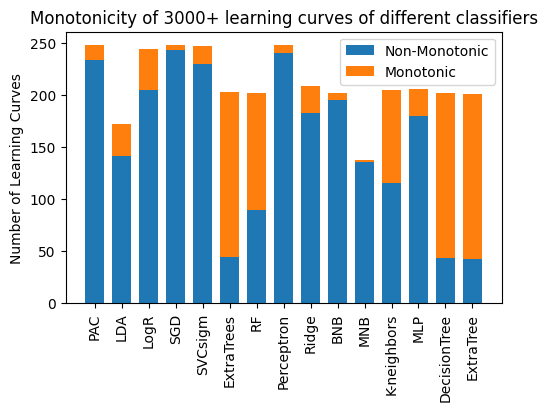

In [7]:


fig, ax = plt.subplots(layout='constrained',figsize=(5,4))
columns = ['PAC', 'LDA', 'LogR', 'SGD', 'SVCsigm', 'ExtraTrees', 'RF', 'Perceptron', 'Ridge', 'BNB', 'MNB', 'K-neighbors', 'MLP', 'DecisionTree', 'ExtraTree']
y_pos = range(len(columns))
plt.bar(y_pos, list(learnersDataNonMon.values()), label='Non-Monotonic', width=0.7)
plt.bar(y_pos, list(learnersDataMon.values()), bottom=list(learnersDataNonMon.values()), label='Monotonic', width=0.7)
plt.xticks(y_pos, columns, rotation=90)

# Set labels and title
# plt.xlabel('Monotonicity ')
plt.ylabel('Number of Learning Curves')
plt.title('Monotonicity of 3000+ learning curves of different classifiers')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [8]:
experiment4_results = pd.DataFrame(rows, columns=['learner', 'dataset_id', 'non-monotone', 'occurrences', 'significance'])
experiment4_results

,learner,dataset_id,non-monotone,occurrences,significance
0,sklearn.linear_model.PassiveAggressiveClassifier,3,True,1,0.958482
1,sklearn.linear_model.PassiveAggressiveClassifier,6,True,1,0.890867
2,sklearn.linear_model.PassiveAggressiveClassifier,11,True,2,0.762162
3,sklearn.linear_model.PassiveAggressiveClassifier,12,False,0,0.000000
4,sklearn.linear_model.PassiveAggressiveClassifier,13,True,1,0.879792
...,...,...,...,...,...
3166,sklearn.tree.ExtraTreeClassifier,42733,True,2,0.621795
3167,sklearn.tree.ExtraTreeClassifier,42734,True,1,0.913043
3168,sklearn.tree.ExtraTreeClassifier,42769,False,0,0.000000
3169,sklearn.tree.ExtraTreeClassifier,42809,False,0,0.000000


In [9]:
experiment4_results.to_csv('experiment4_results.csv')